In [10]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [11]:
import numpy as np
import pickle, os

from matplotlib import pyplot as plt
%matplotlib inline

# from scipy import signal

# from ssm_gp_utils import *

In [12]:
### functions (save in a separate file)

import argparse
import sys
np.set_printoptions(threshold=sys.maxsize)

# from scipy.interpolate import interp1d, PchipInterpolator
from scipy import interpolate
from scipy.spatial.distance import cdist

def interp_centerline(centerline_array, interp_num):
    ### inputs)
    ### centerline_array : shape(len, 2)
    ### interp_num : number of sample points from interpolated line
    
    interpSpl, u = interpolate.splprep([centerline_array[:,0], centerline_array[:,1]], s=10)
    u_interp = np.linspace(0, 1, num=interp_num)
    [centerline_x_interp, centerline_y_interp] = interpolate.splev(u_interp, interpSpl, der=0)
    centerline_interp = np.column_stack((centerline_x_interp[:], centerline_y_interp[:]))

    return centerline_interp  #shape(num=100, 2)


def tag_lane(track, centerlines_dict):
    ### inputs)
    ### track : shape(len(track), 9)
    ###  => columns: frame_id, x, y, vx, vy, psi_rad, agent_type, length, width
    ### centerlines_dict : dictionary of centerlines (keys: lanes)
    
    ### output
    ### track_tagged : shape(len(track), 7)
    ###  => columns: frame_id, x, y, agent_type, length, width, lane
    
    tags = []
    for p, _ in enumerate(track):
        min_dist_dict = dict()
#         lane_idx_dict = dict()
        for lane, centerline in centerlines_dict.items():                    
            min_dist_dict[lane] = np.min(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
#             lane_idx_dict[lane] = np.argmin(cdist(np.array([track[p, 1:3]]), centerline, 'euclidean'))
            
        lane_tag = min(min_dist_dict, key=min_dist_dict.get)
        tags.append([lane_tag]) #, lane_idx_dict[lane_tag]])

        if p == 0 and lane_tag != 'c':
            print('does not start in lane c')

    tags = np.array(tags)
    track_tagged = np.column_stack((track[:, :3], track[:, 6:], tags))
    
    return track_tagged


# (1) Single lane (lane changes not considered)

## Load & Construct vehicle tracks and centerlines

In [13]:
### load vehicle tracks

scene = 'DR_CHN_Merging_ZS'
filenum = '000'

with open('../processed/INTERACTION/%s/veh_tracks_%s.pkl' % (scene, filenum), 'rb') as f:
    veh_tracks_000 = pickle.load(f)
print('veh_tracks_000', type(veh_tracks_000), len(veh_tracks_000))
   
# tracks_dict[track_id] = np.empty((len(df_id), 9), dtype=object)
# tracks_dict[track_id][:, 0] = df_id.frame_id
# tracks_dict[track_id][:, 1] = df_id.x
# tracks_dict[track_id][:, 2] = df_id.y
# tracks_dict[track_id][:, 3] = df_id.vx
# tracks_dict[track_id][:, 4] = df_id.vy
# tracks_dict[track_id][:, 5] = df_id.psi_rad
# tracks_dict[track_id][:, 6] = df_id.agent_type
# tracks_dict[track_id][:, 7] = df_id.length
# tracks_dict[track_id][:, 8] = df_id.width


veh_tracks_000 <class 'dict'> 684


In [14]:
### load & construct centerlines

import re
# from ssm_gp_utils import *

centerlines_path = 'dataset/modified_centerlines_/'
centerlines_listdir = os.listdir(centerlines_path)
print(centerlines_listdir, '\n')

centerlines_dict = dict()
lanes_list = []
for _, file in enumerate(centerlines_listdir):
    lane = re.split('_', file)[1].split('.')[0]

    if lane == 'c' or lane == 'd':
        print('lane', lane)
        
        centerline = open(os.path.join(centerlines_path, file), 'r')
        centerline_temp = [line.split(",") for line in centerline.readlines()]

        centerline_array = []
        for point in centerline_temp:        
            centerline_array.append((float(point[0]), float(point[1])))     
        centerline_array = np.array(centerline_array)
        
        centerline_interp = interp_centerline(centerline_array, 20)
        print('centerline interpolation', len(centerline_array), 'to', len(centerline_interp)) #, centerline_interp)

        centerlines_dict[lane] = centerline_interp
        lanes_list.append(lane)
    
print('\ncenterlines_dict', centerlines_dict.keys())
print('lanes_list', lanes_list)


['centerlines_b1.txt', 'centerlines_b2.txt', 'centerlines_e1.txt', 'centerlines_e2.txt', 'centerlines_f2.txt', 'centerlines_f1.txt', 'centerlines_a.txt', 'centerlines_c.txt', 'centerlines_g.txt', 'centerlines_d.txt'] 

lane c
centerline interpolation 37 to 20
lane d
centerline interpolation 37 to 20

centerlines_dict dict_keys(['c', 'd'])
lanes_list ['c', 'd']


In [15]:
### construct actual_tracks along lane c (for now)

veh_tracks_path = '../processed/INTERACTION/DR_CHN_Merging_ZS/'
veh_tracks_listdir = os.listdir(veh_tracks_path)

actual_tracks_dict_all = dict()
actual_tracks_dict_idm = dict()
actual_tracks_dict_mobil = dict()

new_id = 0
t_span = [0, 0]
# len_tracks = []

for i, file in enumerate(veh_tracks_listdir[:1]):
    with open(os.path.join(veh_tracks_path, file), 'rb') as f:
        veh_tracks_i = pickle.load(f)
    print('veh_tracks_', i, type(veh_tracks_i), len(veh_tracks_i))

    for veh_id, track in veh_tracks_i.items():
#         if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 954 and track[0, 2] < 963:  #lanes c,d
        if track[0, 1] > 1125 and track[0, 1] < 1140 and track[0, 2] > 960 and track[0, 2] < 963:  #lane c
            track_tagged = tag_lane(track, centerlines_dict)
            
            actual_tracks_dict_all[new_id] = track_tagged
            if len(set(track_tagged[:, 6])) == 1:
                actual_tracks_dict_idm[new_id] = track_tagged
            else: actual_tracks_dict_mobil[new_id] = track_tagged
            
            new_id += 1
            t_min = min((t_span[0], track[0,0]))
            t_max = max((t_span[1], track[-1,0]))
            t_span = [t_min, t_max]
#             len_tracks.append(len(track))

print('\nactual_tracks_dict_all', len(actual_tracks_dict_all), actual_tracks_dict_all[0].shape) #, actual_tracks_dict.keys())
print('actual_tracks_dict_idm', len(actual_tracks_dict_idm), actual_tracks_dict_idm[0].shape) #, actual_tracks_dict.keys())
print('actual_tracks_dict_mobil', len(actual_tracks_dict_mobil))

print('\nt_span', t_span)

# actual_tracks_dict_idm[:][0] = frame_id
# actual_tracks_dict_idm[:][1:3] = x, y
# actual_tracks_dict_idm[:][3:6] = agent_type, length, width
# actual_tracks_dict_idm[:][6] = lane


veh_tracks_ 0 <class 'dict'> 684

actual_tracks_dict_all 140 (149, 7)
actual_tracks_dict_idm 128 (149, 7)
actual_tracks_dict_mobil 12

t_span [0, 3512]


# Cartesian -> Frenet conversion 다시 shapely 사용해서 해보기
https://github.com/Toblerity/Shapely

https://stackoverflow.com/questions/19101864/find-minimum-distance-from-point-to-complicated-curve


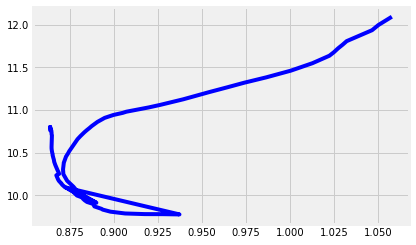

In [847]:
import shapely.geometry as geom
import numpy as np

# coords = np.loadtxt('points_shapely_example.txt')

# line = geom.LineString(coords)
# point = geom.Point(0.8, 10.5)

# # Note that "line.distance(point)" would be identical
# print(point.distance(line))


import numpy as np
import shapely.geometry as geom
import matplotlib.pyplot as plt


class NearestPoint(object):
    def __init__(self, line, ax):
        self.line = line
        self.ax = ax
        ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        x, y = event.xdata, event.ydata
        point = geom.Point(x, y)
        distance = self.line.distance(point)
        self.draw_segment(point)
        print('Distance to line:', distance)

    def draw_segment(self, point):
        point_on_line = line.interpolate(line.project(point))
        self.ax.plot([point.x, point_on_line.x], [point.y, point_on_line.y], 
                     color='red', marker='o', scalex=False, scaley=False)
        fig.canvas.draw()

if __name__ == '__main__':
    coords = np.loadtxt('points_shapely_example.txt')
    line = geom.LineString(coords)

    fig, ax = plt.subplots()
    ax.plot(*coords.T, 'b')
#     ax.axis('equal')
    
    NearestPoint(line, ax)
    plt.show()
    

In [16]:
### x-y coord => s-d coord
### Reference: github.com/fjp/frenet
###           "Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenext Frame"

from cubic_spline_planner import *
from scipy.spatial.distance import cdist

lane_x = centerlines_dict['c'][:,0]  
lane_y = centerlines_dict['c'][:,1]
ds = 0.1  # [m] distance of each intepolated points

sp = Spline2D(lane_x, lane_y)
lane_s = np.arange(0, sp.s[-1], ds)

lane_rx, lane_ry, lane_ryaw, lane_rk = [], [], [], []
for i in range(len(lane_s)):
    xi, yi = sp.calc_position(lane_s[i])
    lane_rx.append(xi)
    lane_ry.append(yi)
    lane_ryaw.append(sp.calc_yaw(lane_s[i]))
    lane_rk.append(sp.calc_curvature(lane_s[i]))
lane_rxy = np.column_stack((lane_rx, lane_ry))


actual_tracks_dict_idm_sd = dict()
for veh_id, track in actual_tracks_dict_idm.items():
    veh_d, veh_s = [], []
    for i in range(len(track)):
        veh_xyi = track[i, 1:3]
        
        distances = cdist(np.array([veh_xyi]), lane_rxy, 'euclidean')
        veh_s.append(lane_s[np.argmin(distances)])
        
        if np.argmin(distances) == 0:
            lane_xyi = lane_rxy[np.argmin(distances)+1, :]
            lane_xyi_prev = lane_rxy[np.argmin(distances), :]
        else:
            lane_xyi = lane_rxy[np.argmin(distances), :]
            lane_xyi_prev = lane_rxy[np.argmin(distances)-1, :]
        [lane_dxi, lane_dyi]  = np.subtract(lane_xyi, lane_xyi_prev)
        [veh_dxi, veh_dyi] = np.subtract(veh_xyi, lane_xyi_prev)
        signi = np.sign(lane_dxi * veh_dyi - lane_dyi * veh_dxi)
        veh_d.append(np.min(distances) * signi)
        
    track_sd = np.column_stack((track[:,0], veh_s, veh_d, track[:,3:]))
    actual_tracks_dict_idm_sd[veh_id] = track_sd
    
    track_xy_new = np.column_stack((track[:,0:3], veh_s, veh_d, track[:,3:]))
    actual_tracks_dict_idm[veh_id] = track_xy_new

print('actual_tracks_dict_idm_sd', len(actual_tracks_dict_idm_sd), actual_tracks_dict_idm_sd[0].shape) #, actual_tracks_dict_idm_sd.keys())
print('actual_tracks_dict_idm', len(actual_tracks_dict_idm), actual_tracks_dict_idm[0].shape) #, actual_tracks_dict_idm_sd.keys())

# actual_tracks_dict_idm[:][0] = frame_id
# actual_tracks_dict_idm[:][1:3] = x, y
# actual_tracks_dict_idm[:][3:5] = s, d
# actual_tracks_dict_idm[:][5:8] = agent_type, length, width
# actual_tracks_dict_idm[:][8] = lane


actual_tracks_dict_idm_sd 128 (149, 7)
actual_tracks_dict_idm 128 (149, 9)


In [31]:
### include vel_sd, distance_headway, headway_vel_sd

actual_tracks_dict_idm_with_headway = dict()
for veh_id, track in actual_tracks_dict_idm.items():
#     if veh_id == 6:
        
        veh_vsvd = []
        track_headway = []
        track_headway_prev = [None]*9
        for i in range(len(track)):
#             print('i', i)
            t = track[i,0]

            if i == 0:
                veh_vsvd.append(track[i+1, 3:5] - track[i, 3:5])
            else:
                veh_vsvd.append(track[i, 3:5] - track[i-1, 3:5])

            dist_headway, veh_id_headway, idx_headway = None, None, None
            track_xy_sd_headway, vsvd_headway = [None]*4, [None]*2
            for veh_id_other, track_other in actual_tracks_dict_idm.items():
                if veh_id_other != veh_id and t >= track_other[0,0] and t <= track_other[-1,0]:

                    idx = np.where(track_other[:,0] == t)[0][0]              
                    dist_other = track_other[idx, 3] - track[i,3]
                    if dist_headway == None:
                        dist_headway = 10e5                    
                    elif dist_other > 0 and dist_other < dist_headway:
                        veh_id_headway = veh_id_other
                        idx_headway = idx
                        dist_headway = dist_other
                        track_xy_sd_headway = track_other[idx, 1:5]

                        if idx == 0:
                            vsvd_headway = track_other[idx+1, 3:5] - track_other[idx, 3:5]
                        else:
                            vsvd_headway = track_other[idx, 3:5] - track_other[idx-1, 3:5]

            if veh_id_headway is None and track_headway_prev is None:
                track_headway.append([None] * 9)
#                 print('case 1, track_headway_prev', track_headway_prev)

            elif veh_id_headway is not None:
                track_headway.append([veh_id_headway] + track_xy_sd_headway.tolist() + vsvd_headway.tolist() +
                                     [idx_headway] + [dist_headway])   
                track_headway_prev = [veh_id_headway] + track_xy_sd_headway.tolist() + vsvd_headway.tolist() + [idx_headway] + [dist_headway]
#                 print('case 2, track_headway_prev', track_headway_prev)
                
            elif veh_id_headway is None and track_headway_prev is not [None]*9:
#                 print('case 3, track_headway_prev', track_headway_prev)
                track_headway.append(track_headway_prev)

        actual_tracks_dict_idm_with_headway[veh_id] = np.column_stack((track[:,:5], veh_vsvd, track[:,5:], track_headway))
    
print('actual_tracks_dict_idm_with_headway', len(actual_tracks_dict_idm_with_headway))
# print('\nactual_tracks_dict_idm_with_headway[0]', actual_tracks_dict_idm_with_headway[0][:,:])
print('\nactual_tracks_dict_idm_with_headway[6]', actual_tracks_dict_idm_with_headway[6][-5:,:])

# actual_tracks_dict_idm_with_headway[:][0] = frame_id #t
# actual_tracks_dict_idm_with_headway[:][1:3] = x, y
# actual_tracks_dict_idm_with_headway[:][3:7] = s, d, vs, vd
# actual_tracks_dict_idm_with_headway[:][7:10] = agent_type, length, width
# actual_tracks_dict_idm_with_headway[:][10] = lane
# actual_tracks_dict_idm_with_headway[:][11:14] = veh_id_headway, headway_x, headway_y 
# actual_tracks_dict_idm_with_headway[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks_dict_idm_with_headway[:][18:20] = headway_idx, dist_headway


actual_tracks_dict_idm_with_headway 128

actual_tracks_dict_idm_with_headway[6] [[303 1008.5939999999999 963.832 139.1 -0.6256204689863418
  0.5999999999999943 -0.020080562226671206 'car' 4.48 1.75 'c' 5.0
  1018.314 960.447 128.9 0.41306252488595885 0.6999999999999886
  -0.029211887170692008 120.0 15.799999999999997]
 [304 1007.987 964.012 139.8 -0.6452536873877656 0.700000000000017
  -0.019633218401423735 'car' 4.48 1.75 'c' 5.0 1018.314 960.447 128.9
  0.41306252488595885 0.6999999999999886 -0.029211887170692008 120.0
  15.799999999999997]
 [305 1007.3810000000001 964.193 140.4 -0.6631744478294731
  0.5999999999999943 -0.01792076044170754 'car' 4.48 1.75 'c' 5.0
  1018.314 960.447 128.9 0.41306252488595885 0.6999999999999886
  -0.029211887170692008 120.0 15.799999999999997]
 [306 1006.7760000000001 964.375 141.0 -0.6820321191303349
  0.5999999999999943 -0.0188576713008618 'car' 4.48 1.75 'c' 5.0 1018.314
  960.447 128.9 0.41306252488595885 0.6999999999999886
  -0.029211887170692008 

## Plots

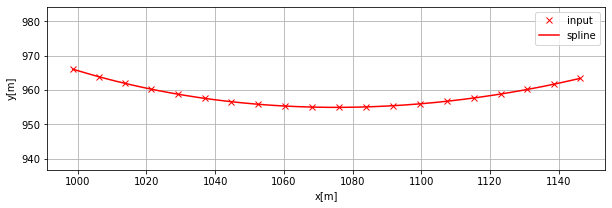

In [32]:
### plot lane converted to s-d coordinates

plt.figure(figsize=(10,3))
plt.plot(lane_x, lane_y, "xr", label="input")
plt.plot(lane_rx, lane_ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()

# plt.figure(figsize=(10,3))
# plt.plot(lane_s, [np.rad2deg(iyaw) for iyaw in lane_ryaw], "-r", label="yaw")
# plt.grid(True)
# plt.legend()
# plt.xlabel("line length[m]")
# plt.ylabel("yaw angle[deg]")

# plt.figure(figsize=(10,3))
# plt.plot(lane_s, lane_rk, "-r", label="curvature")
# plt.grid(True)
# plt.legend()
# plt.xlabel("line length[m]")
# plt.ylabel("curvature [1/m]")

plt.show()


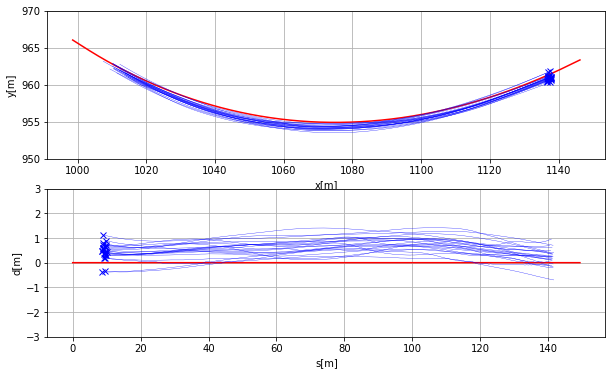

In [33]:
### plot veh_tracks and lane in both coordinates

fig, ax = plt.subplots(2, 1, figsize=(10,6)) 
ax[0].plot(lane_rx, lane_ry, "-r", label="lane_spline")
ax[1].plot(lane_s, np.zeros_like(lane_s), "-r")

for veh_id, track in actual_tracks_dict_idm.items():
    if veh_id < 25:
        track_xy = actual_tracks_dict_idm[veh_id]
        ax[0].plot(track_xy[:-10,1], track_xy[:-10,2], "-b", lw=0.3, label="xy")
        ax[0].plot(track_xy[0,1], track_xy[0,2], "xb", label="xy")

        track_sd = actual_tracks_dict_idm_sd[veh_id]
        ax[1].plot(track_sd[:,1], track_sd[:,2], "-b", lw=0.3, label="sd")
        ax[1].plot(track_sd[0,1], track_sd[0,2], "xb", label="sd")

ax[0].grid(True); # ax[0].axis("equal")
ax[0].set_xlabel("x[m]"); ax[0].set_ylabel("y[m]")
ax[0].set_ylim([950, 970]);

ax[1].grid(True); # ax[1].axis("equal")
ax[1].set_xlabel("s[m]"); ax[1].set_ylabel("d[m]")
ax[1].set_ylim([-3, 3]);


veh_id = 6


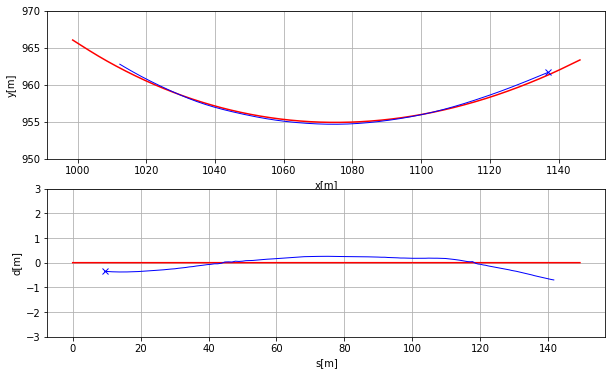

In [34]:
### check track of a specific veh_id

fig, ax = plt.subplots(2, 1, figsize=(10,6)) 
ax[0].plot(lane_rx, lane_ry, "-r", label="lane_spline")
ax[1].plot(lane_s, np.zeros_like(lane_s), "-r")

veh_id = 6
print('veh_id =', veh_id)
track_xy = actual_tracks_dict_idm[veh_id]
ax[0].plot(track_xy[:-10,1], track_xy[:-10,2], "-b", lw=1.0, label="xy")
ax[0].plot(track_xy[0,1], track_xy[0,2], "xb", label="xy")

track_sd = actual_tracks_dict_idm_sd[veh_id]
ax[1].plot(track_sd[:,1], track_sd[:,2], "-b", lw=1.0, label="sd")
ax[1].plot(track_sd[0,1], track_sd[0,2], "xb", label="sd")
        
ax[0].grid(True); # ax[0].axis("equal")
ax[0].set_xlabel("x[m]"); ax[0].set_ylabel("y[m]")
ax[0].set_ylim([950, 970])

ax[1].grid(True)
ax[1].set_xlabel("s[m]"); ax[1].set_ylabel("d[m]")
ax[1].set_ylim([-3, 3]);


In [35]:
### retrieve s-d coord => x-y coord 
### (check if retrived is same as original)

retrieved_tracks_dict_idm_xy = dict()
for veh_id, track_sd in actual_tracks_dict_idm_sd.items():
    veh_s, veh_d = track_sd[:,1], track_sd[:,2]

    veh_x_ret, veh_y_ret = [], []
    for i in range(len(veh_s)):
        lane_xi, lane_yi = sp.calc_position(veh_s[i])
        yawi = sp.calc_yaw(veh_s[i])
        xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
        yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

        veh_x_ret.append(xi_ret)
        veh_y_ret.append(yi_ret)

    track_xy_ret = np.column_stack((track_sd[:,0], veh_x_ret, veh_y_ret, track_sd[:,3:]))
    retrieved_tracks_dict_idm_xy[veh_id] = track_xy_ret
        
print('retrieved_tracks_dict_idm_xy', len(retrieved_tracks_dict_idm_xy)) 


retrieved_tracks_dict_idm_xy 128


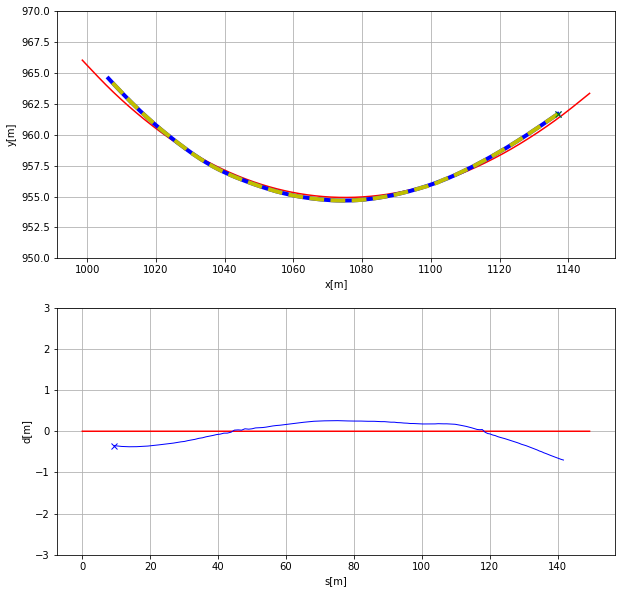

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(10,10)) 
ax[0].plot(lane_rx, lane_ry, "-r", label="lane_spline")
ax[1].plot(lane_s, np.zeros_like(lane_s), "-r")

for veh_id, track in actual_tracks_dict_idm.items():
    if veh_id == 6:
        track_xy = actual_tracks_dict_idm[veh_id]
        track_sd = actual_tracks_dict_idm_sd[veh_id]
        track_xy_ret = retrieved_tracks_dict_idm_xy[veh_id]

        ax[0].plot(track_xy[:,1], track_xy[:,2], "-b", lw=4, label="xy")
        ax[0].plot(track_xy[0,1], track_xy[0,2], "xb", label="xy")
        
        ax[0].plot(track_xy_ret[:,1], track_xy_ret[:,2], "--y", lw=4, label="xy")
        ax[0].plot(track_xy[0,1], track_xy[0,2], "xg", label="xy")
        
        ax[1].plot(track_sd[:,1], track_sd[:,2], "-b", lw=1.0, label="sd")
        ax[1].plot(track_sd[0,1], track_sd[0,2], "xb", label="sd")
        

ax[0].grid(True); # ax[0].axis("equal")
ax[0].set_xlabel("x[m]"); ax[0].set_ylabel("y[m]")
ax[0].set_ylim([950, 970])

ax[1].grid(True); # ax[1].axis("equal")
ax[1].set_xlabel("s[m]"); ax[1].set_ylabel("d[m]")
ax[1].set_ylim([-3, 3]);


## Interactive animation

In [37]:
from IPython.display import display
import ipywidgets
# import tikzplotlib
# from matplotlib.collections import LineCollection


In [38]:
def simulate(veh_id):
    
    track = actual_tracks_dict_idm_with_headway[veh_id]
    min_t, max_t = track[0,0], track[-1,0]
    print('veh_id: %s, t_span: %s-%s' % (veh_id, min_t, max_t))
    
    def update_t(t):
        global save_t
        save_t = t

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        fig, ax = plt.subplots(2, 1, figsize=(12,7)) 

        ### Plot own vehicle in s-d coordinate
        ax[0].set_title('s-d coordinate')
        ax[0].set_xlabel("s[m]"); ax[0].set_ylabel("d[m]"); ax[0].grid()
        ax[0].set_ylim([-3, 3])
        
        ax[0].arrow(lane_s[0], lane_s[1]-0.8, 8, 0, color='r', length_includes_head=True, head_width=0.3, head_length=1)
        ax[0].plot(lane_s, np.zeros_like(lane_s), "--r")
                
        idx = np.where(track[:,0]==t)[0]   
        ax[0].scatter(track[idx, 3], track[idx, 4], s=50, c='b')
        ax[0].plot(track[:, 3], track[:, 4], '--b', lw=0.8)
        ax[0].text(track[idx, 3], track[idx, 4]+0.4, str(veh_id), fontsize=12, va="center", ha="center", color='b')
        ax[0].text(lane_s[0], lane_s[1]+2.5, 'veh_id:%s (front:%s)' % (veh_id, track[idx, 9][0]), 
                   fontsize=12, va="center", ha="left", color='b')
        
    
        ### Plot own vehicle in x-y coordinate
        ax[1].set_title('x-y coordinate')
        ax[1].set_xlabel("x[m]"); ax[1].set_ylabel("y[m]"); ax[1].grid()
        ax[1].set_ylim([950, 970])
        
        ax[1].arrow(lane_rx[0], lane_ry[0]+4, -7, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
        ax[1].plot(lane_rx, lane_ry, "--r")
                
        ax[1].scatter(track[idx, 1], track[idx, 2], s=50, c='b')
        ax[1].plot(track[:, 1], track[:, 2], '--b', lw=0.8)
        ax[1].text(track[idx, 1], track[idx, 2]-1.5, str(veh_id), fontsize=12, va="center", ha="center", color='b')

        
        ### Plot other vehicles in both coordinates
        for veh_id_other, track_other in actual_tracks_dict_idm_with_headway.items():
            if veh_id_other != veh_id and track_other[0,0] < t and track_other[-1,0] > t:
                idx_other = np.where(track_other[:,0] == t)[0][0]
                ax[0].scatter(track_other[idx_other, 3], track_other[idx_other, 4], s=50, c='g')
#                 ax[0].plot(track_other[:, 3], track_other[:, 4], '--g', lw=0.3)
                ax[0].text(track_other[idx_other, 3], track_other[idx_other, 4]+0.4,
                           str(veh_id_other), fontsize=12, va="center", ha="center", color='g')
    
                ax[1].scatter(track_other[idx_other, 1], track_other[idx_other, 2], s=50, c='g')
#                 ax[1].plot(track_other[:, 1], track_other[:, 2], '--g', lw=0.3)
                ax[1].text(track_other[idx_other, 1], track_other[idx_other, 2]-1.5,
                           str(veh_id_other), fontsize=12, va="center", ha="center", color='g')
        
        update_t(t)

        global save_t
        global save        
        if save == 1:
            print('save at t=', t)
            plt.savefig("screenshot_veh_id=%s_t=%s.pdf" % (veh_id, int(save_t)))
            plt.close()
            save = 0

    global save
    save_t = 10
    save = 0
    
    button = ipywidgets.Button(description="Save screenshot")
    display(button)

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 10))
    output = widget.children[-1]
    output.layout.height = '450px'
    display(widget)


    def on_button_clicked(b):
        global save_t
        print('Save screenshot of veh_id=%s at t=%s' % (veh_id, int(save_t)))
        global save
        save = 1
        f(save_t)
    
    button.on_click(on_button_clicked)


In [25]:
simulate(6)


veh_id: 6, t_span: 162-307


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=232, description='t', max=307, min=162, step=10), Output(layout=Layout(h…

# Preprocess

In [ ]:

# actual_tracks_dict_idm_with_headway
## Let's call actual_tracks_dict_idm_with_headway -> actual_tracks

# actual_tracks[:][0] = frame_id #t
# actual_tracks[:][1:3] = x, y
# actual_tracks[:][3:7] = s, d, vs, vd
# actual_tracks[:][7:10] = agent_type, length, width
# actual_tracks[:][10] = lane
# actual_tracks[:][11:14] = veh_id_headway, headway_x, headway_y 
# actual_tracks[:][14:18] = headway_s, headway_d, headway_vs, headway_vd
# actual_tracks[:][18:20] = headway_idx, dist_headway


In [85]:
# X_train = []
# Y_train = []

# for veh_id, track in actual_tracks_dict_idm_with_headway.items():
#     if veh_id <= 120:     
# #         print('veh_id', veh_id, 'track', len(track)) #, track[0,:])

#         for i in range(len(track)-2):
#             if track[i, 11] != None and track[i+1, 11] != None and track[i+2, 11] != None:
#                 X_train_i = np.concatenate((track[i, 5:7], track[i, 5:7] - track[i, 16:18], [track[i, 19]],  #v(t), r(t), d(t)
#                                track[i+1, 5:7], track[i+1, 5:7] - track[i+1, 16:18], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                track[i+2, 5:7], track[i+2, 5:7] - track[i+2, 16:18], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)
#                 X_train.append(X_train_i) 

                
#                 if i == len(track)-3:
#                     Y_train_i = np.concatenate((track[i+1, 5:7] - track[i, 5:7],  #a(t)
#                                    track[i+2, 5:7] - track[i+1, 5:7],   #a(t+1)
#                                    track[i+2, 5:7] - track[i+2, 5:7]))  #a(t+2)
#                     Y_train.append(Y_train_i)
#                 else:
#                     Y_train_i = np.concatenate((track[i+1, 5:7] - track[i, 5:7],  #a(t)
#                                    track[i+2, 5:7] - track[i+1, 5:7],   #a(t+1)
#                                    track[i+3, 5:7] - track[i+2, 5:7]))  #a(t+2)
#                     Y_train.append(Y_train_i)


In [ ]:
# ## prediction

# X_halluc = []
# Y_pred = []

# for veh_id, track in actual_tracks_dict_idm_with_headway.items():
#     if veh_id == 120: #> 120:  
#         i = 0
#         for i in range(5): #(len(track)-2):
#             if i == 0:
#                 if track[i, 11] != None and track[i+1, 11] != None and track[i+2, 11] != None:
#                     X_test_i = np.concatenate((track[i, 5:7], track[i, 5:7] - track[i, 16:18], [track[i, 19]],  #v(t), r(t), d(t)
#                                    track[i+1, 5:7], track[i+1, 5:7] - track[i+1, 16:18], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                    track[i+2, 5:7], track[i+2, 5:7] - track[i+2, 16:18], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)                
#                     X_halluc.append(X_test_i)
            
#                     p_ind = np.random.choice(range(means.shape[0]), 1, p=cluster_probs)[0]
#                     obs_p = 15
#                     given_b = X_test_i
#                     print('given_b', given_b.shape, 'p_ind', p_ind, 'means', means.shape, 'covs', covs.shape)

#                     Y_pred_i = conditional_gaussian(means, covs, p_ind, obs_p, given_b)  #(6,) check!
#                     print('Y_pred_i', Y_pred_i)
#                     Y_pred.append(Y_pred_i)
            
#             else:
#                 X_test_i = np.concatenate((track[i, 5:7] + Y_pred_i[:2], track[i, 5:7] - track[i, 16:18], [track[i, 19]],  #v(t), r(t), d(t)
#                                track[i+1, 5:7] + Y_pred_i[2:4], track[i+1, 5:7] - track[i+1, 16:18], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                track[i+2, 5:7] + Y_pred_i[4:6], track[i+2, 5:7] - track[i+2, 16:18], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)                

#                 X_halluc.append(X_test_i)
                
#                 p_ind = np.random.choice(range(means.shape[0]), 1, p=cluster_probs)[0]
#                 obs_p = 15
#                 given_b = X_test_i
#                 Y_pred_i = conditional_gaussian(means, covs, p_ind, obs_p, given_b)  #(6,) check!
#                 print('Y_pred_i', Y_pred_i)
#                 Y_pred.append(Y_pred_i)


In [39]:
X_train = []
Y_train = []

for veh_id, track in actual_tracks_dict_idm_with_headway.items():
    if veh_id <= 120:     
        print('veh_id', veh_id, 'track', len(track)) #, track[0,:])

        for i in range(len(track)-2):
            if track[i, 11] != None and track[i+1, 11] != None and track[i+2, 11] != None:
                X_train_i = np.concatenate(([track[i, 5]], [track[i, 5] - track[i, 16]], [track[i, 19]],  #v(t), r(t), d(t)
                                           [track[i+1, 5]], [track[i+1, 5] - track[i+1, 16]], [track[i+1, 19]],  #v(t+1), r(t+1), d(t+1)
                                           [track[i+2, 5]], [track[i+2, 5] - track[i+2, 16]], [track[i+2, 19]],  #v(t+2), r(t+2), d(t+2)
                                           [track[i, 3]], [track[i+1, 3]], [track[i+2, 3]]))  #s(t), s(t+1), s(t+2)

                X_train.append(X_train_i) 

                
                if i == len(track)-3:
                    Y_train_i = np.concatenate(([track[i+1, 5] - track[i, 5]],    #a(t)
                                                [track[i+2, 5] - track[i+1, 5]],  #a(t+1)
                                                [track[i+2, 5] - track[i+2, 5]],  #a(t+2)
                                                [track[i+1, 5]], [track[i+2, 5]], [track[i+2, 5]],   #v(t+1), v(t+2), v(t+3)
                                                [track[i+1, 3]], [track[i+2, 3]], [track[i+2, 3]]))  #s(t+1), s(t+2), s(t+3)
                    Y_train.append(Y_train_i)
                else:
                    Y_train_i = np.concatenate(([track[i+1, 5] - track[i, 5]],    #a(t)
                                                [track[i+2, 5] - track[i+1, 5]],  #a(t+1)
                                                [track[i+3, 5] - track[i+2, 5]],  #a(t+2)
                                                [track[i+1, 5]], [track[i+2, 5]], [track[i+3, 5]],   #v(t+1), v(t+2), v(t+3)
                                                [track[i+1, 3]], [track[i+2, 3]], [track[i+3, 3]]))  #s(t+1), s(t+2), s(t+3)
                    Y_train.append(Y_train_i)
#                 print('Y_train_i', Y_train_i)




veh_id 0 track 149
veh_id 1 track 147
veh_id 2 track 144
veh_id 3 track 144
veh_id 4 track 144
veh_id 5 track 140
veh_id 6 track 146
veh_id 7 track 141
veh_id 8 track 142
veh_id 9 track 133
veh_id 10 track 138
veh_id 11 track 134
veh_id 12 track 130
veh_id 13 track 139
veh_id 14 track 181
veh_id 15 track 198
veh_id 17 track 201
veh_id 18 track 217
veh_id 19 track 212
veh_id 20 track 216
veh_id 21 track 218
veh_id 22 track 227
veh_id 23 track 275
veh_id 25 track 285
veh_id 26 track 279
veh_id 27 track 287
veh_id 28 track 277
veh_id 29 track 277
veh_id 30 track 282
veh_id 31 track 300
veh_id 32 track 303
veh_id 33 track 299
veh_id 34 track 300
veh_id 35 track 278
veh_id 36 track 259
veh_id 37 track 242
veh_id 38 track 230
veh_id 39 track 238
veh_id 41 track 183
veh_id 42 track 177
veh_id 43 track 181
veh_id 44 track 178
veh_id 45 track 170
veh_id 46 track 171
veh_id 47 track 166
veh_id 48 track 168
veh_id 49 track 176
veh_id 50 track 182
veh_id 51 track 189
veh_id 52 track 193
veh_id 53 

## GMM

In [26]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split


In [341]:
# gmm = GaussianMixture(3, reg_covar=1e-5)
# gmm_input = np.column_stack((X_train, Y_train))  #X_train (_,9), Y_train (_,3)
# print('gmm_input', gmm_input.shape)

# gmm.fit(gmm_input)
# means, covs, cluster_probs = gmm.means_, gmm.covariances_, gmm.weights_
# print('means', means.shape, 'covs', covs.shape)

gmm_input (19938, 12)
means (3, 12) covs (3, 12, 12)


In [360]:

# def conditional_gaussian(means, covs, p_ind, obs_p, given_b):    
#     mu_a = means[p_ind, obs_p:]
#     mu_b = means[p_ind, :obs_p]
# #     print('mu_a', mu_a.shape, 'mu_b', mu_b.shape)
    
#     sigma_A = covs[p_ind, obs_p:, obs_p:]
#     sigma_B = covs[p_ind, :obs_p, :obs_p]
#     sigma_C = covs[p_ind, obs_p:, :obs_p]
# #     print('sigma_A', sigma_A.shape, 'sigma_B', sigma_B.shape, 'sigma_C', sigma_C.shape)

#     mu_a_b = mu_a + sigma_C.dot(np.linalg.inv(sigma_B)).dot(given_b - mu_b)
#     sigma_a_b = sigma_A - sigma_C.dot(np.linalg.inv(sigma_B)).dot(sigma_C.T)
# #     print('mu_a_b', mu_a_b.shape, mu_a_b, 'sigma_a_b', sigma_a_b.shape, sigma_a_b)
    
# #     Y_pred_ij = scipy.stats.truncnorm.rvs(np.array([-0.1, -0.1, -0.1]), 
# #                                           np.array([0.1, 0.1, 0.1]), 
# #                                           loc=mu_a_b, scale=sigma_a_b)  
#     Y_pred_ij = np.random.multivariate_normal(mu_a_b, sigma_a_b, 1)
# #     print('Y_pred_ij', Y_pred_ij)
#     return Y_pred_ij


In [389]:
# ## prediction

# X_halluc = []
# track_own_halluc = []; track_headway_halluc = []
# Y_pred = []

# for veh_id, track in actual_tracks_dict_idm_with_headway.items():
#     if veh_id == 100: #> 120:  
#         print(len(track))
# #         i = 0
#         s_own = np.concatenate(([track[0, 3]], [0]))
#         s_headway = np.concatenate(([track[0, 14]], [0]))
#         track_own_halluc.append(s_own)
#         track_headway_halluc.append(s_headway)
    
#         for i in range(len(track)-2):
#             if track[i, 11] != None and track[i+1, 11] != None and track[i+2, 11] != None:
# #                 print('i', i)
            
#                 if i == 0:
#                     X_test_i = np.concatenate(([track[i, 5]], [track[i, 5] - track[i, 16]], [track[i, 19]],  #v(t), r(t), d(t)
#                                [track[i+1, 5]], [track[i+1, 5] - track[i+1, 16]], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                [track[i+2, 5]], [track[i+2, 5] - track[i+2, 16]], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)
#                 else:
#                     X_test_i = np.concatenate(([track[i, 5] + max(min(Y_pred_i[0],-0.1),0.1)], [track[i, 5] - track[i, 16]], [track[i, 19]],  #v(t), r(t), d(t)
#                                [track[i+1, 5] + max(min(Y_pred_i[1],-0.1),0.1)], [track[i+1, 5] - track[i+1, 16]], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                [track[i+2, 5] + max(min(Y_pred_i[2],-0.1),0.1)], [track[i+2, 5] - track[i+2, 16]], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)
# #                     X_test_i = np.concatenate(([track[i, 5] + Y_pred_i[0]], [track[i, 5] - track[i, 16]], [track[i, 19]],  #v(t), r(t), d(t)
# #                                [track[i+1, 5] + Y_pred_i[1]], [track[i+1, 5] - track[i+1, 16]], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
# #                                [track[i+2, 5] + Y_pred_i[2]], [track[i+2, 5] - track[i+2, 16]], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)


#                 X_halluc.append(X_test_i)

#                 s_own = s_own + [X_test_i[0], 0]
#                 s_headway = s_headway + [X_test_i[0] - X_test_i[1], 0]

#                 track_own_halluc.append(s_own)
#                 track_headway_halluc.append(s_headway)        
        
#                 p_ind = np.random.choice(range(means.shape[0]), 1, p=cluster_probs)[0]
#                 obs_p = 9
#                 given_b = X_test_i
#                 Y_pred_i = conditional_gaussian(means, covs, p_ind, obs_p, given_b)[0]  #(6,) check!
# #                 print('X_test_i', X_test_i)
#                 print('Y_pred_i', p_ind, Y_pred_i)
#                 Y_pred.append(0.5 * Y_pred_i)

# #         print('track', track.shape)
# #         print('track_own_halluc', np.array(track_own_halluc).shape, track_own_halluc[:5])
#         track_own_halluc = np.column_stack((range(len(track_own_halluc)), track_own_halluc))
#         track_headway_halluc = np.column_stack((range(len(track_headway_halluc)), track_headway_halluc))
        

#         print(track_own_halluc.shape)  
#         print(track_headway_halluc.shape)

173
Y_pred_i 0 [ 0.00895488 -0.00820192 -0.07780223]
Y_pred_i 0 [ 0.00684074 -0.00460063 -0.06358842]
Y_pred_i 1 [ 0.00372889 -0.00654386 -0.01805516]
Y_pred_i 0 [-0.0029342   0.00071524 -0.11703627]
Y_pred_i 0 [ 0.00428581 -0.09536363  0.15112856]
Y_pred_i 2 [-0.10254644  0.09328385 -0.03808887]
Y_pred_i 0 [ 0.09974512  0.00271466 -0.15589661]
Y_pred_i 0 [-0.00148469 -0.09779674  0.00719896]
Y_pred_i 0 [-0.0984836   0.10803433 -0.08937299]
Y_pred_i 0 [ 0.09867038 -0.10322374  0.0315923 ]
Y_pred_i 0 [-0.10740023  0.10379562  0.06188542]
Y_pred_i 0 [ 0.11013133 -0.10353013  0.00047324]
Y_pred_i 0 [-0.09511011 -0.00502755  0.06610686]
Y_pred_i 1 [-0.05108619 -0.00873941  0.02469809]
Y_pred_i 1 [-0.00305075  0.09712376 -0.14503871]
Y_pred_i 0 [ 0.09523615 -0.09670294 -0.02780233]
Y_pred_i 1 [-0.0544374  -0.0542948   0.12384659]
Y_pred_i 0 [ 0.00206972 -0.00113934 -0.05356844]
Y_pred_i 0 [0.0018885  0.00148174 0.00228917]
Y_pred_i 1 [-0.01041359  0.15333408 -0.16613275]
Y_pred_i 1 [ 0.1391

i 134
track_headway_halluc_xy 133.0
terminate_i 134



i 133


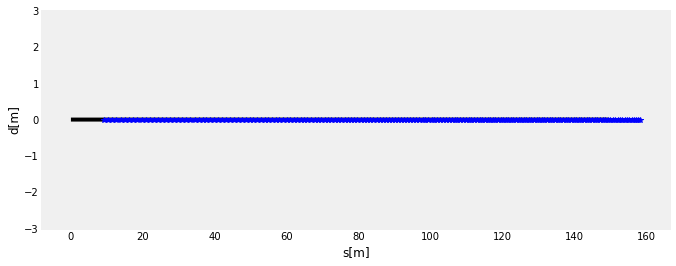

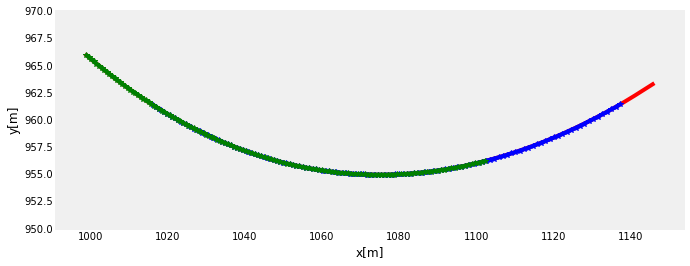

In [1192]:

# plt.figure(figsize=(10,4))
# plt.plot(lane_s, np.zeros_like(lane_s), "-k")

# plt.plot(track_own_halluc[:,1], track_own_halluc[:,2], "-*b", lw=4, label="sd_own")
# # plt.plot(track_headway_halluc[:,1], track_headway_halluc[:,2], "-*g", lw=4, label="sd_headway")

# plt.xlabel("s[m]"); plt.ylabel("d[m]")
# plt.ylim([-3, 3]); plt.grid()


# veh_s, veh_d = track_headway_halluc[:,1], track_headway_halluc[:,2]
# veh_x_ret, veh_y_ret = [], []
# for i in range(len(veh_s)):
#     lane_xi, lane_yi = sp.calc_position(veh_s[i])
#     if lane_xi == None:
#         print('i',i)
#         terminate_i = i
#         break
#     yawi = sp.calc_yaw(veh_s[i])
#     xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
#     yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

#     veh_x_ret.append(xi_ret)
#     veh_y_ret.append(yi_ret)
    
# track_headway_halluc_xy = np.column_stack((range(len(veh_x_ret)), veh_x_ret, veh_y_ret))
# # track_headway_halluc_xy_explode = np.column_stack((range(len(veh_x_ret)), veh_x_ret, veh_y_ret))

# print('track_headway_halluc_xy', track_headway_halluc_xy[-1,0])
# print('terminate_i', terminate_i)

# print('\n\n')

# veh_s, veh_d = track_own_halluc[:,1], track_own_halluc[:,2]
# # print(len(veh_s), veh_s[0])

# veh_x_ret, veh_y_ret = [], []
# for i in range(len(veh_s)):
#     lane_xi, lane_yi = sp.calc_position(veh_s[i])
#     if i == terminate_i-1:
# #     if lane_xi == None:
#         print('i',i)
#         break
#     yawi = sp.calc_yaw(veh_s[i])
#     xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
#     yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

#     veh_x_ret.append(xi_ret)
#     veh_y_ret.append(yi_ret)
    
# track_own_halluc_xy = np.column_stack((range(len(veh_x_ret)), veh_x_ret, veh_y_ret))
# # track_own_halluc_xy_explode = np.column_stack((range(len(veh_x_ret)), veh_x_ret, veh_y_ret))


# plt.figure(figsize=(10,4))
# plt.plot(lane_rx, lane_ry, "-r", label="lane_spline")
# plt.plot(track_own_halluc_xy[:,1], track_own_halluc_xy[:,2], "*-b")
# plt.plot(track_headway_halluc_xy[:,1], track_headway_halluc_xy[:,2], "*-g")
# plt.xlabel("x[m]"); plt.ylabel("y[m]")
# plt.ylim([950, 970]); plt.grid()




In [40]:
def simulate(track_own_halluc_xy, track_headway_halluc_xy, terminate_i, t_end):
    
    track = track_own_halluc_xy #actual_tracks_dict_idm_with_headway[veh_id]
    min_t, max_t = track[0,0], track[-1,0]
#     print('veh_id: %s, t_span: %s-%s' % (veh_id, min_t, max_t))
    veh_id = 100
    
    map_file = 'maps/' + scene + '.osm'
    
    
    def update_t(t):
        global save_t
        save_t = t

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_rx[0]+10, lane_ry[0], -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_rx, lane_ry, "--r")

        ### Plot own vehicle
        idx = np.where(track[:,0]==t)[0] 
        plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
        plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
        plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')

        
#         ### Plot headway vehicle
        track_other = track_headway_halluc_xy
#         idx_other = np.where(track_other[:,0] == t)[0][0]
        idx_other = idx
        plt.scatter(track_other[idx_other, 1], track_other[idx_other, 2], s=80, c='g')
        plt.plot(track_other[:, 1], track_other[:, 2], '--g', lw=1.2)
        plt.text(track_other[idx_other, 1], track_other[idx_other, 2]+3,
                   str(veh_id_other), fontsize=15, va="center", ha="center", color='g')

    
        update_t(t)

        global save_t
        global save        
        if save == 1:
            print('save at t=', t)
#             plt.savefig("screenshot_veh_id=%s_t=%s.pdf" % (veh_id, int(save_t)))
            plt.close()
            save = 0

    global save
    save_t = 10
    save = 0
    
    button = ipywidgets.Button(description="Save screenshot")
    display(button)

    widget = ipywidgets.interactive(f, t=(0, terminate_i, t_end))
    output = widget.children[-1]
    output.layout.height = '450px'
    display(widget)


    def on_button_clicked(b):
        global save_t
#         print('Save screenshot of veh_id=%s at t=%s' % (veh_id, int(save_t)))
        global save
        save = 1
        f(save_t)
    
    button.on_click(on_button_clicked)
    

In [28]:
# simulate(track_own_halluc_xy_explode, track_headway_halluc_xy_explode, 30, 1)

## gaussian-continuous hidden variables
## evolution of positions

In [49]:
from scipy.integrate import quad

def get_s_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean



def joint_prob_single(x, y, mu_z, sigma_z, sigma_eps):
    s_prev = x[9]
    s_new = y[6]
    
    z = multi_normal.rvs(mean=mu_z, cov=sigma_z, size=1, random_state=None)
    prob = multi_normal(get_s_IDM(x[:, 0:3], s_prev, z), eps).pdf(s_new) * \
            multi_normal(mu_z, sigma_z).pdf(z) * \
            multi_normal(0, sigma_eps).pdf(eps)
    return prob


quad(joint_prob_single, -np.inf, np.inf, args=(z, sigma_eps))[0]


    
    


NameError: name 'z' is not defined

In [ ]:
# def em_single_step(X_train, Y_train, mu_z_init, sigma_z_init, z_probs_init, sigma_eps_init, n_steps, optimizer):    
# #     z_probs = z_probs_init      # probs_list
# #     eps_probs = eps_probs_init  # 3 * probs_list
#     mu_z = mu_z_init
#     sigma_z = sigma_z_init
#     sigma_eps = sigma_eps_init
    
    
#     marginal_ll_history = []
#     marginal_ll = -np.infty
#     tol = 0.1
    
#     for l in range(n_steps):
#         print('\nstep', l)
#         prev_marginal_ll = marginal_ll
        
#         ## E-step : update weights (Q's)
# #         weights = np.zeros((len(Y_train), len(z_range), len(eps_range)))

#         for i in range(len(Y_train)):  # each data
#             prob = joint_prob_single(X_train[i], Y_train[i], mu_z, sigma_z, sigma_eps)
            
#             for z_ind in range(len(z_range)):
#                 for eps1_ind in range(len(eps_range)):
#                     weights[i,z_ind,eps1_ind] = joint_prob_single(X_train[i], Y_train[i], z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind)
        
#         weights_normed = weights / np.sum(weights, axis=(1,2))[:,None,None] # normalize the weights
#  #         print('weights_normed', weights_normed.shape)

#         marginal_ll = np.sum(weights)
#         marginal_ll_history.append(marginal_ll)
#         print('marginal likelihood :', marginal_ll)
        
        
#         ## M-step : update z_probs, eps_probs
#         if optimizer == 'lagrange':      
#             z_probs = np.sum(weights_normed, axis=(0,2)) / np.shape(weights)[0]
# #             print('z_probs', z_probs.shape, z_probs)
#             eps_probs[0] = np.sum(weights_normed, axis=(0,1)) / np.shape(weights)[0]
# #             print('eps_probs', eps_probs[0].shape, eps_probs[0])
            
#         else:
#             func_z = lambda z: - np.sum(np.sum(weights_normed, axis=2) * np.log(z))
# #             if optimizer == 'simplex':
# #                 z_probs_new = scipy.optimize.fmin(func_z, z_probs)
#             if optimizer == 'lbfgsb':
#                 z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
#                 z_probs_new = z_opt[0] 

#             z_probs = z_probs_new / np.sum(z_probs_new)
#             #         print('z_probs_new', z_opt[0]) 
#             print('z_opt', z_opt[0], 'f(z)', z_opt[1], ', grad', z_opt[2]['grad'])
#             print('z_probs', z_probs)

#             func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=1) * np.log(eps))
#             if optimizer == 'simplex':
#                 eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
#             if optimizer == 'lbfgsb':
#                 eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
#                 eps1_probs_new = eps1_opt[0]

#             eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
#             print('eps1_opt', eps1_opt[0], 'f(eps1)', eps1_opt[1], ',grad', eps1_opt[2]['grad'])
#             print('eps_probs1', eps_probs[0])

        
#         if np.abs(marginal_ll - prev_marginal_ll) < tol:
#             break
#         if marginal_ll - prev_marginal_ll > 0:
#             z_probs_opt = z_probs
#             eps_probs_opt = eps_probs
#             marginal_ll_opt = marginal_ll
        
#     eps_probs_opt = [eps_probs_opt[0]]
#     print('\nz_probs_opt', z_probs_opt)
#     print('eps_probs_opt', eps_probs_opt)
        
#     return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


In [1084]:
z_probs_lbfgsb_single, eps_probs_lbfgsb_single, _, _ = em_single_step(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                 n_steps, z_range, eps_range, optimizer='lbfgsb')



step 0
marginal likelihood : 352.72386410666303
z_opt [ 431096.78160288 1715785.59224341 1659486.83999444 1313863.93343495
  788212.85494429] f(z) -28188.42315558481 , grad [0. 0. 0. 0. 0.]
z_probs [0.0729628  0.29039541 0.28086689 0.22237047 0.13340443]
eps1_opt [1645783.39488746 1383434.22981109 1394385.06327704 2824296.40362633] f(eps1) -29216.019081443985 ,grad [0. 0. 0. 0.]
eps_probs1 [0.22707041 0.19087383 0.19238472 0.38967104]

step 1
marginal likelihood : 402.04903807936336
z_opt [1436142.10451393 2822231.14000937 3881825.03591435 2358929.75020915
 1346135.82409609] f(z) -29684.580585359257 , grad [0. 0. 0. 0. 0.]
z_probs [0.12124188 0.23825819 0.32771115 0.1991454  0.11364338]
eps1_opt [ 686718.31731575  985599.33787318  927851.2987563  1935713.74808712] f(eps1) -28233.184888954223 ,grad [0. 0. 0. 0.]
eps_probs1 [0.15139684 0.21728942 0.20455805 0.42675569]

step 2
marginal likelihood : 398.9868584392275
z_opt [ 3721679.39557035 15016485.51421049 14159135.50270091 17076035.8

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning:invalid value encountered in log


marginal likelihood : 427.4349228120459
z_opt [ 249917.63522207  983661.93380479 1297371.65983784 1219260.49311932
  317018.38735408] f(z) -27691.686681209496 , grad [0. 0. 0. 0. 0.]
z_probs [0.06144664 0.24185057 0.31898162 0.29977662 0.07794454]
eps1_opt [ 1773545.70793352   800280.4833668   3071817.3907566  11224526.67028848] f(eps1) -31863.652530644023 ,grad [0. 0. 0. 0.]
eps_probs1 [0.10512909 0.04743761 0.18208574 0.66534756]

step 4
marginal likelihood : 431.0775933403443
z_opt [1535475.79477758 1873759.6010661  2067384.8730619  1508922.15203272
  421791.87752896] f(z) -28726.188609910663 , grad [0. 0. 0. 0. 0.]
z_probs [0.20729128 0.25296004 0.27909971 0.2037065  0.05694247]
eps1_opt [1557659.76343702  380010.92844625 1306369.11359558 3617631.34280493] f(eps1) -29633.62960955655 ,grad [0. 0. 0. 0.]
eps_probs1 [0.2270088  0.05538169 0.19038644 0.52722307]

step 5
marginal likelihood : 406.55607251640913
z_opt [1375897.31238674 2549587.84712126 3375371.87414097 2295932.2346562
  

In [46]:
from scipy.stats import multivariate_normal as multi_normal
from scipy.optimize import curve_fit

def get_a_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    return a_IDM_mean
    
def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    
    return s_IDM_mean


def obj_func(x, y, mu_z, sigma_z, sigma_eps):
    s_prev = x[:, 9:12]
    s_new = y[:, 6:9]
    
    z = multi_normal.rvs(mean=mu_z, cov=sigma_z, size=1, random_state=None)
    
    prob = multi_normal(get_s_IDM(x[:, 0:3], s_prev[:, 0], z), sigma_eps).pdf(s_new[0])


# def joint_prob_s_shared(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind):    
#     s_prev = x[9:12]
#     s_new = y[6:9]

#     prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
#     multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[1]) * \
#     multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[2]) * \
#     eps_probs[0][eps1_ind] * z_probs[z_ind]
#     return prob

X_train = np.array(X_train)#[-2000:,:]
Y_train = np.array(Y_train)#[-2000:,:]

print('X_train', X_train.shape)
s_prev = X_train[:, 9:12]
s_new = Y_train[:, 6:9]
params_init = [1.5, 0.1, 0.05] #[mu_z, sigma_z, sigma_eps]

obj_func = lambda params: multi_normal(get_s_IDM(X_train[:, 0:3], s_prev[:, 0], 
                                                 multi_normal.rvs(mean=params[0], cov=params[1], size=len(Y_train), random_state=None)),
                                       params[2]).pdf(s_new[:,0])


params_opt = l_bfgs_b(obj_func, params_init, approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
print('params_opt', params_opt)

# nll = -0.5*(2*np.pi * sigmasq).log() + (acc-acc_hat) ** 2 / (2*sigmasq)   


def em_evolve_position_shared(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    weights[i,z_ind,eps1_ind] = joint_prob_s_shared(X_train[i], Y_train[i], \
                                                                    z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind)
        
        weights_normed = weights / np.sum(weights, axis=(1,2))[:,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
        
        ## M-step : update z_probs, eps_probs
        if optimizer == 'lagrange':      
            z_probs = np.sum(weights_normed, axis=(0,2)) / np.shape(weights)[0]
            print('z_probs', z_probs.shape, z_probs)
            eps_probs[0] = np.sum(weights_normed, axis=(0,1)) / np.shape(weights)[0]
            print('eps_probs', eps_probs[0].shape, eps_probs[0])
            
        else:   
            break

        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
            
    eps_probs_opt = [eps_probs_opt[0]]
    print('\nz_probs_opt', z_probs_opt)
    print('eps_probs_opt', eps_probs_opt)
         
    return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


X_train (19938, 12)


ValueError: operands could not be broadcast together with shapes (3,) (19938,) 

In [43]:
z_probs_lagrange_pos_shared, eps_probs_lagrange_pos_shared, _, _ = em_evolve_position_shared(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                               10, z_range, eps_range, optimizer='lagrange')


NameError: name 'em_evolve_position_shared' is not defined

In [1165]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_lagrange_pos_shared, tracks_xy_halluc_dict_lagrange_pos_shared, rmse_list_lagrange_pos_shared = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lagrange_pos_shared, eps_probs_lagrange_pos_shared, t_0, t_end)


s_pred 125.43708391093874 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.78795274887358 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.66194691701182 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 75.86051714256479 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.37637695849845 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 50.8227499009962 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.74577178171029 s_pred_bound 41.1 s_true 40.6
s_pred 21.04631537702741 s_pred_bound 28.8 s_true 28.3
s_pred 18.616999549220072 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.87221653226136 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.34615086647223 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.38573656357087 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 78.51767786530192 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.78905220094664 s_pred_bound 62.900000000000006 s_true 62.4000000

s_pred 61.276832058742386 s_pred_bound 60.70000000000001 s_true 59.5
s_pred 51.56409635111833 s_pred_bound 51.1 s_true 48.2
s_pred 38.873486667319106 s_pred_bound 38.8 s_true 37.9
s_pred 28.16668938716641 s_pred_bound 27.800000000000004 s_true 26.400000000000002
s_pred 15.345561662815005 s_pred_bound 14.4 s_true 13.0
s_pred 136.10413909506377 s_pred_bound 135.5 s_true 134.4
s_pred 125.00009783622095 s_pred_bound 124.80000000000001 s_true 122.9
s_pred 104.72347442308897 s_pred_bound 104.10000000000001 s_true 107.60000000000001
s_pred 87.69287222400177 s_pred_bound 87.60000000000001 s_true 92.30000000000001
s_pred 73.55940688859964 s_pred_bound 72.9 s_true 75.3
s_pred 61.336231661854356 s_pred_bound 61.20000000000001 s_true 60.0
s_pred 51.68766354673898 s_pred_bound 51.6 s_true 48.6
s_pred 39.721227324408034 s_pred_bound 39.3 s_true 38.400000000000006
s_pred 28.682409132655458 s_pred_bound 28.300000000000004 s_true 26.900000000000002
s_pred 14.853544368474603 s_pred_bound 14.9 s_true 13.

s_pred 37.21036505389034 s_pred_bound 36.300000000000004 s_true 34.7
s_pred 23.50001870188982 s_pred_bound 22.9 s_true 20.700000000000003
s_pred 133.75152116087904 s_pred_bound 133.3 s_true 131.8
s_pred 113.29781982152267 s_pred_bound 112.60000000000001 s_true 117.30000000000001
s_pred 96.39018439166638 s_pred_bound 96.10000000000001 s_true 104.30000000000001
s_pred 81.91820838353023 s_pred_bound 81.4 s_true 87.4
s_pred 69.73529946531856 s_pred_bound 69.70000000000002 s_true 70.2
s_pred 60.36650056286176 s_pred_bound 60.1 s_true 55.300000000000004
s_pred 48.02942162639111 s_pred_bound 47.8 s_true 45.5
s_pred 37.66624416951547 s_pred_bound 36.800000000000004 s_true 35.1
s_pred 22.956280922189954 s_pred_bound 23.4 s_true 21.200000000000003
s_pred 134.54887020262623 s_pred_bound 133.8 s_true 132.4
s_pred 113.431378130998 s_pred_bound 113.10000000000001 s_true 117.9
s_pred 97.3988508882691 s_pred_bound 96.60000000000001 s_true 105.0
s_pred 82.0743638269683 s_pred_bound 81.9 s_true 88.10000

s_pred 31.395997719841816 s_pred_bound 31.4 s_true 28.8
s_pred 17.520568633919886 s_pred_bound 17.4 s_true 16.3
s_pred 122.10488358501767 s_pred_bound 121.10000000000001 s_true 126.30000000000001
s_pred 105.84899001783539 s_pred_bound 104.60000000000001 s_true 115.30000000000001
s_pred 90.35089694072619 s_pred_bound 89.9 s_true 99.7
s_pred 78.75073622306601 s_pred_bound 78.20000000000002 s_true 81.4
s_pred 69.13450607924085 s_pred_bound 68.6 s_true 63.7
s_pred 56.6608445805191 s_pred_bound 56.3 s_true 52.6
s_pred 45.71774099826612 s_pred_bound 45.300000000000004 s_true 42.6
s_pred 32.344145078981114 s_pred_bound 31.9 s_true 29.200000000000003
s_pred 18.378134485215316 s_pred_bound 17.9 s_true 16.7
s_pred 122.49119701192356 s_pred_bound 121.60000000000001 s_true 126.80000000000001
s_pred 105.9678017397603 s_pred_bound 105.10000000000001 s_true 115.9
s_pred 91.00276497614408 s_pred_bound 90.4 s_true 100.4
s_pred 78.97296877815204 s_pred_bound 78.70000000000002 s_true 82.10000000000001
s_

s_pred 77.98323080294414 s_pred_bound 77.1 s_true 74.0
s_pred 65.40104036153059 s_pred_bound 64.8 s_true 61.300000000000004
s_pred 54.36836275583487 s_pred_bound 53.800000000000004 s_true 49.900000000000006
s_pred 40.59259328454402 s_pred_bound 40.4 s_true 36.7
s_pred 26.950743437247958 s_pred_bound 26.4 s_true 24.700000000000003
s_pred 12.37325716567421 s_pred_bound 12.100000000000001 s_true 11.700000000000001
s_pred 130.71361237260527 s_pred_bound 130.10000000000002 s_true 137.1
s_pred 113.38056811975773 s_pred_bound 113.60000000000001 s_true 126.30000000000001
s_pred 98.89260284698797 s_pred_bound 98.9 s_true 113.0
s_pred 87.58683145204928 s_pred_bound 87.20000000000002 s_true 94.30000000000001
s_pred 78.8766888521704 s_pred_bound 77.6 s_true 74.7
s_pred 65.6377371995871 s_pred_bound 65.3 s_true 61.900000000000006
s_pred 55.23783540958449 s_pred_bound 54.300000000000004 s_true 50.400000000000006
s_pred 41.11423132826469 s_pred_bound 40.9 s_true 37.1
s_pred 27.26240578699203 s_pred_b

s_pred 105.95479360237458 s_pred_bound 105.9 s_true 123.10000000000001
s_pred 94.44661200777634 s_pred_bound 94.20000000000002 s_true 104.9
s_pred 85.02298139096378 s_pred_bound 84.6 s_true 83.9
s_pred 73.13517424444821 s_pred_bound 72.3 s_true 70.9
s_pred 61.82887409890708 s_pred_bound 61.300000000000004 s_true 57.2
s_pred 48.45635419373868 s_pred_bound 47.9 s_true 43.400000000000006
s_pred 35.20523824369726 s_pred_bound 33.9 s_true 31.400000000000002
s_pred 20.096039834093656 s_pred_bound 19.6 s_true 19.3
s_pred 121.5684654901595 s_pred_bound 121.10000000000001 s_true 135.9
s_pred 106.92503235377319 s_pred_bound 106.4 s_true 123.80000000000001
s_pred 95.02440459612782 s_pred_bound 94.70000000000002 s_true 105.7
s_pred 85.2463414952071 s_pred_bound 85.1 s_true 84.5
s_pred 73.41205290146796 s_pred_bound 72.8 s_true 71.5
s_pred 62.480168173082916 s_pred_bound 61.800000000000004 s_true 57.7
s_pred 48.61340259147594 s_pred_bound 48.4 s_true 43.800000000000004
s_pred 34.77898788374857 s_pr

s_pred 93.84626287917398 s_pred_bound 93.1 s_true 95.5
s_pred 81.31380691490342 s_pred_bound 80.8 s_true 82.5
s_pred 69.8127374084259 s_pred_bound 69.80000000000001 s_true 67.8
s_pred 57.12061579162046 s_pred_bound 56.4 s_true 51.300000000000004
s_pred 42.84143875411926 s_pred_bound 42.4 s_true 38.6
s_pred 28.723994272780136 s_pred_bound 28.1 s_true 27.5
s_pred 115.75468698929666 s_pred_bound 114.9 s_true 135.6
s_pred 104.20921194398656 s_pred_bound 103.20000000000002 s_true 118.10000000000001
s_pred 93.97217407946975 s_pred_bound 93.6 s_true 96.2
s_pred 81.36499945180262 s_pred_bound 81.3 s_true 83.2
s_pred 70.55996206400818 s_pred_bound 70.30000000000001 s_true 68.5
s_pred 57.045032296449186 s_pred_bound 56.9 s_true 51.900000000000006
s_pred 43.253276838578095 s_pred_bound 42.9 s_true 39.1
s_pred 29.21290084484467 s_pred_bound 28.6 s_true 27.900000000000002
s_pred 115.63282804550907 s_pred_bound 115.4 s_true 136.3
s_pred 103.925499526267 s_pred_bound 103.70000000000002 s_true 118.800

s_pred 112.98739175574639 s_pred_bound 111.70000000000002 s_true 129.6
s_pred 102.70131618870266 s_pred_bound 102.1 s_true 108.4
s_pred 90.53409575429436 s_pred_bound 89.8 s_true 94.9
s_pred 79.842235650383 s_pred_bound 78.80000000000001 s_true 80.30000000000001
s_pred 65.50475989705488 s_pred_bound 65.4 s_true 62.6
s_pred 51.856628312186835 s_pred_bound 51.4 s_true 46.400000000000006
s_pred 37.351807447023745 s_pred_bound 37.1 s_true 35.4
s_pred 112.83401434441711 s_pred_bound 112.20000000000002 s_true 130.3
s_pred 103.22613453878355 s_pred_bound 102.6 s_true 109.2
s_pred 91.22195124399606 s_pred_bound 90.3 s_true 95.60000000000001
s_pred 79.59446370334547 s_pred_bound 79.30000000000001 s_true 81.0
s_pred 66.80881350382616 s_pred_bound 65.9 s_true 63.300000000000004
s_pred 52.55721835545748 s_pred_bound 51.9 s_true 46.900000000000006
s_pred 37.42970472462793 s_pred_bound 37.6 s_true 35.800000000000004
s_pred 113.1213516744743 s_pred_bound 112.70000000000002 s_true 130.9
s_pred 103.319

s_pred 87.95593247270065 s_pred_bound 87.30000000000001 s_true 92.7
s_pred 74.04496979972852 s_pred_bound 73.9 s_true 74.60000000000001
s_pred 60.21980475408777 s_pred_bound 59.9 s_true 56.800000000000004
s_pred 46.512324828341896 s_pred_bound 45.6 s_true 42.5
s_pred 18.423174580691875 s_pred_bound 17.700000000000003 s_true 19.0
s_pred 111.62869744985139 s_pred_bound 111.1 s_true 122.10000000000001
s_pred 98.51002814089439 s_pred_bound 98.8 s_true 108.0
s_pred 88.69644302709264 s_pred_bound 87.80000000000001 s_true 93.4
s_pred 74.9045740012373 s_pred_bound 74.4 s_true 75.3
s_pred 61.231617474322555 s_pred_bound 60.4 s_true 57.5
s_pred 46.887547105957886 s_pred_bound 46.1 s_true 42.900000000000006
s_pred 18.947156466224282 s_pred_bound 18.200000000000003 s_true 19.6
s_pred 112.51478306443045 s_pred_bound 111.6 s_true 122.80000000000001
s_pred 99.00875569690618 s_pred_bound 99.3 s_true 108.7
s_pred 89.26079365065505 s_pred_bound 88.30000000000001 s_true 94.2
s_pred 75.24818905286098 s_pr

s_pred 37.180747068429575 s_pred_bound 36.7 s_true 42.6
s_pred 15.415175846151906 s_pred_bound 14.9 s_true 16.1
s_pred 118.29720733719074 s_pred_bound 117.8 s_true 135.70000000000002
s_pred 107.42884705406219 s_pred_bound 106.80000000000001 s_true 124.30000000000001
s_pred 94.24903544563148 s_pred_bound 93.4 s_true 104.4
s_pred 79.74489319132458 s_pred_bound 79.4 s_true 88.2
s_pred 65.27792088734054 s_pred_bound 65.1 s_true 67.9
s_pred 38.230176374778516 s_pred_bound 37.2 s_true 43.300000000000004
s_pred 15.875751430520262 s_pred_bound 15.4 s_true 16.8
s_pred 118.3422278950039 s_pred_bound 118.3 s_true 136.4
s_pred 107.201058306344 s_pred_bound 107.30000000000001 s_true 125.0
s_pred 94.13359607226275 s_pred_bound 93.9 s_true 105.30000000000001
s_pred 80.53703749542201 s_pred_bound 79.9 s_true 88.9
s_pred 66.74418592434712 s_pred_bound 65.6 s_true 68.7
s_pred 38.31810760759295 s_pred_bound 37.7 s_true 43.900000000000006
s_pred 16.724402406441104 s_pred_bound 15.9 s_true 17.5
s_pred 119.

In [1166]:
RMSE_lagrange_pos_shared = mean_squared_error(rmse_list_lagrange_pos_shared[:,0], rmse_list_lagrange_pos_shared[:,1]) ** 0.5
RMSE_lagrange_pos_shared

7.057759093419506

In [1205]:
def get_a_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    return a_IDM_mean
    
def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean


def joint_prob_s(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]

    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(s_new[2]) * \
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob


def em_evolve_position(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob_s(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                       eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
#         z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
#         print('f(z_current)', -1 * np.sum(z0)) #, -1 * np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        if optimizer == 'lagrange':      
            z_probs = np.sum(weights_normed, axis=(0,2,3,4)) / np.shape(weights)[0]
            print('z_probs', z_probs.shape, z_probs)
            eps_probs[0] = np.sum(weights_normed, axis=(0,1,3,4)) / np.shape(weights)[0]
            print('eps1_probs', eps_probs[0].shape, eps_probs[0])
            
            eps_probs[1] = np.sum(weights_normed, axis=(0,1,2,4)) / np.shape(weights)[0]
            print('eps2_probs', eps_probs[1].shape, eps_probs[1])
            eps_probs[2] = np.sum(weights_normed, axis=(0,1,2,3)) / np.shape(weights)[0]
            print('eps3_probs', eps_probs[2].shape, eps_probs[2])
            
        else:   
            func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
            if optimizer == 'simplex':
                z_probs_new = scipy.optimize.fmin(func_z, z_probs)
            if optimizer == 'lbfgsb':
                z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
                z_probs_new = z_opt[0] 

            z_probs = z_probs_new / np.sum(z_probs_new)
            #         print('z_probs_new', z_opt[0]) 
            print('z*', z_opt[0]); print('f(z*)', -1 * z_opt[1], ", f'(z*)", -1 * z_opt[2]['grad'])
            print('z*_probs', z_probs)

            func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
            if optimizer == 'simplex':
                eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
            if optimizer == 'lbfgsb':
                eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps1_probs_new = eps1_opt[0]

            eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
            print('eps1*', eps1_opt[0], ', f(eps1*)', -1 * eps1_opt[1], ",f'(eps1*)", -1 * eps1_opt[2]['grad'])
            print('eps1*_probs', eps_probs[0])

            func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
            if optimizer == 'simplex':
                eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
            if optimizer == 'lbfgsb':
                eps2_opt = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps2_probs_new = eps2_opt[0]

            eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
            print('eps2*', eps2_opt[0], ', f(eps2*)', -1 * eps2_opt[1], ",f'(eps2*)", -1 * eps2_opt[2]['grad'])
            print('eps2*_probs', eps_probs[1])

            func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
            if optimizer == 'simplex':
                eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
            if optimizer == 'lbfgsb':
                eps3_opt = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps3_probs_new = eps3_opt[0]

            eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
            print('eps3*', eps3_opt[0], ', f(eps3*)', -1 * eps3_opt[1], ",f'(eps3*)", -1 * eps3_opt[2]['grad'])
            print('eps3*_probs', eps_probs[2]) 

        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
        
    return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


## E-M

In [29]:
import scipy
import scipy.stats
from scipy.stats import multivariate_normal as multi_normal
from scipy.stats import multinomial 
import scipy.optimize
from scipy.optimize import fmin_l_bfgs_b as l_bfgs_b

## evolution of accelerations

In [855]:
# def get_a_IDM(xt, z, eps):
#     vt = xt[0]
#     rt = xt[1]
#     dt = xt[2]
    
#     v_des = z
    
#     a_max = 2.0
#     b_pref = 2.0
#     tau = 1.5
#     d_min = 2.0
    
#     d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
#     a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
# #     a_IDM = np.random.normal(a_IDM_mean, eps)
#     a_IDM = a_IDM_mean
    
# #     print('a_IDM_mean', a_IDM_mean, 'eps', eps, 'a_IDM', a_IDM)
#     return a_IDM


# def joint_prob(x, a, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):
#     prob = multi_normal(get_a_IDM(x[0:3], z_range[z_ind], eps_range[eps1_ind]), eps_range[eps1_ind]).pdf(a[0]) * \
#     multi_normal(get_a_IDM(x[3:6], z_range[z_ind], eps_range[eps2_ind]), eps_range[eps2_ind]).pdf(a[1]) * \
#     multi_normal(get_a_IDM(x[6:9], z_range[z_ind], eps_range[eps3_ind]), eps_range[eps3_ind]).pdf(a[2]) * \
#     eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
#     z_probs[z_ind]
#     return prob



# def em(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
#     z_probs = z_probs_init      # probs_list
#     eps_probs = eps_probs_init  # 3 * probs_list
    
#     for l in range(n_steps):
#         print('\nstep', l)
        
#         ## E-step : update weights (Q's)
#         weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

#         for i in range(len(Y_train)):  # each data
#             for z_ind in range(len(z_range)):
#                 for eps1_ind in range(len(eps_range)):
#                     for eps2_ind in range(len(eps_range)):
#                         for eps3_ind in range(len(eps_range)):
#                             weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
#                                                                                      eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights

    
#         ## M-step : update z_probs, eps_probs
#         func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
#         if optimizer == 'simplex':
#             z_probs_new = scipy.optimize.fmin(func_z, z_probs)
#         if optimizer == 'lbfgsb':
#             z_probs_new = l_bfgs_b(func_z, z_probs, approx_grad=True)[0] #, bounds=[(0,1)]*len(z_range))
#         print('z_probs_new', z_probs_new)
        
#         z_probs = z_probs_new / np.sum(z_probs_new)
#         print('z_probs', z_probs)

#         func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
#         if optimizer == 'simplex':
#             eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
#         if optimizer == 'lbfgsb':
#             eps1_probs_new = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[0]))
        
#         eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
#         print('eps_probs1', eps_probs[0])
        
#         func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
#         if optimizer == 'simplex':
#             eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
#         if optimizer == 'lbfgsb':
#             eps2_probs_new = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[1]))

#         eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
#         print('eps_probs2', eps_probs[1])
        
#         func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
#         if optimizer == 'simplex':
#             eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
#         if optimizer == 'lbfgsb':
#             eps3_probs_new = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[2]))

#         eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
#         print('eps_probs3', eps_probs[2]) 
            
#     return z_probs, eps_probs, weights_normed

        

In [1196]:
def get_a_IDM(xt, z, eps):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
#     a_IDM = np.random.normal(a_IDM_mean, eps)
    a_IDM = a_IDM_mean
    
#     print('a_IDM_mean', a_IDM_mean, 'eps', eps, 'a_IDM', a_IDM)
    return a_IDM


def joint_prob(x, a, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):
    
    prob = multi_normal(get_a_IDM(x[0:3], z_range[z_ind], eps_range[eps1_ind]), eps_range[eps1_ind]).pdf(a[0]) * \
    multi_normal(get_a_IDM(x[3:6], z_range[z_ind], eps_range[eps2_ind]), eps_range[eps2_ind]).pdf(a[1]) * \
    multi_normal(get_a_IDM(x[6:9], z_range[z_ind], eps_range[eps3_ind]), eps_range[eps3_ind]).pdf(a[2]) * \
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob



def em_evolve_accel(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                     eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
#         z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
#         print('z0', z0.shape, np.sum(z0), np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
        if optimizer == 'simplex':
            z_probs_new = scipy.optimize.fmin(func_z, z_probs)
        if optimizer == 'lbfgsb':
            z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
            z_probs_new = z_opt[0] 
#             func_new += z_opt[1]
        
        z_probs = z_probs_new / np.sum(z_probs_new)
        #         print('z_probs_new', z_opt[0]) 
        print('z_opt', z_opt[0], 'f(z)', z_opt[1], ', grad', z_opt[2]['grad'])
        print('z_probs', z_probs)

        func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
        if optimizer == 'lbfgsb':
            eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps1_probs_new = eps1_opt[0]
#             func_new += eps1_opt[1]
        
        eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
        print('eps1_opt', eps1_opt[0], 'f(eps1)', eps1_opt[1], ',grad', eps1_opt[2]['grad'])
        print('eps_probs1', eps_probs[0])
        
        func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
        if optimizer == 'lbfgsb':
            eps2_probs_new = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[1]))

        eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
#         print('eps_probs2', eps_probs[1])
        
        func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
        if optimizer == 'simplex':
            eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
        if optimizer == 'lbfgsb':
            eps3_probs_new = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[2]))

        eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
#         print('eps_probs3', eps_probs[2]) 
            
        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
    
    return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


In [1197]:
# np.random.seed(3)
# indices_train = np.random.randint(len(X_train), size=len(X_train))
# X_train = np.array(X_train)[indices_train,:]
# Y_train = np.array(Y_train)[indices_train,:]

X_train = np.array(X_train)[-2000:,:]
Y_train = np.array(Y_train)[-2000:,:]


In [1198]:
z_range = np.arange(0.3, 1.51, 0.3)  #v_des: [11, 13, 15, 17, 19]
eps_range = np.arange(0.01, 0.15, 0.04)  #eps

z_probs_init = np.ones_like(z_range) / len(z_range)
eps_probs_init = np.tile(np.ones_like(eps_range) / len(eps_range), (3,1))

print(z_range, z_probs_init.shape)
print(eps_range.shape, eps_probs_init.shape)

n_steps = 10


[0.3 0.6 0.9 1.2 1.5] (5,)
(4,) (3, 4)


In [1086]:
### l_bfgs_b
z_probs_lbfgsb_accel, eps_probs_lbfgsb_accel, _, likelihood_accel = em_evolve_accel(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                    n_steps, z_range, eps_range, optimizer='lbfgsb')



step 0
z0 (2000, 5) -3218.8758248682 [ -306.88239843 -1059.29054854 -1142.32172521  -698.0449188
   -12.33623389]
z_opt [1. 1. 1. 1. 1.] f(z) -0.0 , grad [-190.67675283 -658.17421637 -709.76438652 -433.71968913   -7.66493299]
z_probs [0.2 0.2 0.2 0.2 0.2]
eps1_opt [ 964709.63159881 2728261.1378133  1859019.58148756 4536720.8807655 ] f(eps1) -30042.82518431232 ,grad [0. 0. 0. 0.]
eps_probs1 [0.09562268 0.27042712 0.1842673  0.4496829 ]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning:invalid value encountered in log



step 1
z0 (2000, 5) -3218.8758248682 [ -306.88148979 -1060.3725773  -1141.26144268  -697.99570736
   -12.36460773]
z_opt [1. 1. 1. 1. 1.] f(z) -0.0 , grad [-190.67618827 -658.84651863 -709.10559595 -433.68911235   -7.68256265]
z_probs [0.2 0.2 0.2 0.2 0.2]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning:invalid value encountered in log


eps1_opt [ 202947.64576332 1644629.87712611 1419614.73384797 4461383.31333161] f(eps1) -29849.370352028607 ,grad [0. 0. 0. 0.]
eps_probs1 [0.02625939 0.21279858 0.18368388 0.57725816]

step 2


KeyboardInterrupt: 

In [1211]:
z_probs_lbfgsb, eps_probs_lbfgsb

(array([0.17540772, 0.28965345, 0.31421997, 0.22020218, 0.00051668]),
 array([[0.09198742, 0.08171053, 0.32941035, 0.4968917 ],
        [0.12186112, 0.18871505, 0.23179656, 0.45762728],
        [0.12297806, 0.14723249, 0.33897999, 0.39080946]]))

In [1087]:
### downhill simplex

z_probs_simplex, eps_probs_simplex, weights_normed_simplex = em(X_train[:1000], Y_train[:1000], z_probs_init, eps_probs_init, 
                                                                n_steps, z_range, eps_range, optimizer='simplex')



step 0
z0 (1000, 5) -1609.4379124341003 [-161.12529912 -527.39767863 -595.69444311 -320.06247566   -5.15801591]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning:invalid value encountered in log


UnboundLocalError: local variable 'z_opt' referenced before assignment

In [1200]:
def simulate_em(tracks_dict, z_range, eps_range, z_probs, eps_probs, t_0, t_end):

    tracks_halluc_dict = dict()
    t_range = np.arange(t_0, t_end)
    
    rmse_list = []
    
    for t in t_range:
        
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
        
            if len(idx_t) == 1:
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]],    # track[0]   = t 
                                              tracks_dict[veh_id][idx_t[0], 3:7],    # track[1:5] = s,d,vs,vd
                                              [tracks_dict[veh_id][idx_t[0], 11]]))  # track[5]   = veh_id_hw                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    
                    
                else:                                         # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]  
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0]-1, 5]
#                     print('veh_id_hw', veh_id_hw, veh_id_hw in tracks_halluc_dict.keys())
                    
                    if tracks_dict[veh_id][idx_t[0], 11] == None or veh_id_hw not in tracks_halluc_dict.keys():   # if no veh_hw in front
                        track = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]], # t
                                                tracks_dict[veh_id][idx_t[0], 3:7], # s,d,vs,vd
                                                [None]))                            # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))
#                         print('vstack: ', tracks_halluc_dict[veh_id],'\n')
                        
                    else:                                           # if there is veh_hw in front

                        s_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 1]
                        v_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3]
                        
                        idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-1)[0]
#                         print('idx_hw_0', idx_hw_0)
                        
                        if len(idx_hw_0) == 0:
#                             print('t', t, 'veh_id', veh_id, 'veh_id_hw', veh_id_hw, tracks_halluc_dict[veh_id_hw][:,0])
                            
                            idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-2)[0]
#                             print('idx_hw_0', idx_hw_0)
                            
                            r_0 = 0.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = 20.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1]
                            
                        else:
                            r_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = abs(tracks_halluc_dict[veh_id][idx_own_0[0], 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1])

#                         print('v_0', v_0, 'r_0', r_0, 'd_0', d_0)

                        z = np.random.choice(z_range, size=1, p=z_probs)
                        eps = np.random.choice(eps_range, size=1, p=eps_probs[0])
#                         print('z', z, 'eps', eps)
                        
                        a_pred = multi_normal.rvs(mean=get_a_IDM([v_0, r_0, d_0], z, eps), cov=eps, 
                                                  size=1, random_state=None)
        
#                         a_sample = multi_normal.rvs(mean=get_a_IDM([v_0, r_0, d_0], z, eps), cov=eps, 
#                                                   size=20, random_state=None)
#                         print('a_sample', a_sample)
                    
                
                        a_pred = max(min(a_pred,-0.5),0.5)
#                         print('a_pred', a_pred)
            
                        v_pred = v_0 + a_pred
                        s_pred = s_0 + v_0 + 0.5 * a_pred
                        print('v_pred', v_pred, 'v_true', tracks_dict[veh_id][idx_t[0], 5])
                        print('s_pred', s_pred, 's_true', tracks_dict[veh_id][idx_t[0], 3])
                    
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], s_pred])  #[s_true, s_pred]
                        
                        track = np.array([t, s_pred, tracks_halluc_dict[veh_id][idx_own_0[0], 2],  # t, s,d
                                         v_pred, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                         veh_id_hw])                                               # veh_id_hw
#                         print('track', track)
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))
#                         print('vstack: ', tracks_halluc_dict[veh_id],'\n')
                    
#         print('tracks_halluc_dict', tracks_halluc_dict)


    rmse_list = np.array(rmse_list)
    
    tracks_xy_halluc_dict = dict()
    for veh_id, track_sd in tracks_halluc_dict.items():
        veh_s, veh_d = track_sd[:,1], track_sd[:,2]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_sd[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_sd[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id]))

    return tracks_halluc_dict, tracks_xy_halluc_dict, rmse_list


In [1201]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = 3300 #actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict, tracks_xy_halluc_dict, rmse_list_accel = simulate_em(actual_tracks_dict_idm_with_headway, 
                                                             z_range, eps_range, z_probs_lbfgsb, eps_probs_lbfgsb, t_0, t_end)


v_pred 0.9000000000000057 v_true 0.3999999999999915
s_pred 124.75000000000001 s_true 124.5
v_pred 0.9000000000000057 v_true 0.5
s_pred 114.05000000000001 s_true 113.9
v_pred 1.2000000000000028 v_true 0.7999999999999972
s_pred 93.35000000000001 s_true 93.2
v_pred 1.2000000000000028 v_true 0.7000000000000028
s_pred 76.85000000000001 s_true 76.60000000000001
v_pred 1.1000000000000014 v_true 0.6000000000000014
s_pred 62.150000000000006 s_true 61.900000000000006
v_pred 0.8000000000000043 v_true 0.3999999999999986
s_pred 50.45000000000001 s_true 50.300000000000004
v_pred 0.8999999999999986 v_true 0.3999999999999986
s_pred 40.85 s_true 40.6
v_pred 1.0 v_true 0.5
s_pred 28.55 s_true 28.3
v_pred 0.9000000000000021 v_true 0.3999999999999986
s_pred 17.550000000000004 s_true 17.3
v_pred 1.4000000000000057 v_true 0.4000000000000057
s_pred 125.90000000000002 s_true 124.9
v_pred 1.4000000000000057 v_true 0.4000000000000057
s_pred 115.20000000000002 s_true 114.30000000000001
v_pred 1.7000000000000028 

s_pred 201.6000000000001 s_true 121.2
v_pred 9.700000000000003 v_true 0.6000000000000085
s_pred 185.99999999999994 s_true 105.10000000000001
v_pred 9.700000000000003 v_true 0.7999999999999972
s_pred 169.5 s_true 89.4
v_pred 9.600000000000001 v_true 0.7000000000000028
s_pred 153.09999999999994 s_true 72.5
v_pred 9.300000000000004 v_true 0.5
s_pred 136.30000000000015 s_true 57.900000000000006
v_pred 9.399999999999999 v_true 0.29999999999999716
s_pred 128.40000000000003 s_true 47.1
v_pred 9.5 v_true 0.5
s_pred 117.8 s_true 36.6
v_pred 9.400000000000002 v_true 0.5
s_pred 105.10000000000008 s_true 24.900000000000002
v_pred 3.9000000000000004 v_true 0.40000000000000036
s_pred 24.049999999999997 s_true 11.8
v_pred 9.900000000000006 v_true 0.5999999999999943
s_pred 221.95000000000013 s_true 132.8
v_pred 9.900000000000006 v_true 0.4000000000000057
s_pred 211.2500000000001 s_true 121.60000000000001
v_pred 10.200000000000003 v_true 0.5999999999999943
s_pred 195.94999999999993 s_true 105.7
v_pred 

s_pred 277.20000000000005 s_true 51.6
v_pred 15.5 v_true 0.3999999999999986
s_pred 267.8 s_true 41.800000000000004
v_pred 15.400000000000002 v_true 0.5
s_pred 253.90000000000015 s_true 30.900000000000002
v_pred 9.9 v_true 0.5
s_pred 106.85000000000001 s_true 17.0
v_pred 15.900000000000006 v_true 0.5999999999999943
s_pred 376.75 s_true 139.8
v_pred 15.900000000000006 v_true 0.5
s_pred 366.04999999999995 s_true 127.2
v_pred 16.200000000000003 v_true 0.5999999999999943
s_pred 354.3499999999998 s_true 112.9
v_pred 16.200000000000003 v_true 0.7000000000000028
s_pred 337.84999999999985 s_true 98.80000000000001
v_pred 16.1 v_true 0.7000000000000028
s_pred 320.15 s_true 81.60000000000001
v_pred 15.800000000000004 v_true 0.5999999999999943
s_pred 299.4500000000003 s_true 65.2
v_pred 15.899999999999999 v_true 0.3999999999999986
s_pred 292.85 s_true 52.0
v_pred 16.0 v_true 0.3999999999999986
s_pred 283.55 s_true 42.2
v_pred 15.900000000000002 v_true 0.3999999999999986
s_pred 269.5500000000001 s_t

s_pred 277.8 s_true 23.200000000000003
v_pred 2.5 v_true 0.40000000000000036
s_pred 14.9 s_true 10.700000000000001
v_pred 22.400000000000006 v_true 0.5999999999999943
s_pred 614.9999999999997 s_true 135.0
v_pred 22.700000000000003 v_true 0.5
s_pred 607.1999999999999 s_true 119.9
v_pred 22.700000000000003 v_true 0.6000000000000085
s_pred 590.6999999999999 s_true 107.60000000000001
v_pred 22.6 v_true 0.7999999999999972
s_pred 571.7000000000003 s_true 91.0
v_pred 22.300000000000004 v_true 0.6000000000000085
s_pred 547.1000000000004 s_true 73.4
v_pred 22.4 v_true 0.3999999999999986
s_pred 541.7999999999997 s_true 57.5
v_pred 22.5 v_true 0.3999999999999986
s_pred 533.8 s_true 47.6
v_pred 22.400000000000002 v_true 0.3999999999999986
s_pred 518.4999999999999 s_true 37.4
v_pred 16.9 v_true 0.5
s_pred 294.45 s_true 23.700000000000003
v_pred 3.0 v_true 0.40000000000000036
s_pred 17.65 s_true 11.100000000000001
v_pred 22.900000000000006 v_true 0.700000000000017
s_pred 637.6499999999996 s_true 135

s_pred 823.2999999999996 s_true 42.6
v_pred 22.9 v_true 0.40000000000000213
s_pred 533.2499999999998 s_true 29.200000000000003
v_pred 9.0 v_true 0.3999999999999986
s_pred 89.65 s_true 16.7
v_pred 29.200000000000003 v_true 0.5
s_pred 944.5500000000005 s_true 126.80000000000001
v_pred 29.200000000000003 v_true 0.5999999999999943
s_pred 928.0500000000005 s_true 115.9
v_pred 29.1 v_true 0.7000000000000028
s_pred 907.7500000000006 s_true 100.4
v_pred 28.800000000000004 v_true 0.7000000000000028
s_pred 879.2499999999998 s_true 82.10000000000001
v_pred 28.9 v_true 0.5999999999999943
s_pred 875.2499999999994 s_true 64.3
v_pred 29.0 v_true 0.5
s_pred 868.55 s_true 53.1
v_pred 28.900000000000002 v_true 0.3999999999999986
s_pred 851.9499999999996 s_true 43.0
v_pred 23.4 v_true 0.5
s_pred 556.3999999999997 s_true 29.700000000000003
v_pred 9.5 v_true 0.5
s_pred 98.9 s_true 17.2
v_pred 29.700000000000003 v_true 0.5999999999999943
s_pred 974.0000000000006 s_true 127.4
v_pred 29.700000000000003 v_true

s_pred 1293.2 s_true 72.10000000000001
v_pred 35.5 v_true 0.5
s_pred 1287.8 s_true 59.6
v_pred 35.400000000000006 v_true 0.3999999999999986
s_pred 1269.9 s_true 48.6
v_pred 29.9 v_true 0.5
s_pred 902.8499999999995 s_true 35.4
v_pred 16.0 v_true 0.3999999999999986
s_pred 264.65 s_true 23.3
v_pred 1.6000000000000014 v_true 0.5
s_pred 11.200000000000003 s_true 10.100000000000001
v_pred 36.2 v_true 0.700000000000017
s_pred 1402.350000000001 s_true 135.20000000000002
v_pred 36.2 v_true 0.5999999999999943
s_pred 1385.850000000001 s_true 124.5
v_pred 36.1 v_true 0.7000000000000028
s_pred 1364.1499999999996 s_true 110.7
v_pred 35.800000000000004 v_true 0.7000000000000028
s_pred 1331.4499999999991 s_true 92.10000000000001
v_pred 35.9 v_true 0.5999999999999943
s_pred 1328.8500000000001 s_true 72.7
v_pred 36.0 v_true 0.6000000000000014
s_pred 1323.55 s_true 60.2
v_pred 35.900000000000006 v_true 0.5
s_pred 1305.5500000000002 s_true 49.1
v_pred 30.4 v_true 0.4000000000000057
s_pred 932.999999999999

v_pred 22.5 v_true 0.40000000000000213
s_pred 514.9 s_true 29.200000000000003
v_pred 8.100000000000001 v_true 0.5
s_pred 74.25000000000003 s_true 16.8
v_pred 42.7 v_true 0.6999999999999886
s_pred 1898.7000000000016 s_true 132.6
v_pred 42.6 v_true 0.7000000000000028
s_pred 1875.6999999999985 s_true 120.2
v_pred 42.300000000000004 v_true 0.7000000000000028
s_pred 1839.0999999999985 s_true 101.9
v_pred 42.4 v_true 0.7000000000000028
s_pred 1837.8000000000013 s_true 81.2
v_pred 42.5 v_true 0.7000000000000028
s_pred 1833.8 s_true 68.2
v_pred 42.400000000000006 v_true 0.5
s_pred 1814.5000000000014 s_true 55.1
v_pred 36.9 v_true 0.5
s_pred 1370.4500000000003 s_true 41.6
v_pred 23.0 v_true 0.5
s_pred 537.65 s_true 29.700000000000003
v_pred 8.600000000000001 v_true 0.5
s_pred 82.60000000000002 s_true 17.3
v_pred 43.2 v_true 0.6000000000000227
s_pred 1941.6500000000017 s_true 133.20000000000002
v_pred 43.1 v_true 0.7000000000000028
s_pred 1918.5499999999984 s_true 120.9
v_pred 42.800000000000004

v_pred 49.2 v_true 0.700000000000017
s_pred 2496.05 s_true 141.20000000000002
v_pred 49.1 v_true 0.6999999999999886
s_pred 2471.7499999999973 s_true 129.4
v_pred 48.800000000000004 v_true 0.7999999999999972
s_pred 2431.25 s_true 111.7
v_pred 48.9 v_true 0.6999999999999886
s_pred 2431.2500000000023 s_true 90.0
v_pred 49.0 v_true 0.5999999999999943
s_pred 2428.55 s_true 77.0
v_pred 48.900000000000006 v_true 0.5999999999999943
s_pred 2407.9500000000025 s_true 62.5
v_pred 43.4 v_true 0.5
s_pred 1892.4000000000015 s_true 47.400000000000006
v_pred 29.5 v_true 0.4000000000000057
s_pred 878.9 s_true 35.300000000000004
v_pred 15.100000000000001 v_true 0.5
s_pred 236.64999999999995 s_true 23.700000000000003
v_pred 49.6 v_true 0.6999999999999886
s_pred 2521.099999999997 s_true 130.1
v_pred 49.300000000000004 v_true 0.7000000000000028
s_pred 2480.3 s_true 112.4
v_pred 49.4 v_true 0.7000000000000028
s_pred 2480.4000000000024 s_true 90.7
v_pred 49.5 v_true 0.7000000000000028
s_pred 2477.8 s_true 77.

In [1202]:
RMSE_accel = mean_squared_error(rmse_list_accel[:,0], rmse_list_accel[:,1]) ** 0.5
RMSE_accel

947.6346301019447

In [1203]:
def animate_in_xy(tracks_xy_dict, actual_tracks_dict_idm_with_headway, t_0, t_end):
    map_file = 'maps/' + scene + '.osm'

    min_t, max_t = t_0, t_end # track[0,0], track[-1,0]
    
    def update_t(t):
        global save_t
        save_t = t

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_rx[0]+10, lane_ry[0], -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_rx, lane_ry, "--r")

        for veh_id, track in tracks_xy_dict.items():
            idx = np.where(track[:,0]==t)[0] 
            
            idx_true = np.where(actual_tracks_dict_idm_with_headway[veh_id][:,0]==t)[0]

            if len(idx_true) == 1 and veh_id != 120:
                plt.scatter(actual_tracks_dict_idm_with_headway[veh_id][idx_true, 1], 
                            actual_tracks_dict_idm_with_headway[veh_id][idx_true, 2], s=100, c='y')
            
            if len(idx) == 1 and veh_id != 120:
                plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
#                 plt.plot(track[:, 1], track[:, 2], '--b', lw=1.2)
                plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')
    

        update_t(t)

        global save_t
        global save        
        if save == 1:
            print('save at t=', t)
            plt.savefig("screenshot_veh_id=%s_t=%s.pdf" % (int(save_t)))
            plt.close()
            save = 0

    global save
    save_t = 10
    save = 0
    
    button = ipywidgets.Button(description="Save screenshot")
    display(button)

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 2))
    output = widget.children[-1]
    output.layout.height = '300px'
    display(widget)

    def on_button_clicked(b):
        global save_t
        print('Save screenshot at t=%s' % int(save_t))
        global save
        save = 1
        f(save_t)
    
    button.on_click(on_button_clicked)


In [1075]:
animate_in_xy(tracks_xy_halluc_dict, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

## evolvution of positions

In [1205]:
def get_a_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    return a_IDM_mean
    
def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean


def joint_prob_s(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]

    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(s_new[2]) * \
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob


def em_evolve_position(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob_s(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                       eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
#         z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
#         print('f(z_current)', -1 * np.sum(z0)) #, -1 * np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        if optimizer == 'lagrange':      
            z_probs = np.sum(weights_normed, axis=(0,2,3,4)) / np.shape(weights)[0]
            print('z_probs', z_probs.shape, z_probs)
            eps_probs[0] = np.sum(weights_normed, axis=(0,1,3,4)) / np.shape(weights)[0]
            print('eps1_probs', eps_probs[0].shape, eps_probs[0])
            
            eps_probs[1] = np.sum(weights_normed, axis=(0,1,2,4)) / np.shape(weights)[0]
            print('eps2_probs', eps_probs[1].shape, eps_probs[1])
            eps_probs[2] = np.sum(weights_normed, axis=(0,1,2,3)) / np.shape(weights)[0]
            print('eps3_probs', eps_probs[2].shape, eps_probs[2])
            
        else:   
            func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
            if optimizer == 'simplex':
                z_probs_new = scipy.optimize.fmin(func_z, z_probs)
            if optimizer == 'lbfgsb':
                z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
                z_probs_new = z_opt[0] 

            z_probs = z_probs_new / np.sum(z_probs_new)
            #         print('z_probs_new', z_opt[0]) 
            print('z*', z_opt[0]); print('f(z*)', -1 * z_opt[1], ", f'(z*)", -1 * z_opt[2]['grad'])
            print('z*_probs', z_probs)

            func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
            if optimizer == 'simplex':
                eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
            if optimizer == 'lbfgsb':
                eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps1_probs_new = eps1_opt[0]

            eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
            print('eps1*', eps1_opt[0], ', f(eps1*)', -1 * eps1_opt[1], ",f'(eps1*)", -1 * eps1_opt[2]['grad'])
            print('eps1*_probs', eps_probs[0])

            func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
            if optimizer == 'simplex':
                eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
            if optimizer == 'lbfgsb':
                eps2_opt = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps2_probs_new = eps2_opt[0]

            eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
            print('eps2*', eps2_opt[0], ', f(eps2*)', -1 * eps2_opt[1], ",f'(eps2*)", -1 * eps2_opt[2]['grad'])
            print('eps2*_probs', eps_probs[1])

            func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
            if optimizer == 'simplex':
                eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
            if optimizer == 'lbfgsb':
                eps3_opt = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
                eps3_probs_new = eps3_opt[0]

            eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
            print('eps3*', eps3_opt[0], ', f(eps3*)', -1 * eps3_opt[1], ",f'(eps3*)", -1 * eps3_opt[2]['grad'])
            print('eps3*_probs', eps_probs[2]) 

        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
        
    return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


In [1174]:
z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, _, likelihoods_pos = em_evolve_position(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                           n_steps, z_range, eps_range, optimizer='lbfgsb')



step 0
marginal likelihood : 276.3915211160203
z* [1772459.51241337 3106746.88375123 1820462.50507472 1728279.7717355
  827505.40145212]
f(z*) 29322.767920496197 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [0.19150433 0.33566661 0.19669078 0.18673095 0.08940733]
eps1* [1687380.12891692 2135377.22092111 2021938.62238414 3671517.08394197] , f(eps1*) 29619.306453509824 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.17731635 0.22439359 0.21247303 0.38581703]
eps2* [ 707369.65163627 1390710.40207048 2329065.04244169 1913335.87398435] , f(eps2*) 28770.27562852185 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.11156404 0.21933831 0.36733255 0.3017651 ]
eps3* [ 540007.1495166  1092883.61025343 1242357.49303574 1897899.87455085] , f(eps3*) 28308.114753929018 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.11313438 0.22896495 0.26028052 0.39762015]

step 1
marginal likelihood : 243.5484639092741
z* [ 956465.10980557 2610963.77980817 1478246.77908282  728726.97311804
  529846.15666549]
f(z*) 28743.21302765971

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning:invalid value encountered in log


eps1* [ 2869316.25851532  2008688.12726575  2970493.1116762  11801753.00014877] , f(eps1*) 31671.542935885394 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.14601932 0.10222201 0.15116821 0.60059046]
eps2* [ 645920.5530074   746459.15067901 1992972.49062222 4696177.40842266] , f(eps2*) 30055.080203115333 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.07992553 0.09236607 0.24660833 0.58110007]
eps3* [ 1315597.0140104   5597362.62140347  5499790.59979861 11653568.95574317] , f(eps3*) 31865.021469364146 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.05466549 0.23258075 0.22852645 0.48422731]

step 5
marginal likelihood : 217.59301089640135
z* [3074859.88558283 3592169.15841605 5927768.2627372   882921.1328822
  888935.97367682]
f(z*) 30161.450746318722 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [0.21402755 0.25003519 0.41260603 0.06145628 0.06187495]
eps1* [  587997.04022542  2533694.30555741 18221388.91333311 21751609.26704357] , f(eps1*) 33049.96766288566 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0

In [1210]:
likelihoods_pos, z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos

(307.981998848094,
 array([0.08720059, 0.28882821, 0.36114184, 0.168473  , 0.09435636]),
 array([[0.1349439 , 0.07888631, 0.30548516, 0.48068463],
        [0.04400892, 0.09771973, 0.32123868, 0.53703267],
        [0.17502512, 0.05782451, 0.3949602 , 0.37219016]]))

In [1025]:
# likelihood = 824.7828876799788

# z_probs_lbfgsb_pos = np.array([0.09377951, 0.30356142, 0.20478872, 0.26276438, 0.13510597])
# eps_probs_lbfgsb_pos = np.array([[0.2008733,  0.20204257, 0.20441541, 0.39266872],
#                                  [0.23807587, 0.09355633, 0.24959069, 0.41877711],
#                                  [0.18699606, 0.12832711, 0.2127982,  0.47187864]])

In [1208]:
def simulate_em_pos(tracks_dict, z_range, eps_range, z_probs, eps_probs, t_0, t_end):

    tracks_halluc_dict = dict()
    t_range = np.arange(t_0, t_end)

    rmse_list = []
    
    for t in t_range:
        
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
        
            if len(idx_t) == 1:
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]],    # track[0]   = t 
                                              tracks_dict[veh_id][idx_t[0], 3:7],    # track[1:5] = s,d,vs,vd
                                              [tracks_dict[veh_id][idx_t[0], 11]]))  # track[5]   = veh_id_hw                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    
                    
                else:                                         # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]  
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0]-1, 5]

                    if tracks_dict[veh_id][idx_t[0], 11] == None or veh_id_hw not in tracks_halluc_dict.keys():   # if no veh_hw in front
                        track = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]], # t
                                                tracks_dict[veh_id][idx_t[0], 3:7], # s,d,vs,vd
                                                [None]))                            # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))

                    else:                                           # if there is veh_hw in front
                        s_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 1]
                        v_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3]
                        
                        idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-1)[0]

                        if len(idx_hw_0) == 0:
                            idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-2)[0]

                            r_0 = 0.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = 20.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1]
                            
                        else:
                            r_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = abs(tracks_halluc_dict[veh_id][idx_own_0[0], 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1])

                        z = np.random.choice(z_range, size=1, p=z_probs)
                        eps = np.random.choice(eps_range, size=1, p=eps_probs[0])
                        
#                         v_pred = v_0 + get_a_IDM([v_0, r_0, d_0], s_0, z)
                        s_pred = multi_normal.rvs(mean=get_s_IDM([v_0, r_0, d_0], s_0, z), cov=eps, size=1, random_state=None)
                        s_pred_bound = max(min(s_pred, s_0 + v_0 - 0.5), s_0 + v_0 + 0.5)

                        print('s_pred', s_pred, 's_pred_bound', s_pred_bound, 's_true', tracks_dict[veh_id][idx_t[0], 3])
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], s_pred])  #[s_true, s_pred]
                        
                        track = np.array([t, s_pred_bound, tracks_halluc_dict[veh_id][idx_own_0[0], 2],  # t, s,d
#                                          v_pred, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          0.0, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          veh_id_hw])                                               # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))
    rmse_list = np.array(rmse_list)

    tracks_xy_halluc_dict = dict()
    for veh_id, track_sd in tracks_halluc_dict.items():
        veh_s, veh_d = track_sd[:,1], track_sd[:,2]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_sd[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_sd[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id]))

    return tracks_halluc_dict, tracks_xy_halluc_dict, rmse_list


In [1012]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_pos, tracks_xy_halluc_dict_pos, rmse_list_pos = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, t_0, t_end)


s_pred 124.72105557947768 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.84125693168697 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.4358408472353 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 76.7005739935048 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 61.889026837810405 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 51.11871221925214 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 42.046667385747966 s_pred_bound 41.1 s_true 40.6
s_pred 29.27085990138725 s_pred_bound 28.8 s_true 28.3
s_pred 18.24140437753585 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.93373724164535 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 114.414608656596 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.74402066228532 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.97805161060285 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.25107468909377 s_pred_bound 62.900000000000006 s_true 62.400000000

s_pred 134.750963999462 s_pred_bound 134.0 s_true 132.8
s_pred 123.83709687752328 s_pred_bound 123.30000000000001 s_true 121.60000000000001
s_pred 102.58994550879613 s_pred_bound 102.60000000000001 s_true 105.7
s_pred 86.60449197678564 s_pred_bound 86.10000000000001 s_true 90.10000000000001
s_pred 71.93937518333871 s_pred_bound 71.4 s_true 73.2
s_pred 60.28889021063357 s_pred_bound 59.70000000000001 s_true 58.400000000000006
s_pred 50.43828349150314 s_pred_bound 50.1 s_true 47.5
s_pred 38.06572957615429 s_pred_bound 37.8 s_true 37.1
s_pred 27.339866340852094 s_pred_bound 26.800000000000004 s_true 25.400000000000002
s_pred 13.868167116271978 s_pred_bound 13.4 s_true 12.200000000000001
s_pred 134.86112706396182 s_pred_bound 134.5 s_true 133.3
s_pred 124.27712575724509 s_pred_bound 123.80000000000001 s_true 122.10000000000001
s_pred 103.59431674017249 s_pred_bound 103.10000000000001 s_true 106.4
s_pred 87.21999644679221 s_pred_bound 86.60000000000001 s_true 90.80000000000001
s_pred 72.184

s_pred 44.71576050168553 s_pred_bound 44.8 s_true 43.0
s_pred 34.13534454947697 s_pred_bound 33.800000000000004 s_true 32.300000000000004
s_pred 20.933293000444923 s_pred_bound 20.4 s_true 18.400000000000002
s_pred 131.39253335211615 s_pred_bound 130.8 s_true 128.9
s_pred 110.76398731506981 s_pred_bound 110.10000000000001 s_true 114.60000000000001
s_pred 94.03607614143905 s_pred_bound 93.60000000000001 s_true 100.9
s_pred 79.33772784003447 s_pred_bound 78.9 s_true 83.80000000000001
s_pred 67.59005774686462 s_pred_bound 67.20000000000002 s_true 67.10000000000001
s_pred 58.36734292309533 s_pred_bound 57.6 s_true 53.2
s_pred 45.372958529654454 s_pred_bound 45.3 s_true 43.400000000000006
s_pred 34.18617372480098 s_pred_bound 34.300000000000004 s_true 32.800000000000004
s_pred 21.337381410511597 s_pred_bound 20.9 s_true 18.8
s_pred 131.68972074710157 s_pred_bound 131.3 s_true 129.4
s_pred 111.35679066186657 s_pred_bound 110.60000000000001 s_true 115.2
s_pred 94.13891126219595 s_pred_bound 9

s_pred 139.5248010229954 s_pred_bound 139.3 s_true 139.9
s_pred 119.0717737459579 s_pred_bound 118.60000000000001 s_true 123.60000000000001
s_pred 103.2461015190468 s_pred_bound 102.10000000000001 s_true 112.2
s_pred 87.80275529196561 s_pred_bound 87.4 s_true 96.10000000000001
s_pred 75.95633973506533 s_pred_bound 75.70000000000002 s_true 78.0
s_pred 66.41499837123058 s_pred_bound 66.1 s_true 61.0
s_pred 54.22520791468289 s_pred_bound 53.8 s_true 50.5
s_pred 43.56386698243757 s_pred_bound 42.800000000000004 s_true 40.5
s_pred 29.85371042748871 s_pred_bound 29.4 s_true 26.900000000000002
s_pred 15.44441744395572 s_pred_bound 15.4 s_true 14.4
s_pred 140.74434945421476 s_pred_bound 139.8 s_true 140.6
s_pred 119.6483356086188 s_pred_bound 119.10000000000001 s_true 124.10000000000001
s_pred 103.0223662339116 s_pred_bound 102.60000000000001 s_true 112.80000000000001
s_pred 88.5776259317178 s_pred_bound 87.9 s_true 96.80000000000001
s_pred 76.56150147277327 s_pred_bound 76.20000000000002 s_tr

s_pred 127.88182946662057 s_pred_bound 127.60000000000001 s_true 133.9
s_pred 111.35330740561672 s_pred_bound 111.10000000000001 s_true 123.30000000000001
s_pred 96.97592096575481 s_pred_bound 96.4 s_true 109.30000000000001
s_pred 84.64404932916895 s_pred_bound 84.70000000000002 s_true 90.60000000000001
s_pred 75.74532387464501 s_pred_bound 75.1 s_true 71.5
s_pred 63.4605690967705 s_pred_bound 62.8 s_true 59.1
s_pred 52.59895016073976 s_pred_bound 51.800000000000004 s_true 48.2
s_pred 38.624767715394164 s_pred_bound 38.4 s_true 34.9
s_pred 25.09224372890475 s_pred_bound 24.4 s_true 22.900000000000002
s_pred 10.616893889745729 s_pred_bound 10.100000000000001 s_true 9.600000000000001
s_pred 128.73113718008722 s_pred_bound 128.10000000000002 s_true 134.5
s_pred 112.09728343529267 s_pred_bound 111.60000000000001 s_true 123.9
s_pred 97.09534660926813 s_pred_bound 96.9 s_true 110.0
s_pred 85.59342334513865 s_pred_bound 85.20000000000002 s_true 91.4
s_pred 75.67082780764888 s_pred_bound 75.6 

s_pred 44.847531810841865 s_pred_bound 44.4 s_true 40.2
s_pred 30.67645163784737 s_pred_bound 30.4 s_true 28.3
s_pred 16.84280483497002 s_pred_bound 16.1 s_true 15.8
s_pred 118.3670077307254 s_pred_bound 117.60000000000001 s_true 131.3
s_pred 103.4729093909909 s_pred_bound 102.9 s_true 118.80000000000001
s_pred 90.94527162276098 s_pred_bound 91.20000000000002 s_true 100.4
s_pred 82.04658604628345 s_pred_bound 81.6 s_true 79.9
s_pred 69.95539804837281 s_pred_bound 69.3 s_true 66.9
s_pred 59.20667141794707 s_pred_bound 58.300000000000004 s_true 54.1
s_pred 45.64884011626543 s_pred_bound 44.9 s_true 40.7
s_pred 31.241380087825068 s_pred_bound 30.9 s_true 28.8
s_pred 17.46146127220129 s_pred_bound 16.6 s_true 16.3
s_pred 118.72068402907563 s_pred_bound 118.10000000000001 s_true 131.9
s_pred 103.87559788879227 s_pred_bound 103.4 s_true 119.5
s_pred 93.2423814525893 s_pred_bound 91.70000000000002 s_true 101.2
s_pred 82.29699965830586 s_pred_bound 82.1 s_true 80.5
s_pred 70.4618982739311 s_pr

s_pred 38.72257877745049 s_pred_bound 37.9 s_true 34.9
s_pred 23.94817815925065 s_pred_bound 23.6 s_true 23.200000000000003
s_pred 125.60003893397378 s_pred_bound 125.10000000000001 s_true 141.20000000000002
s_pred 110.40563014985986 s_pred_bound 110.4 s_true 129.4
s_pred 99.35700870478718 s_pred_bound 98.70000000000002 s_true 111.7
s_pred 89.96340527892296 s_pred_bound 89.1 s_true 90.0
s_pred 77.04691579331778 s_pred_bound 76.8 s_true 77.0
s_pred 66.4178226682989 s_pred_bound 65.80000000000001 s_true 62.5
s_pred 52.7856787371725 s_pred_bound 52.4 s_true 47.400000000000006
s_pred 39.4850588512792 s_pred_bound 38.4 s_true 35.300000000000004
s_pred 24.615575626348313 s_pred_bound 24.1 s_true 23.700000000000003
s_pred 111.6495113485662 s_pred_bound 110.9 s_true 130.1
s_pred 100.07375785646228 s_pred_bound 99.20000000000002 s_true 112.4
s_pred 90.091327070545 s_pred_bound 89.6 s_true 90.7
s_pred 77.62591884613475 s_pred_bound 77.3 s_true 77.7
s_pred 66.35822485229707 s_pred_bound 66.300000

s_pred 108.2133701088502 s_pred_bound 107.70000000000002 s_true 124.2
s_pred 98.52856557221403 s_pred_bound 98.1 s_true 102.60000000000001
s_pred 86.33581997395999 s_pred_bound 85.8 s_true 89.30000000000001
s_pred 75.68255747601911 s_pred_bound 74.80000000000001 s_true 74.7
s_pred 61.70890072905178 s_pred_bound 61.4 s_true 57.2
s_pred 47.96539593432161 s_pred_bound 47.4 s_true 42.800000000000004
s_pred 33.801496693937054 s_pred_bound 33.1 s_true 32.0
s_pred 108.95082668422812 s_pred_bound 108.20000000000002 s_true 124.9
s_pred 99.28252061126062 s_pred_bound 98.6 s_true 103.30000000000001
s_pred 86.86436360654005 s_pred_bound 86.3 s_true 90.0
s_pred 75.6960197269766 s_pred_bound 75.30000000000001 s_true 75.4
s_pred 62.404714928943804 s_pred_bound 61.9 s_true 57.900000000000006
s_pred 48.50701691914247 s_pred_bound 47.9 s_true 43.2
s_pred 33.91296460716458 s_pred_bound 33.6 s_true 32.4
s_pred 109.05945556204823 s_pred_bound 108.70000000000002 s_true 125.60000000000001
s_pred 100.19767390

s_pred 95.41460142167364 s_pred_bound 94.8 s_true 102.10000000000001
s_pred 84.25022510584373 s_pred_bound 83.80000000000001 s_true 87.4
s_pred 71.34851209204388 s_pred_bound 70.4 s_true 69.7
s_pred 56.760550572103234 s_pred_bound 56.4 s_true 52.0
s_pred 42.99158708695751 s_pred_bound 42.1 s_true 39.5
s_pred 14.214472957894758 s_pred_bound 14.200000000000001 s_true 14.700000000000001
s_pred 117.02054886832525 s_pred_bound 117.20000000000002 s_true 136.9
s_pred 108.15446310536376 s_pred_bound 107.6 s_true 116.80000000000001
s_pred 95.86454511943349 s_pred_bound 95.3 s_true 102.80000000000001
s_pred 84.69633299567191 s_pred_bound 84.30000000000001 s_true 88.2
s_pred 71.19798823156623 s_pred_bound 70.9 s_true 70.4
s_pred 57.19371244647771 s_pred_bound 56.9 s_true 52.7
s_pred 42.93383322145387 s_pred_bound 42.6 s_true 39.900000000000006
s_pred 15.43245801381726 s_pred_bound 14.700000000000001 s_true 15.3
s_pred 118.19032783156817 s_pred_bound 117.70000000000002 s_true 137.6
s_pred 108.2451

s_pred 118.45523930770017 s_pred_bound 117.6 s_true 131.5
s_pred 105.7416190082464 s_pred_bound 105.3 s_true 117.80000000000001
s_pred 94.42936840735484 s_pred_bound 94.30000000000001 s_true 103.9
s_pred 81.36900464408191 s_pred_bound 80.9 s_true 84.4
s_pred 67.56641562257623 s_pred_bound 66.9 s_true 67.9
s_pred 52.927550810424215 s_pred_bound 52.6 s_true 49.900000000000006
s_pred 25.68225406818302 s_pred_bound 24.700000000000003 s_true 27.700000000000003
s_pred 118.71826070883954 s_pred_bound 118.1 s_true 132.20000000000002
s_pred 105.60534380010424 s_pred_bound 105.8 s_true 118.60000000000001
s_pred 95.17797223173118 s_pred_bound 94.80000000000001 s_true 104.7
s_pred 82.17740033304236 s_pred_bound 81.4 s_true 85.10000000000001
s_pred 67.88976032559725 s_pred_bound 67.4 s_true 68.7
s_pred 53.99297732278568 s_pred_bound 53.1 s_true 50.5
s_pred 25.715458571555647 s_pred_bound 25.200000000000003 s_true 28.3
s_pred 119.69300081540855 s_pred_bound 118.6 s_true 132.9
s_pred 106.302422641835

s_pred 76.9009705964677 s_pred_bound 76.4 s_true 83.5
s_pred 62.13335960550789 s_pred_bound 62.1 s_true 63.300000000000004
s_pred 35.612142812120084 s_pred_bound 34.2 s_true 39.300000000000004
s_pred 12.67573857946735 s_pred_bound 12.4 s_true 12.8
s_pred 116.42522208529356 s_pred_bound 115.3 s_true 132.3
s_pred 104.96265890567454 s_pred_bound 104.30000000000001 s_true 120.4
s_pred 91.44247233730835 s_pred_bound 90.9 s_true 100.0
s_pred 77.66942616500789 s_pred_bound 76.9 s_true 84.30000000000001
s_pred 63.30123900443004 s_pred_bound 62.6 s_true 64.0
s_pred 35.22483194038032 s_pred_bound 34.7 s_true 40.0
s_pred 12.987351631973784 s_pred_bound 12.9 s_true 13.5
s_pred 115.81507958580274 s_pred_bound 115.8 s_true 133.0
s_pred 105.27306809500155 s_pred_bound 104.80000000000001 s_true 121.2
s_pred 92.10250461408299 s_pred_bound 91.4 s_true 100.9
s_pred 77.83575221051456 s_pred_bound 77.4 s_true 85.10000000000001
s_pred 63.42899272520108 s_pred_bound 63.1 s_true 64.8
s_pred 35.30666284030778 

In [1013]:
from sklearn.metrics import mean_squared_error
RMSE_pos = mean_squared_error(rmse_list_pos[:,0], rmse_list_pos[:,1]) ** 0.5
RMSE_pos

7.057855316973448

In [1014]:
animate_in_xy(tracks_xy_halluc_dict_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1027]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_pos, tracks_xy_halluc_dict_pos, rmse_list_pos = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, t_0, t_end)


s_pred 124.9447121800128 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 111.60010820398392 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.75374969175255 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 77.10108646313047 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.31636659784699 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 50.84635644947105 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.700966971078934 s_pred_bound 41.1 s_true 40.6
s_pred 28.985758238839633 s_pred_bound 28.8 s_true 28.3
s_pred 18.09147735968828 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.43604090761545 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.28046741152943 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.66133883164123 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.89654198991451 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.43048154926524 s_pred_bound 62.900000000000006 s_true 62.400000

s_pred 37.461203130256 s_pred_bound 36.8 s_true 36.1
s_pred 26.296815692711125 s_pred_bound 25.800000000000004 s_true 24.400000000000002
s_pred 12.67698738739752 s_pred_bound 12.4 s_true 11.4
s_pred 134.1370344353168 s_pred_bound 133.5 s_true 132.20000000000002
s_pred 123.39275288992374 s_pred_bound 122.80000000000001 s_true 121.2
s_pred 102.2691025026551 s_pred_bound 102.10000000000001 s_true 105.10000000000001
s_pred 86.30980192912249 s_pred_bound 85.60000000000001 s_true 89.4
s_pred 71.51049379470297 s_pred_bound 70.9 s_true 72.5
s_pred 59.883990388505865 s_pred_bound 59.20000000000001 s_true 57.900000000000006
s_pred 50.20978551102587 s_pred_bound 49.6 s_true 47.1
s_pred 38.37138657745645 s_pred_bound 37.3 s_true 36.6
s_pred 26.605267574088153 s_pred_bound 26.300000000000004 s_true 24.900000000000002
s_pred 12.986763940207965 s_pred_bound 12.9 s_true 11.8
s_pred 134.49663058434356 s_pred_bound 134.0 s_true 132.8
s_pred 123.78856370503755 s_pred_bound 123.30000000000001 s_true 121.6

s_pred 65.81117196398421 s_pred_bound 65.20000000000002 s_true 64.60000000000001
s_pred 56.101896285467 s_pred_bound 55.6 s_true 51.6
s_pred 43.6901704048098 s_pred_bound 43.3 s_true 41.800000000000004
s_pred 33.05324714716045 s_pred_bound 32.300000000000004 s_true 30.900000000000002
s_pred 19.046735984861243 s_pred_bound 18.9 s_true 17.0
s_pred 140.52168207757404 s_pred_bound 140.0 s_true 139.8
s_pred 129.5720141555939 s_pred_bound 129.3 s_true 127.2
s_pred 108.6386108373936 s_pred_bound 108.60000000000001 s_true 112.9
s_pred 93.2222310562664 s_pred_bound 92.10000000000001 s_true 98.80000000000001
s_pred 78.07816296739789 s_pred_bound 77.4 s_true 81.60000000000001
s_pred 66.11669425362098 s_pred_bound 65.70000000000002 s_true 65.2
s_pred 56.51132056509901 s_pred_bound 56.1 s_true 52.0
s_pred 44.17937173179788 s_pred_bound 43.8 s_true 42.2
s_pred 33.424453997693355 s_pred_bound 32.800000000000004 s_true 31.3
s_pred 19.822976961146104 s_pred_bound 19.4 s_true 17.5
s_pred 140.29225244798

s_pred 43.12664889171015 s_pred_bound 42.800000000000004 s_true 40.5
s_pred 29.909360009353097 s_pred_bound 29.4 s_true 26.900000000000002
s_pred 15.888809222755352 s_pred_bound 15.4 s_true 14.4
s_pred 140.19037801069067 s_pred_bound 139.8 s_true 140.6
s_pred 119.42266978488026 s_pred_bound 119.10000000000001 s_true 124.10000000000001
s_pred 103.32059584964983 s_pred_bound 102.60000000000001 s_true 112.80000000000001
s_pred 88.25215090999737 s_pred_bound 87.9 s_true 96.80000000000001
s_pred 76.82637880579978 s_pred_bound 76.20000000000002 s_true 78.60000000000001
s_pred 66.8396031970692 s_pred_bound 66.6 s_true 61.5
s_pred 54.93636129859234 s_pred_bound 54.3 s_true 50.900000000000006
s_pred 43.78096401969505 s_pred_bound 43.300000000000004 s_true 40.900000000000006
s_pred 30.5406293413286 s_pred_bound 29.9 s_true 27.400000000000002
s_pred 16.054544270274924 s_pred_bound 15.9 s_true 14.8
s_pred 120.33060091936319 s_pred_bound 119.60000000000001 s_true 124.7
s_pred 103.50454055790618 s_p

s_pred 95.3750944645787 s_pred_bound 94.9 s_true 107.0
s_pred 84.01266406899313 s_pred_bound 83.20000000000002 s_true 88.4
s_pred 73.95265234376014 s_pred_bound 73.6 s_true 69.60000000000001
s_pred 62.454054608282064 s_pred_bound 61.3 s_true 57.400000000000006
s_pred 50.72450893080749 s_pred_bound 50.300000000000004 s_true 46.900000000000006
s_pred 36.8355462445312 s_pred_bound 36.9 s_true 33.6
s_pred 23.218460874520076 s_pred_bound 22.9 s_true 21.5
s_pred 127.09008277700987 s_pred_bound 126.60000000000001 s_true 132.70000000000002
s_pred 110.76759408769443 s_pred_bound 110.10000000000001 s_true 122.0
s_pred 95.47692380146552 s_pred_bound 95.4 s_true 107.80000000000001
s_pred 84.33020008262139 s_pred_bound 83.70000000000002 s_true 89.2
s_pred 74.46617374311693 s_pred_bound 74.1 s_true 70.2
s_pred 62.314203684200336 s_pred_bound 61.8 s_true 58.0
s_pred 51.35269380761021 s_pred_bound 50.800000000000004 s_true 47.300000000000004
s_pred 37.733233352073704 s_pred_bound 37.4 s_true 34.0
s_pr

s_pred 123.43465838000158 s_pred_bound 122.60000000000001 s_true 137.8
s_pred 108.46593253803371 s_pred_bound 107.9 s_true 125.9
s_pred 96.23233274000751 s_pred_bound 96.20000000000002 s_true 108.0
s_pred 87.05250799353324 s_pred_bound 86.6 s_true 86.60000000000001
s_pred 74.50604661673964 s_pred_bound 74.3 s_true 73.60000000000001
s_pred 63.79691514006064 s_pred_bound 63.300000000000004 s_true 59.5
s_pred 50.368513640143114 s_pred_bound 49.9 s_true 45.1
s_pred 36.39367926846468 s_pred_bound 35.9 s_true 33.1
s_pred 22.5961532151063 s_pred_bound 21.6 s_true 21.200000000000003
s_pred 123.7286159983846 s_pred_bound 123.10000000000001 s_true 138.5
s_pred 108.89097587096497 s_pred_bound 108.4 s_true 126.60000000000001
s_pred 97.2907367180014 s_pred_bound 96.70000000000002 s_true 108.7
s_pred 87.54037726987355 s_pred_bound 87.1 s_true 87.30000000000001
s_pred 75.28825782254175 s_pred_bound 74.8 s_true 74.3
s_pred 64.28152441598237 s_pred_bound 63.800000000000004 s_true 60.1
s_pred 50.9388351

s_pred 111.10854705784062 s_pred_bound 110.70000000000002 s_true 128.3
s_pred 101.58906015425357 s_pred_bound 101.1 s_true 106.9
s_pred 89.70369718741044 s_pred_bound 88.8 s_true 93.5
s_pred 78.37579860833546 s_pred_bound 77.80000000000001 s_true 78.9
s_pred 65.09889417996402 s_pred_bound 64.4 s_true 61.2
s_pred 50.136676155993165 s_pred_bound 50.4 s_true 45.5
s_pred 36.071297580138676 s_pred_bound 36.1 s_true 34.5
s_pred 111.68499161548382 s_pred_bound 111.20000000000002 s_true 128.9
s_pred 102.42663617513477 s_pred_bound 101.6 s_true 107.7
s_pred 89.46336505598049 s_pred_bound 89.3 s_true 94.2
s_pred 78.74774388706444 s_pred_bound 78.30000000000001 s_true 79.60000000000001
s_pred 65.49987285532251 s_pred_bound 64.9 s_true 61.900000000000006
s_pred 51.307782553832965 s_pred_bound 50.9 s_true 45.900000000000006
s_pred 37.10204863335373 s_pred_bound 36.6 s_true 34.9
s_pred 112.03194739049634 s_pred_bound 111.70000000000002 s_true 129.6
s_pred 102.60341968352216 s_pred_bound 102.1 s_true

s_pred 92.6460498680831 s_pred_bound 92.30000000000001 s_true 100.60000000000001
s_pred 79.06197312004318 s_pred_bound 78.9 s_true 81.60000000000001
s_pred 64.98177258399042 s_pred_bound 64.9 s_true 64.60000000000001
s_pred 50.75440820237089 s_pred_bound 50.6 s_true 47.6
s_pred 22.705412091100662 s_pred_bound 22.700000000000003 s_true 25.200000000000003
s_pred 115.86462631281071 s_pred_bound 116.1 s_true 129.4
s_pred 104.35971296718556 s_pred_bound 103.8 s_true 115.5
s_pred 93.08182664670872 s_pred_bound 92.80000000000001 s_true 101.4
s_pred 80.13123796059611 s_pred_bound 79.4 s_true 82.30000000000001
s_pred 65.91697444550941 s_pred_bound 65.4 s_true 65.4
s_pred 51.61868099425616 s_pred_bound 51.1 s_true 48.1
s_pred 23.667821152894753 s_pred_bound 23.200000000000003 s_true 25.8
s_pred 117.12035049926658 s_pred_bound 116.6 s_true 130.1
s_pred 104.26958208067076 s_pred_bound 104.3 s_true 116.30000000000001
s_pred 94.53011220052664 s_pred_bound 93.30000000000001 s_true 102.30000000000001


s_pred 117.5200795908677 s_pred_bound 117.3 s_true 135.0
s_pred 106.7690204219493 s_pred_bound 106.30000000000001 s_true 123.5
s_pred 93.51344348178503 s_pred_bound 92.9 s_true 103.5
s_pred 79.20475490731023 s_pred_bound 78.9 s_true 87.4
s_pred 65.0433032994682 s_pred_bound 64.6 s_true 67.10000000000001
s_pred 37.1267289658623 s_pred_bound 36.7 s_true 42.6
s_pred 15.6373681855374 s_pred_bound 14.9 s_true 16.1
s_pred 118.23032228921566 s_pred_bound 117.8 s_true 135.70000000000002
s_pred 107.32824720324872 s_pred_bound 106.80000000000001 s_true 124.30000000000001
s_pred 93.72863179366254 s_pred_bound 93.4 s_true 104.4
s_pred 80.01834899705091 s_pred_bound 79.4 s_true 88.2
s_pred 64.88607740451513 s_pred_bound 65.1 s_true 67.9
s_pred 37.674897672726374 s_pred_bound 37.2 s_true 43.300000000000004
s_pred 15.734486885726769 s_pred_bound 15.4 s_true 16.8
s_pred 118.69172824185459 s_pred_bound 118.3 s_true 136.4
s_pred 107.52965687699448 s_pred_bound 107.30000000000001 s_true 125.0
s_pred 93.8

In [1029]:
RMSE_pos = mean_squared_error(rmse_list_pos[:,0], rmse_list_pos[:,1]) ** 0.5
RMSE_pos

7.0509848257496435

In [1028]:
animate_in_xy(tracks_xy_halluc_dict_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

## evolution of velocities

In [1039]:
def get_a_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    return a_IDM_mean

def get_v_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    v_IDM_mean = vt + a_IDM_mean    
    return v_IDM_mean

def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean


def joint_prob_v(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    v_new = y[3:6]
    s_new = y[6:9]

    prob = multi_normal(get_v_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(v_new[0]) * \
    multi_normal(get_v_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(v_new[1]) * \
    multi_normal(get_v_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(v_new[2]) * \
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob

def joint_prob_s(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]
    
    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(s_new[2]) * \
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob


def em_evolve_velocity(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob_v(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                       eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
#         z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
#         print('f(z_current)', -1 * np.sum(z0)) #, -1 * np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
        if optimizer == 'simplex':
            z_probs_new = scipy.optimize.fmin(func_z, z_probs)
        if optimizer == 'lbfgsb':
            z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
            z_probs_new = z_opt[0] 
        
        z_probs = z_probs_new / np.sum(z_probs_new)
        #         print('z_probs_new', z_opt[0]) 
        print('z*', z_opt[0]); print('f(z*)', -1 * z_opt[1], ", f'(z*)", -1 * z_opt[2]['grad'])
        print('z*_probs', z_probs)

        func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
        if optimizer == 'lbfgsb':
            eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps1_probs_new = eps1_opt[0]
        
        eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
        print('eps1*', eps1_opt[0], ', f(eps1*)', -1 * eps1_opt[1], ",f'(eps1*)", -1 * eps1_opt[2]['grad'])
        print('eps1*_probs', eps_probs[0])
        
        func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
        if optimizer == 'lbfgsb':
            eps2_opt = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps2_probs_new = eps2_opt[0]
            
        eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
        print('eps2*', eps2_opt[0], ', f(eps2*)', -1 * eps2_opt[1], ",f'(eps2*)", -1 * eps2_opt[2]['grad'])
        print('eps2*_probs', eps_probs[1])
        
        func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
        if optimizer == 'simplex':
            eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
        if optimizer == 'lbfgsb':
            eps3_opt = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps3_probs_new = eps3_opt[0]
        
        eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
        print('eps3*', eps3_opt[0], ', f(eps3*)', -1 * eps3_opt[1], ",f'(eps3*)", -1 * eps3_opt[2]['grad'])
        print('eps3*_probs', eps_probs[2]) 
            
        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
    
    return z_probs_opt, eps_probs_opt, _, marginal_ll_opt


In [1042]:
z_probs_lbfgsb_vel, eps_probs_lbfgsb_vel, _, likelihood_vel = em_evolve_velocity(X_train[:5000], Y_train[:5000], z_probs_init, eps_probs_init, 
                                                               n_steps, z_range, eps_range, optimizer='lbfgsb')



step 0
marginal likelihood : 335.8348321491504
z* [ 7659979.92545548 10847226.11172772  8892886.14766084  8407363.58698817
  1003072.01953517]
f(z*) 80146.15451272996 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [0.2080921  0.29467728 0.2415854  0.22839563 0.0272496 ]
eps1* [ 648651.45192358 1528155.9555544  1767670.30355668 6116765.4429671 ] , f(eps1*) 76175.88975441268 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.06447031 0.1518854  0.17569104 0.60795325]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning:invalid value encountered in log


eps2* [ 398744.55459167  404327.84551788  650391.55034085 4537595.57075216] , f(eps2*) 74210.55624563915 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.0665566  0.06748854 0.10856036 0.75739451]
eps3* [ 3001097.70032508   359653.34774835  2850733.86381516 13113530.94375031] , f(eps3*) 81051.42391303717 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.155296   0.01861077 0.14751521 0.67857802]

step 1
marginal likelihood : 330.827575603323
z* [ 5321294.9691469  10342024.62252958 12902791.54062569 11509430.32250763
  3555768.55729792]
f(z*) 80916.28472733247 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [0.12196047 0.23703218 0.29572322 0.26378833 0.0814958 ]
eps1* [ 954480.16189305  937680.97631916  720693.96290025 3172982.77018615] , f(eps1*) 73539.2841209484 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.16496836 0.16206486 0.12456173 0.54840506]
eps2* [ 3427420.70827294  3841929.27246096  2731605.57189747 20138984.37927991] , f(eps2*) 82974.78862084125 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.1137

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning:invalid value encountered in log


eps3* [ 555396.46384375 1484214.63483465  852215.40261363 9248877.08322312] , f(eps3*) 77294.6239461533 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.04574665 0.12225112 0.07019489 0.76180734]

step 3
marginal likelihood : 347.69164523589944
z* [1724107.80751906 3066086.92912085 3145542.80590799 2848869.62993204
   24959.63977065]
f(z*) 74317.18411577021 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [0.15949833 0.28364568 0.29099619 0.26355077 0.00230903]
eps1* [ 4354027.06396707  2249086.63801015  5557982.01846497 10449003.32037641] , f(eps1*) 80012.64742025228 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.19257001 0.09947266 0.24581856 0.46213877]
eps2* [ 599208.22195007  211705.66708922  151102.33429664 2733972.61885037] , f(eps2*) 72373.59431737912 ,f'(eps2*) [-0.          0.00145519  0.00145519  0.00145519]
eps2*_probs [0.16212393 0.05727984 0.04088279 0.73971344]
eps3* [ 2831357.46094617  2751359.68627336  5408554.92899287 13688185.22653294] , f(eps3*) 81395.21978998889 ,f'(eps3*) [-0. -0.

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning:invalid value encountered in log


eps1* [1227250.90194478  122077.51303844  493111.81161667 2808622.61737794] , f(eps1*) 72717.77668641857 ,f'(eps1*) [-0.          0.00145519 -0.          0.00145519]
eps1*_probs [0.26386461 0.02624723 0.10602132 0.60386684]
eps2* [ 4112418.01107172  3906913.95576138  3170676.80065617 26585462.84956896] , f(eps2*) 83680.0686959075 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.10886477 0.10342462 0.0839348  0.7037758 ]
eps3* [ 609622.44520759  456110.06832536  876298.69541549 2472337.64723504] , f(eps3*) 72307.90752136214 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.13809957 0.10332396 0.19851053 0.56006594]

step 8
marginal likelihood : 416.0104363673531


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning:invalid value encountered in log


z* [ 571016.83099865  953817.90611985 1399393.85083111  870724.50777798
   26782.20177895]
f(z*) 69115.10849322182 , f'(z*) [-0.          0.00145519 -0.          0.00145519 -0.        ]
z*_probs [0.14941297 0.24957718 0.36616713 0.22783486 0.00700786]
eps1* [ 962064.63318388   53969.50121287  284588.03099869 3808363.86160318] , f(eps1*) 73983.63436700268 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.18830833 0.01056364 0.05570343 0.7454246 ]
eps2* [ 5718645.30623452  7591477.13447851  6948885.17562516 11856873.1457291 ] , f(eps2*) 81030.57228841516 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.17806285 0.23637767 0.21636913 0.36919035]
eps3* [ 3719365.63669708   998644.63336529 11808941.91296762 14377702.99906975] , f(eps3*) 81337.91510899233 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.12034969 0.03231373 0.38210884 0.46522774]

step 9
marginal likelihood : 466.0400684163755
z* [1199849.51271605 2740326.03282416 2488040.21721553 1484438.25422293
  327900.94474889]
f(z*) 72835.34301253305 ,

eps3* [96898202.07031286 15000328.84969416 87140683.28665389  6000420.13608608] , f(eps3*) 79864.61813412799 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.47258279 0.07315819 0.42499434 0.02926468]

step 18
marginal likelihood : 539.1285514995997
z* [ 401431.72080615 1088606.89458779 1013943.07439801  828425.80420346
   15554.31906525]
f(z*) 68525.19812345231 , f'(z*) [0.00145519 0.00145519 0.00145519 0.00145519 0.00145519]
z*_probs [0.11990332 0.32515511 0.30285383 0.24744183 0.00464591]
eps1* [  362423.59064868 22590692.83417409  8381743.32903832 75832887.20814395] , f(eps1*) 87768.40324680561 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.00338183 0.2107975  0.07821144 0.70760923]
eps2* [4848041.65573475 2954775.18116133 3281156.15940447 8331730.961913  ] , f(eps2*) 78535.74380337649 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.24969693 0.15218481 0.16899496 0.4291233 ]
eps3* [ 706195.547422    658701.67312572 6189450.86766932 4080633.64198822] , f(eps3*) 75573.29260369216 ,f'(eps3*) [-0.

In [1209]:
likelihood_vel, z_probs_lbfgsb_vel, eps_probs_lbfgsb_vel

(539.1285514995997,
 array([0.11990332, 0.32515511, 0.30285383, 0.24744183, 0.00464591]),
 array([[0.03278643, 0.20210225, 0.13321466, 0.63189667],
        [0.14710866, 0.08614877, 0.1791986 , 0.58754397],
        [0.12627941, 0.01232082, 0.40755743, 0.45384234]]))

In [1055]:
def simulate_em_vel(tracks_dict, z_range, eps_range, z_probs, eps_probs, t_0, t_end):

    tracks_halluc_dict = dict()
    t_range = np.arange(t_0, t_end)

    rmse_list = []
    
    for t in t_range:
        
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
        
            if len(idx_t) == 1:
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]],    # track[0]   = t 
                                              tracks_dict[veh_id][idx_t[0], 3:7],    # track[1:5] = s,d,vs,vd
                                              [tracks_dict[veh_id][idx_t[0], 11]]))  # track[5]   = veh_id_hw                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    
                    
                else:                                         # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]  
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0]-1, 5]

                    if tracks_dict[veh_id][idx_t[0], 11] == None or veh_id_hw not in tracks_halluc_dict.keys():   # if no veh_hw in front
                        track = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]], # t
                                                tracks_dict[veh_id][idx_t[0], 3:7], # s,d,vs,vd
                                                [None]))                            # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))

                    else:                                           # if there is veh_hw in front
                        s_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 1]
                        v_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3]
                        
                        idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-1)[0]

                        if len(idx_hw_0) == 0:
                            idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-2)[0]

                            r_0 = 0.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = 20.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1]
                            
                        else:
                            r_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = abs(tracks_halluc_dict[veh_id][idx_own_0[0], 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1])

                        z = np.random.choice(z_range, size=1, p=z_probs)
                        eps = np.random.choice(eps_range, size=1, p=eps_probs[0])
                        
#                         v_pred = v_0 + get_a_IDM([v_0, r_0, d_0], s_0, z)
                        v_pred = multi_normal.rvs(mean=get_v_IDM([v_0, r_0, d_0], s_0, z), cov=eps, size=1, random_state=None)
                        v_pred_bound = max(min(v_pred, v_0 - 1.0), v_0 + 1.0)
                        s_pred_bound = s_0 + v_pred_bound
                        print('v_pred', v_pred, 'v_pred_bound', v_pred_bound, 'v_true', tracks_dict[veh_id][idx_t[0], 5])
                        print('s_pred_bound', s_pred_bound, 's_true', tracks_dict[veh_id][idx_t[0], 3])
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 5], v_pred])  #[v_true, v_pred]

#                         s_pred = multi_normal.rvs(mean=get_s_IDM([v_0, r_0, d_0], s_0, z), cov=eps, size=1, random_state=None)
#                         s_pred_bound = max(min(s_pred, s_0 + v_0 - 0.5), s_0 + v_0 + 0.5)
#                         print('s_pred', s_pred, 's_pred_bound', s_pred_bound, 's_true', tracks_dict[veh_id][idx_t[0], 3])
#                         rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], s_pred])  #[s_true, s_pred]
                        
                        track = np.array([t, s_pred_bound, tracks_halluc_dict[veh_id][idx_own_0[0], 2],  # t, s,d
#                                          v_pred, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          0.0, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          veh_id_hw])                                               # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))
    rmse_list = np.array(rmse_list)

    tracks_xy_halluc_dict = dict()
    for veh_id, track_sd in tracks_halluc_dict.items():
        veh_s, veh_d = track_sd[:,1], track_sd[:,2]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_sd[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_sd[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id]))

    return tracks_halluc_dict, tracks_xy_halluc_dict, rmse_list


In [1056]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_vel, tracks_xy_halluc_dict_vel, rmse_list_vel = simulate_em_vel(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_vel, eps_probs_lbfgsb_vel, t_0, t_end)


v_pred 1.756893821700922 v_pred_bound 1.4000000000000057 v_true 0.3999999999999915
s_pred_bound 125.50000000000001 s_true 124.5
v_pred 2.0204651351126053 v_pred_bound 1.4000000000000057 v_true 0.5
s_pred_bound 114.80000000000001 s_true 113.9
v_pred -1.2087356062077572 v_pred_bound 1.7000000000000028 v_true 0.7999999999999972
s_pred_bound 94.10000000000001 s_true 93.2
v_pred 1.9965743903686304 v_pred_bound 1.7000000000000028 v_true 0.7000000000000028
s_pred_bound 77.60000000000001 s_true 76.60000000000001
v_pred 2.7033713488556455 v_pred_bound 1.6000000000000014 v_true 0.6000000000000014
s_pred_bound 62.900000000000006 s_true 61.900000000000006
v_pred 2.1922684385500535 v_pred_bound 1.3000000000000043 v_true 0.3999999999999986
s_pred_bound 51.20000000000001 s_true 50.300000000000004
v_pred 2.169054189244613 v_pred_bound 1.3999999999999986 v_true 0.3999999999999986
s_pred_bound 41.6 s_true 40.6
v_pred 1.3005327309423562 v_pred_bound 1.5 v_true 0.5
s_pred_bound 29.3 s_true 28.3
v_pred 2.0

s_pred_bound 127.80000000000001 s_true 119.5
v_pred 1.787625383197268 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 107.10000000000001 s_true 102.5
v_pred 1.71487610255121 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 90.60000000000001 s_true 86.4
v_pred 2.1370162656459017 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 75.9 s_true 69.9
v_pred 2.273040166665659 v_pred_bound 1.0 v_true 0.5
s_pred_bound 64.20000000000002 s_true 55.900000000000006
v_pred 2.00465478717218 v_pred_bound 1.0 v_true 0.29999999999999716
s_pred_bound 54.6 s_true 45.6
v_pred 2.115941540235453 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 42.3 s_true 34.7
v_pred 1.8713242404387083 v_pred_bound 1.0 v_true 0.5
s_pred_bound 31.300000000000004 s_true 23.0
v_pred 2.329411377204357 v_pred_bound 1.0 v_true 0.40000000000000036
s_pred_bound 12.4 s_true 10.200000000000001
v_pred -197.89830600162705 v_pred_bound 1.0 v_true 0.5
s_pred_bound 139.5 s_true 130.70000000000002
v_pred 1.7679015

s_pred_bound 137.8 s_true 123.80000000000001
v_pred 2.119951357900728 v_pred_bound 1.0 v_true 0.6000000000000085
s_pred_bound 117.10000000000001 s_true 108.80000000000001
v_pred 2.0100068227411136 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 100.60000000000001 s_true 93.80000000000001
v_pred 1.523822529637714 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 85.9 s_true 76.7
v_pred 1.782472396902753 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 74.20000000000002 s_true 61.1
v_pred 1.4369161366839955 v_pred_bound 1.0 v_true 0.30000000000000426
s_pred_bound 64.6 s_true 49.300000000000004
v_pred 1.8328852336597148 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 52.3 s_true 39.2
v_pred 1.8119255014037392 v_pred_bound 1.0 v_true 0.5
s_pred_bound 41.300000000000004 s_true 27.900000000000002
v_pred 1.7023436238530523 v_pred_bound 1.0 v_true 0.40000000000000036
s_pred_bound 22.4 s_true 14.3
v_pred 2.228202731362581 v_pred_bound 1.0 v_true 0.6000000000000227
s

v_pred 1.296253105485313 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 74.6 s_true 53.2
v_pred 1.7092972071501071 v_pred_bound 1.0 v_true 0.4000000000000057
s_pred_bound 62.3 s_true 43.400000000000006
v_pred 2.542045188905525 v_pred_bound 1.0 v_true 0.5
s_pred_bound 51.300000000000004 s_true 32.800000000000004
v_pred 2.6151383923800346 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 32.4 s_true 18.8
v_pred 1.3943395338633597 v_pred_bound 1.0 v_true 0.5
s_pred_bound 148.8 s_true 129.4
v_pred 1.890013890915591 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 128.10000000000002 s_true 115.2
v_pred 1.8030161318222586 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 111.60000000000001 s_true 101.60000000000001
v_pred 2.1471962709219223 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 96.9 s_true 84.5
v_pred 2.286822714482835 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 85.20000000000002 s_true 67.7
v_pred 1.6684548828733723 v_pred_bound 1.0 

v_pred 2.005996055948623 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 158.8 s_true 135.70000000000002
v_pred 2.1008051615136143 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 138.10000000000002 s_true 120.5
v_pred 2.089274470207703 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 121.60000000000001 s_true 108.30000000000001
v_pred 1.6804411211784305 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 106.9 s_true 91.7
v_pred 0.9088959375777903 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 95.20000000000002 s_true 74.0
v_pred 1.3594255210014425 v_pred_bound 1.0 v_true 0.5
s_pred_bound 85.6 s_true 58.0
v_pred 1.4469277863469587 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 73.3 s_true 48.0
v_pred 1.6940925605718762 v_pred_bound 1.0 v_true 0.5
s_pred_bound 62.300000000000004 s_true 37.9
v_pred 1.8115673241423431 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 43.4 s_true 24.1
v_pred 1.831364689946432 v_pred_bound 1.0 v_true 0.5
s_p

v_pred 2.1924200258016526 v_pred_bound 1.0 v_true 0.5
s_pred_bound 148.10000000000002 s_true 125.7
v_pred 2.6092791178933217 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 131.60000000000002 s_true 114.7
v_pred 2.2738012510220083 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 116.9 s_true 99.0
v_pred 2.0305660075980456 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 105.20000000000002 s_true 80.7
v_pred 2.256249869385636 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 95.6 s_true 63.2
v_pred 2.609850228604876 v_pred_bound 1.0 v_true 0.5
s_pred_bound 83.3 s_true 52.2
v_pred 1.7857644450872547 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 72.30000000000001 s_true 42.2
v_pred 2.2492484859201496 v_pred_bound 1.0 v_true 0.5
s_pred_bound 53.4 s_true 28.8
v_pred 1.8534174304825457 v_pred_bound 1.0 v_true 0.5
s_pred_bound 25.4 s_true 16.3
v_pred 1.948733269685175 v_pred_bound 1.0 v_true 0.6000000000000085
s_pred_bound 149.10000000000002 s_true 126.30

v_pred 1.5552015624732833 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 142.60000000000002 s_true 121.4
v_pred 1.700458962611706 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 127.9 s_true 107.0
v_pred 2.5170084996034494 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 116.20000000000002 s_true 88.4
v_pred 2.0314156109198755 v_pred_bound 1.0 v_true 0.6000000000000085
s_pred_bound 106.6 s_true 69.60000000000001
v_pred 1.6894066561035057 v_pred_bound 1.0 v_true 0.5
s_pred_bound 94.3 s_true 57.400000000000006
v_pred 1.8322837990939362 v_pred_bound 1.0 v_true 0.4000000000000057
s_pred_bound 83.30000000000001 s_true 46.900000000000006
v_pred 1.7822908887099216 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 64.4 s_true 33.6
v_pred 1.9632682871377034 v_pred_bound 1.0 v_true 0.5
s_pred_bound 36.4 s_true 21.5
v_pred 1.8277856991481558 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 160.10000000000002 s_true 132.70000000000002
v_pred 2.032534577654938 v_

v_pred 1.782733158577955 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 116.6 s_true 76.0
v_pred 1.3813780625110508 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 104.3 s_true 63.1
v_pred 1.9874230316971249 v_pred_bound 1.0 v_true 0.5
s_pred_bound 93.30000000000001 s_true 51.300000000000004
v_pred 1.8300400736511337 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 74.4 s_true 38.0
v_pred 1.9478236416064367 v_pred_bound 1.0 v_true 0.5
s_pred_bound 46.4 s_true 26.1
v_pred 1.8409088211296143 v_pred_bound 1.0 v_true 0.5999999999999996
s_pred_bound 17.6 s_true 13.3
v_pred 1.6353715321841071 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 170.10000000000002 s_true 139.1
v_pred 1.7252466463078766 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 153.60000000000002 s_true 128.20000000000002
v_pred 1.4753901064809687 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 138.9 s_true 115.2
v_pred 1.798744159903736 v_pred_bound 1.0 v_true 0.7999999999999972

v_pred 2.0851292525564826 v_pred_bound 1.0 v_true 0.5999999999999943
s_pred_bound 163.60000000000002 s_true 134.5
v_pred 2.284826703172954 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 148.9 s_true 122.4
v_pred 1.9077231995552435 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 137.20000000000002 s_true 104.2
v_pred 2.5065391673298345 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 127.6 s_true 83.2
v_pred 1.9119593591755573 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 115.3 s_true 70.2
v_pred 1.8434817609446807 v_pred_bound 1.0 v_true 0.5
s_pred_bound 104.30000000000001 s_true 56.6
v_pred 1.739896703548027 v_pred_bound 1.0 v_true 0.4000000000000057
s_pred_bound 85.4 s_true 42.900000000000006
v_pred 2.2082738542848452 v_pred_bound 1.0 v_true 0.5
s_pred_bound 57.4 s_true 31.0
v_pred 2.1675565867467292 v_pred_bound 1.0 v_true 0.5
s_pred_bound 28.6 s_true 18.8
v_pred 2.12225299249428 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 164.60000000000

v_pred 2.534085035310949 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 148.20000000000002 s_true 112.4
v_pred 1.781676770068389 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 138.6 s_true 90.7
v_pred 1.4426966780467296 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 126.3 s_true 77.7
v_pred 1.7410511813807756 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 115.30000000000001 s_true 63.2
v_pred 1.627015606063733 v_pred_bound 1.0 v_true 0.5
s_pred_bound 96.4 s_true 47.900000000000006
v_pred 1.8771223095976548 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 68.4 s_true 35.7
v_pred 1.7947026085932747 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 39.6 s_true 24.1
v_pred 1.8638288931532572 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 160.9 s_true 130.8
v_pred 2.1934177670948007 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 149.20000000000002 s_true 113.10000000000001
v_pred 1.4743254829946328 v_pred_bound 1.0 v_true 0.7

v_pred 1.489265644788643 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 108.4 s_true 54.1
v_pred 1.813547933377377 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 80.4 s_true 40.7
v_pred 1.5199432590521997 v_pred_bound 1.0 v_true 0.5
s_pred_bound 51.6 s_true 29.8
v_pred 2.371547584141622 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 172.9 s_true 139.0
v_pred 1.8479907159990112 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 161.20000000000002 s_true 121.5
v_pred 2.1165510891536248 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 151.6 s_true 99.7
v_pred 2.121139938538339 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 139.3 s_true 86.60000000000001
v_pred 1.922288034082794 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 128.3 s_true 71.9
v_pred 2.4013371684716383 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 109.4 s_true 54.7
v_pred 1.7424848179023948 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 81.4 s_true 

v_pred 2.067053131990263 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 165.6 s_true 109.9
v_pred 2.093921617880713 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 153.3 s_true 96.30000000000001
v_pred 1.7859610823683534 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 142.3 s_true 81.7
v_pred 1.9624780470101888 v_pred_bound 1.0 v_true 0.6999999999999957
s_pred_bound 123.4 s_true 64.0
v_pred 2.2924943191008347 v_pred_bound 1.0 v_true 0.5
s_pred_bound 95.4 s_true 47.400000000000006
v_pred 2.2280915020919774 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 66.6 s_true 36.2
v_pred -28.771021263828835 v_pred_bound 1.6000000000000014 v_true 0.6000000000000014
s_pred_bound 10.700000000000001 s_true 9.700000000000001
v_pred 2.3636175227615634 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 176.20000000000002 s_true 131.6
v_pred 1.4872028735664553 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 166.6 s_true 110.7
v_pred 1.6414829093983976 v_pred_b

v_pred 1.6312720461518664 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 188.20000000000002 s_true 139.6
v_pred 1.3605040490720692 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 178.6 s_true 119.80000000000001
v_pred 1.5997285326068313 v_pred_bound 1.0 v_true 0.8000000000000114
s_pred_bound 166.3 s_true 105.80000000000001
v_pred 2.3415132549737456 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 155.3 s_true 91.10000000000001
v_pred 2.1803931988192167 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 136.4 s_true 73.2
v_pred 1.6591452861303368 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 108.4 s_true 55.400000000000006
v_pred 1.6944905214829102 v_pred_bound 1.0 v_true 0.3999999999999986
s_pred_bound 79.6 s_true 41.6
v_pred 2.0215235953656623 v_pred_bound 1.0 v_true 0.5999999999999979
s_pred_bound 23.700000000000003 s_true 17.7
v_pred 1.979266130631947 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 189.20000000000002 s_true 140.3
v_pred 

v_pred 1.4493591039337432 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 121.4 s_true 65.4
v_pred 2.1885648751095412 v_pred_bound 1.0 v_true 0.5
s_pred_bound 92.6 s_true 48.1
v_pred 1.301807292047414 v_pred_bound 1.0 v_true 0.5999999999999979
s_pred_bound 36.7 s_true 25.8
v_pred 1.6349251480349216 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 192.6 s_true 130.1
v_pred 1.7991459141882937 v_pred_bound 1.0 v_true 0.8000000000000114
s_pred_bound 180.3 s_true 116.30000000000001
v_pred 1.6899999895667477 v_pred_bound 1.0 v_true 0.9000000000000057
s_pred_bound 169.3 s_true 102.30000000000001
v_pred 1.5965319831920994 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 150.4 s_true 83.0
v_pred 2.323400545363871 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 122.4 s_true 66.2
v_pred 1.851781605994233 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 93.6 s_true 48.7
v_pred 2.235013423664669 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 37.7 s_true

v_pred 1.7558322256795338 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 194.3 s_true 126.7
v_pred 1.977416713795548 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 183.3 s_true 113.9
v_pred 1.8791481472387521 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 164.4 s_true 93.4
v_pred 2.2541708775608518 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 136.4 s_true 77.9
v_pred 2.7417224318635998 v_pred_bound 1.0 v_true 0.6999999999999957
s_pred_bound 107.6 s_true 58.0
v_pred 2.3504706263173727 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 51.7 s_true 35.0
v_pred 2.0919788605395775 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 207.6 s_true 140.20000000000002
v_pred 1.7093653559047723 v_pred_bound 1.0 v_true 0.7000000000000028
s_pred_bound 195.3 s_true 127.4
v_pred 1.514647738448533 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 184.3 s_true 114.7
v_pred 1.477258602226282 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 165.4

v_pred 1.9120226882899725 v_pred_bound 1.0 v_true 0.8000000000000114
s_pred_bound 198.3 s_true 125.80000000000001
v_pred 2.3257652942794245 v_pred_bound 1.0 v_true 0.8999999999999915
s_pred_bound 179.4 s_true 106.2
v_pred 1.9565124171560444 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 151.4 s_true 89.7
v_pred 1.653018265619993 v_pred_bound 1.0 v_true 0.7999999999999972
s_pred_bound 122.6 s_true 69.5
v_pred 1.9069352418027585 v_pred_bound 1.0 v_true 0.6999999999999957
s_pred_bound 66.7 s_true 44.6
v_pred 1.6598102316400287 v_pred_bound 1.0 v_true 0.6000000000000014
s_pred_bound 23.4 s_true 18.1
v_pred 2.4696664378715236 v_pred_bound 1.0 v_true 0.700000000000017
s_pred_bound 210.3 s_true 137.8
v_pred 1.4714027946915236 v_pred_bound 1.0 v_true 0.6999999999999886
s_pred_bound 199.3 s_true 126.5
v_pred 1.624193176156619 v_pred_bound 1.0 v_true 0.9000000000000057
s_pred_bound 180.4 s_true 107.10000000000001
v_pred 1.9914326380036493 v_pred_bound 1.0 v_true 0.7999999999999972
s_pre

In [1050]:
from sklearn.metrics import mean_squared_error
RMSE_vel = mean_squared_error(rmse_list_vel[:,0], rmse_list_vel[:,1]) ** 0.5
RMSE_vel

5.8486921370408895

In [1052]:
animate_in_xy(tracks_xy_halluc_dict_vel, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

## single step & position

In [2]:
likelihoods_single = 431.0775933403443 
z_probs_lbfgsb_single = [0.20729128, 0.25296004, 0.27909971, 0.2037065, 0.05694247]
eps_probs_lbfgsb_single = [[0.2270088, 0.05538169, 0.19038644, 0.52722307]]


In [1093]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_single, tracks_xy_halluc_dict_single, rmse_list_single = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_single, eps_probs_lbfgsb_single, t_0, t_end)


s_pred 125.46718507854658 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.5102228853532 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 92.25205623432052 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 77.30030802206917 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.67524730057909 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 50.6407072341871 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.081462606208895 s_pred_bound 41.1 s_true 40.6
s_pred 29.385170119176358 s_pred_bound 28.8 s_true 28.3
s_pred 18.57957973416965 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 126.06741550098752 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.80184465289783 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.26733851852487 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 78.2302018186905 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.18174141437948 s_pred_bound 62.900000000000006 s_true 62.40000000

s_pred 73.38367119872876 s_pred_bound 72.9 s_true 75.3
s_pred 61.41154895031886 s_pred_bound 61.20000000000001 s_true 60.0
s_pred 51.488489018528696 s_pred_bound 51.6 s_true 48.6
s_pred 39.27485893676065 s_pred_bound 39.3 s_true 38.400000000000006
s_pred 28.970653957876674 s_pred_bound 28.300000000000004 s_true 26.900000000000002
s_pred 15.098623642080723 s_pred_bound 14.9 s_true 13.5
s_pred 137.33331310793935 s_pred_bound 136.0 s_true 135.0
s_pred 125.27881329050344 s_pred_bound 125.30000000000001 s_true 123.4
s_pred 105.21476570695451 s_pred_bound 104.60000000000001 s_true 108.2
s_pred 88.27514929794619 s_pred_bound 88.10000000000001 s_true 93.10000000000001
s_pred 74.09971834636895 s_pred_bound 73.4 s_true 76.0
s_pred 62.23068300781557 s_pred_bound 61.70000000000001 s_true 60.5
s_pred 52.69548221400475 s_pred_bound 52.1 s_true 49.0
s_pred 40.417301763035375 s_pred_bound 39.8 s_true 38.800000000000004
s_pred 29.699730414232086 s_pred_bound 28.800000000000004 s_true 27.400000000000002

s_pred 49.19021392426143 s_pred_bound 47.8 s_true 45.5
s_pred 36.9294477737821 s_pred_bound 36.800000000000004 s_true 35.1
s_pred 24.3516445610465 s_pred_bound 23.4 s_true 21.200000000000003
s_pred 135.19310724196913 s_pred_bound 133.8 s_true 132.4
s_pred 113.5401358660837 s_pred_bound 113.10000000000001 s_true 117.9
s_pred 96.49580349084286 s_pred_bound 96.60000000000001 s_true 105.0
s_pred 82.35854104095304 s_pred_bound 81.9 s_true 88.10000000000001
s_pred 70.15411595791564 s_pred_bound 70.20000000000002 s_true 70.8
s_pred 60.75004080011496 s_pred_bound 60.6 s_true 55.7
s_pred 48.89998788272641 s_pred_bound 48.3 s_true 45.900000000000006
s_pred 37.80490288946592 s_pred_bound 37.300000000000004 s_true 35.6
s_pred 24.648194914960595 s_pred_bound 23.9 s_true 21.700000000000003
s_pred 10.242937290921303 s_pred_bound 9.9 s_true 9.4
s_pred 134.89201407030154 s_pred_bound 134.3 s_true 133.1
s_pred 113.94568156516591 s_pred_bound 113.60000000000001 s_true 118.4
s_pred 96.85465370102834 s_pre

s_pred 32.47100743092779 s_pred_bound 31.9 s_true 29.200000000000003
s_pred 18.68347123637735 s_pred_bound 17.9 s_true 16.7
s_pred 121.39247037160715 s_pred_bound 121.60000000000001 s_true 126.80000000000001
s_pred 105.28855129068155 s_pred_bound 105.10000000000001 s_true 115.9
s_pred 90.90822410865532 s_pred_bound 90.4 s_true 100.4
s_pred 79.48458650093157 s_pred_bound 78.70000000000002 s_true 82.10000000000001
s_pred 69.91102304669656 s_pred_bound 69.1 s_true 64.3
s_pred 57.60305387677955 s_pred_bound 56.8 s_true 53.1
s_pred 46.22742276696529 s_pred_bound 45.800000000000004 s_true 43.0
s_pred 32.817651954386136 s_pred_bound 32.4 s_true 29.700000000000003
s_pred 18.694454678973973 s_pred_bound 18.4 s_true 17.2
s_pred 122.29684889225229 s_pred_bound 122.10000000000001 s_true 127.4
s_pred 106.02233699247807 s_pred_bound 105.60000000000001 s_true 116.60000000000001
s_pred 91.40476719637215 s_pred_bound 90.9 s_true 101.2
s_pred 79.48967453080806 s_pred_bound 79.20000000000002 s_true 82.80

s_pred 41.359749858184585 s_pred_bound 40.9 s_true 37.1
s_pred 27.32944318709993 s_pred_bound 26.9 s_true 25.200000000000003
s_pred 13.617049562726612 s_pred_bound 12.600000000000001 s_true 12.200000000000001
s_pred 130.9403185175479 s_pred_bound 130.60000000000002 s_true 137.8
s_pred 115.50609995293465 s_pred_bound 114.10000000000001 s_true 126.9
s_pred 100.23372779968042 s_pred_bound 99.4 s_true 113.7
s_pred 88.59795679941638 s_pred_bound 87.70000000000002 s_true 95.10000000000001
s_pred 78.50972443423156 s_pred_bound 78.1 s_true 75.3
s_pred 66.36994443581345 s_pred_bound 65.8 s_true 62.5
s_pred 54.81675284720389 s_pred_bound 54.800000000000004 s_true 50.800000000000004
s_pred 41.54492539279442 s_pred_bound 41.4 s_true 37.6
s_pred 27.539117566144423 s_pred_bound 27.4 s_true 25.6
s_pred 13.792405833527585 s_pred_bound 13.100000000000001 s_true 12.700000000000001
s_pred 131.80049286454474 s_pred_bound 131.10000000000002 s_true 138.4
s_pred 115.16338168830946 s_pred_bound 114.6000000000

s_pred 74.34758290652775 s_pred_bound 74.3 s_true 73.60000000000001
s_pred 63.69803858859148 s_pred_bound 63.300000000000004 s_true 59.5
s_pred 50.53971800285233 s_pred_bound 49.9 s_true 45.1
s_pred 36.467908353400624 s_pred_bound 35.9 s_true 33.1
s_pred 22.040128935372124 s_pred_bound 21.6 s_true 21.200000000000003
s_pred 123.70041423086957 s_pred_bound 123.10000000000001 s_true 138.5
s_pred 108.79644267171837 s_pred_bound 108.4 s_true 126.60000000000001
s_pred 97.03303742460999 s_pred_bound 96.70000000000002 s_true 108.7
s_pred 87.59396424456233 s_pred_bound 87.1 s_true 87.30000000000001
s_pred 75.24516767840666 s_pred_bound 74.8 s_true 74.3
s_pred 64.56968848140495 s_pred_bound 63.800000000000004 s_true 60.1
s_pred 50.88000975444407 s_pred_bound 50.4 s_true 45.6
s_pred 37.12703439240633 s_pred_bound 36.4 s_true 33.6
s_pred 22.530048052729732 s_pred_bound 22.1 s_true 21.700000000000003
s_pred 124.0379400964626 s_pred_bound 123.60000000000001 s_true 139.20000000000002
s_pred 109.59410

s_pred 59.89679501230742 s_pred_bound 59.4 s_true 54.7
s_pred 46.299381682613735 s_pred_bound 45.4 s_true 41.1
s_pred 31.57871180989594 s_pred_bound 31.1 s_true 30.200000000000003
s_pred 118.2433221792172 s_pred_bound 117.9 s_true 139.6
s_pred 106.468999587422 s_pred_bound 106.20000000000002 s_true 122.2
s_pred 96.45432491388965 s_pred_bound 96.6 s_true 100.4
s_pred 84.76952739308288 s_pred_bound 84.3 s_true 87.30000000000001
s_pred 73.78514520198152 s_pred_bound 73.30000000000001 s_true 72.60000000000001
s_pred 60.39198670521915 s_pred_bound 59.9 s_true 55.300000000000004
s_pred 46.585910423178156 s_pred_bound 45.9 s_true 41.5
s_pred 32.21223660396379 s_pred_bound 31.6 s_true 30.6
s_pred 118.26324388311599 s_pred_bound 118.4 s_true 140.3
s_pred 107.78242730531413 s_pred_bound 106.70000000000002 s_true 122.9
s_pred 97.74494341168767 s_pred_bound 97.1 s_true 101.10000000000001
s_pred 84.99217984671944 s_pred_bound 84.8 s_true 88.0
s_pred 75.2968149564021 s_pred_bound 73.80000000000001 s

s_pred 48.61781898417884 s_pred_bound 48.1 s_true 44.900000000000006
s_pred 20.73888340214104 s_pred_bound 20.200000000000003 s_true 22.0
s_pred 114.02106504630953 s_pred_bound 113.6 s_true 125.80000000000001
s_pred 101.7275423367801 s_pred_bound 101.3 s_true 111.7
s_pred 90.88564958161626 s_pred_bound 90.30000000000001 s_true 97.4
s_pred 77.5228506413551 s_pred_bound 76.9 s_true 78.80000000000001
s_pred 63.090988865370264 s_pred_bound 62.9 s_true 61.400000000000006
s_pred 48.922143963852214 s_pred_bound 48.6 s_true 45.400000000000006
s_pred 21.193802573983373 s_pred_bound 20.700000000000003 s_true 22.700000000000003
s_pred 114.42046508151331 s_pred_bound 114.1 s_true 126.5
s_pred 102.19812662457228 s_pred_bound 101.8 s_true 112.5
s_pred 90.6332473611025 s_pred_bound 90.80000000000001 s_true 98.2
s_pred 77.88725105440894 s_pred_bound 77.4 s_true 79.5
s_pred 64.1828952459529 s_pred_bound 63.4 s_true 62.2
s_pred 49.34801829790241 s_pred_bound 49.1 s_true 45.900000000000006
s_pred 21.6485

s_pred 112.92733215351691 s_pred_bound 112.8 s_true 128.8
s_pred 102.28514964973769 s_pred_bound 101.80000000000001 s_true 116.4
s_pred 89.15811932455645 s_pred_bound 88.4 s_true 95.80000000000001
s_pred 74.84346662628302 s_pred_bound 74.4 s_true 80.30000000000001
s_pred 60.81665895065807 s_pred_bound 60.1 s_true 60.2
s_pred 33.48042873778638 s_pred_bound 32.2 s_true 36.9
s_pred 11.23814729565179 s_pred_bound 10.4 s_true 10.100000000000001
s_pred 114.58779007622606 s_pred_bound 113.3 s_true 129.5
s_pred 102.68639980701482 s_pred_bound 102.30000000000001 s_true 117.2
s_pred 89.61362360718248 s_pred_bound 88.9 s_true 96.7
s_pred 75.19366736160838 s_pred_bound 74.9 s_true 81.10000000000001
s_pred 61.26742383164105 s_pred_bound 60.6 s_true 61.0
s_pred 33.28399907765578 s_pred_bound 32.7 s_true 37.5
s_pred 10.987259337298783 s_pred_bound 10.9 s_true 10.700000000000001
s_pred 114.0360660027798 s_pred_bound 113.8 s_true 130.20000000000002
s_pred 103.40708626997016 s_pred_bound 102.80000000000

In [1143]:
RMSE_single = mean_squared_error(rmse_list_single[:,0], rmse_list_single[:,1]) ** 0.5
RMSE_single

7.050282511621929

## M-step: Lagrangian & single step & position

In [1158]:
z_probs_lagrange_single, eps_probs_lagrange_single, _, likelihoods_lagrange_single = em_single_step(X_train[:5000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                          20, z_range, eps_range, optimizer='lagrange')



step 0
marginal likelihood : 351.43061974614864

step 1
marginal likelihood : 424.5299780763552

step 2
marginal likelihood : 452.86358946614024

step 3
marginal likelihood : 465.0154946801424

step 4
marginal likelihood : 470.34160517175576

step 5
marginal likelihood : 472.7081767257863

step 6
marginal likelihood : 473.76877218856487

step 7
marginal likelihood : 474.2460508447766

step 8
marginal likelihood : 474.46109230957137

step 9
marginal likelihood : 474.5579321680726

z_probs_opt [4.58617768e-02 2.45045212e-01 4.15270297e-01 2.93696698e-01
 1.26015856e-04]
eps_probs_opt [array([4.87181312e-09, 7.68695916e-11, 2.29091025e-06, 9.99997704e-01])]


In [1147]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_lagrange_single, tracks_xy_halluc_dict_lagrange_single, rmse_list_lagrange_single = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lagrange_single, eps_probs_lagrange_single, t_0, t_end)


s_pred 125.42249040527838 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 115.30001280714119 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.46778203931966 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 77.37902865336545 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.64646401573824 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 51.41576910923411 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.15033035817584 s_pred_bound 41.1 s_true 40.6
s_pred 29.282776600591177 s_pred_bound 28.8 s_true 28.3
s_pred 17.84053084736406 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 126.28648590963785 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.38515705896756 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.79620728484691 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.82693779310507 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.47912180577684 s_pred_bound 62.900000000000006 s_true 62.400000

s_pred 61.90978883266884 s_pred_bound 61.20000000000001 s_true 60.0
s_pred 51.60811651400724 s_pred_bound 51.6 s_true 48.6
s_pred 39.57071152381644 s_pred_bound 39.3 s_true 38.400000000000006
s_pred 28.840581692016514 s_pred_bound 28.300000000000004 s_true 26.900000000000002
s_pred 15.736261350760724 s_pred_bound 14.9 s_true 13.5
s_pred 136.49172852016022 s_pred_bound 136.0 s_true 135.0
s_pred 125.64512039643569 s_pred_bound 125.30000000000001 s_true 123.4
s_pred 105.71033744460146 s_pred_bound 104.60000000000001 s_true 108.2
s_pred 88.33844874819454 s_pred_bound 88.10000000000001 s_true 93.10000000000001
s_pred 73.38944617698078 s_pred_bound 73.4 s_true 76.0
s_pred 62.14587287491842 s_pred_bound 61.70000000000001 s_true 60.5
s_pred 52.53560290173712 s_pred_bound 52.1 s_true 49.0
s_pred 40.186663086884636 s_pred_bound 39.8 s_true 38.800000000000004
s_pred 29.00898777415666 s_pred_bound 28.800000000000004 s_true 27.400000000000002
s_pred 16.172507333178924 s_pred_bound 15.4 s_true 13.9


s_pred 23.528994762785636 s_pred_bound 23.4 s_true 21.200000000000003
s_pred 133.91698045899622 s_pred_bound 133.8 s_true 132.4
s_pred 113.22000481599218 s_pred_bound 113.10000000000001 s_true 117.9
s_pred 96.74381616336444 s_pred_bound 96.60000000000001 s_true 105.0
s_pred 82.43829630727272 s_pred_bound 81.9 s_true 88.10000000000001
s_pred 70.90400839902354 s_pred_bound 70.20000000000002 s_true 70.8
s_pred 60.99612744760027 s_pred_bound 60.6 s_true 55.7
s_pred 47.90456322225256 s_pred_bound 48.3 s_true 45.900000000000006
s_pred 38.50174265845739 s_pred_bound 37.300000000000004 s_true 35.6
s_pred 24.271051017814383 s_pred_bound 23.9 s_true 21.700000000000003
s_pred 9.932431504765743 s_pred_bound 9.9 s_true 9.4
s_pred 134.4237371993139 s_pred_bound 134.3 s_true 133.1
s_pred 114.42008937300899 s_pred_bound 113.60000000000001 s_true 118.4
s_pred 98.07604758756759 s_pred_bound 97.10000000000001 s_true 105.7
s_pred 83.41616360188914 s_pred_bound 82.4 s_true 88.80000000000001
s_pred 71.58066

s_pred 19.22910866289284 s_pred_bound 17.9 s_true 16.7
s_pred 122.70036191061524 s_pred_bound 121.60000000000001 s_true 126.80000000000001
s_pred 105.53059196493419 s_pred_bound 105.10000000000001 s_true 115.9
s_pred 90.86484872017417 s_pred_bound 90.4 s_true 100.4
s_pred 79.03192531153017 s_pred_bound 78.70000000000002 s_true 82.10000000000001
s_pred 69.1293908430232 s_pred_bound 69.1 s_true 64.3
s_pred 57.61549301325875 s_pred_bound 56.8 s_true 53.1
s_pred 46.0010453964967 s_pred_bound 45.800000000000004 s_true 43.0
s_pred 32.961730308218854 s_pred_bound 32.4 s_true 29.700000000000003
s_pred 18.591050150197898 s_pred_bound 18.4 s_true 17.2
s_pred 122.9395115994802 s_pred_bound 122.10000000000001 s_true 127.4
s_pred 106.03136612622554 s_pred_bound 105.60000000000001 s_true 116.60000000000001
s_pred 91.66260444985167 s_pred_bound 90.9 s_true 101.2
s_pred 80.02116780873097 s_pred_bound 79.20000000000002 s_true 82.80000000000001
s_pred 70.23847082033649 s_pred_bound 69.6 s_true 64.8
s_pr

s_pred 40.986549816507335 s_pred_bound 40.9 s_true 37.1
s_pred 27.140865978240683 s_pred_bound 26.9 s_true 25.200000000000003
s_pred 12.870352476712931 s_pred_bound 12.600000000000001 s_true 12.200000000000001
s_pred 131.05328657722694 s_pred_bound 130.60000000000002 s_true 137.8
s_pred 113.91518361378866 s_pred_bound 114.10000000000001 s_true 126.9
s_pred 99.8625205854243 s_pred_bound 99.4 s_true 113.7
s_pred 88.54161641685451 s_pred_bound 87.70000000000002 s_true 95.10000000000001
s_pred 78.87133297570891 s_pred_bound 78.1 s_true 75.3
s_pred 66.50349414328817 s_pred_bound 65.8 s_true 62.5
s_pred 55.59699028115704 s_pred_bound 54.800000000000004 s_true 50.800000000000004
s_pred 40.95374919908857 s_pred_bound 41.4 s_true 37.6
s_pred 27.310803527337885 s_pred_bound 27.4 s_true 25.6
s_pred 13.225588861123162 s_pred_bound 13.100000000000001 s_true 12.700000000000001
s_pred 131.2011288076627 s_pred_bound 131.10000000000002 s_true 138.4
s_pred 115.1164388415367 s_pred_bound 114.600000000000

s_pred 121.20820560570445 s_pred_bound 121.10000000000001 s_true 135.9
s_pred 106.66953119805295 s_pred_bound 106.4 s_true 123.80000000000001
s_pred 94.81011684242691 s_pred_bound 94.70000000000002 s_true 105.7
s_pred 85.48766156708943 s_pred_bound 85.1 s_true 84.5
s_pred 72.74471133957506 s_pred_bound 72.8 s_true 71.5
s_pred 62.40047670276671 s_pred_bound 61.800000000000004 s_true 57.7
s_pred 48.60563032196431 s_pred_bound 48.4 s_true 43.800000000000004
s_pred 34.2702194167242 s_pred_bound 34.4 s_true 31.8
s_pred 20.60878474241236 s_pred_bound 20.1 s_true 19.8
s_pred 121.97163446849794 s_pred_bound 121.60000000000001 s_true 136.5
s_pred 107.61510680167399 s_pred_bound 106.9 s_true 124.5
s_pred 96.14496955052644 s_pred_bound 95.20000000000002 s_true 106.5
s_pred 86.35353268210505 s_pred_bound 85.6 s_true 85.2
s_pred 74.07816750034382 s_pred_bound 73.3 s_true 72.2
s_pred 62.43943750184432 s_pred_bound 62.300000000000004 s_true 58.300000000000004
s_pred 49.06792258984398 s_pred_bound 48.

s_pred 114.30336611667109 s_pred_bound 113.9 s_true 134.20000000000002
s_pred 102.87151722208787 s_pred_bound 102.20000000000002 s_true 116.7
s_pred 92.44905297870397 s_pred_bound 92.6 s_true 94.80000000000001
s_pred 80.76882370257422 s_pred_bound 80.3 s_true 81.80000000000001
s_pred 69.94714440920683 s_pred_bound 69.30000000000001 s_true 67.10000000000001
s_pred 55.60855172175774 s_pred_bound 55.9 s_true 50.800000000000004
s_pred 42.99255963880022 s_pred_bound 41.9 s_true 38.2
s_pred 28.57986050093641 s_pred_bound 27.6 s_true 27.0
s_pred 115.11028342325447 s_pred_bound 114.4 s_true 134.9
s_pred 103.30815002709505 s_pred_bound 102.70000000000002 s_true 117.4
s_pred 94.12495095233052 s_pred_bound 93.1 s_true 95.5
s_pred 81.67233268072569 s_pred_bound 80.8 s_true 82.5
s_pred 70.4496960323193 s_pred_bound 69.80000000000001 s_true 67.8
s_pred 57.16023437407164 s_pred_bound 56.4 s_true 51.300000000000004
s_pred 43.06085109332285 s_pred_bound 42.4 s_true 38.6
s_pred 28.28984077002056 s_pred_

s_pred 78.53140796848479 s_pred_bound 78.30000000000001 s_true 79.60000000000001
s_pred 64.94008728412378 s_pred_bound 64.9 s_true 61.900000000000006
s_pred 51.71446582935733 s_pred_bound 50.9 s_true 45.900000000000006
s_pred 37.585031599670465 s_pred_bound 36.6 s_true 34.9
s_pred 111.9635857734077 s_pred_bound 111.70000000000002 s_true 129.6
s_pred 102.33156245040568 s_pred_bound 102.1 s_true 108.4
s_pred 89.87143334280258 s_pred_bound 89.8 s_true 94.9
s_pred 79.39372800373916 s_pred_bound 78.80000000000001 s_true 80.30000000000001
s_pred 65.16191286400637 s_pred_bound 65.4 s_true 62.6
s_pred 51.81218960589894 s_pred_bound 51.4 s_true 46.400000000000006
s_pred 37.62106514609564 s_pred_bound 37.1 s_true 35.4
s_pred 112.62324198517285 s_pred_bound 112.20000000000002 s_true 130.3
s_pred 102.76477808390652 s_pred_bound 102.6 s_true 109.2
s_pred 90.89943215229641 s_pred_bound 90.3 s_true 95.60000000000001
s_pred 79.46285613592832 s_pred_bound 79.30000000000001 s_true 81.0
s_pred 66.6915090

s_pred 54.643753228828864 s_pred_bound 54.1 s_true 51.800000000000004
s_pred 27.065967986008165 s_pred_bound 26.200000000000003 s_true 29.5
s_pred 120.29242329383236 s_pred_bound 119.6 s_true 134.3
s_pred 108.41859393389333 s_pred_bound 107.3 s_true 120.80000000000001
s_pred 96.81277251467075 s_pred_bound 96.30000000000001 s_true 107.2
s_pred 82.86909317676209 s_pred_bound 82.9 s_true 87.30000000000001
s_pred 69.62057154288914 s_pred_bound 68.9 s_true 71.2
s_pred 54.97169946768433 s_pred_bound 54.6 s_true 52.5
s_pred 27.370420113976195 s_pred_bound 26.700000000000003 s_true 30.1
s_pred 119.98685025710652 s_pred_bound 120.1 s_true 135.0
s_pred 107.85166661385479 s_pred_bound 107.8 s_true 121.60000000000001
s_pred 96.9295434234751 s_pred_bound 96.80000000000001 s_true 108.10000000000001
s_pred 83.88764339971291 s_pred_bound 83.4 s_true 88.10000000000001
s_pred 70.25518400170802 s_pred_bound 69.4 s_true 72.10000000000001
s_pred 55.74528703538848 s_pred_bound 55.1 s_true 53.1
s_pred 28.139

s_pred 80.26055791444342 s_pred_bound 79.4 s_true 88.2
s_pred 66.10940856502238 s_pred_bound 65.1 s_true 67.9
s_pred 37.57704498534519 s_pred_bound 37.2 s_true 43.300000000000004
s_pred 16.276302137334824 s_pred_bound 15.4 s_true 16.8
s_pred 118.45782738845669 s_pred_bound 118.3 s_true 136.4
s_pred 107.17939053371984 s_pred_bound 107.30000000000001 s_true 125.0
s_pred 94.38306220042475 s_pred_bound 93.9 s_true 105.30000000000001
s_pred 80.13842229298751 s_pred_bound 79.9 s_true 88.9
s_pred 66.09609906413175 s_pred_bound 65.6 s_true 68.7
s_pred 37.771111594050964 s_pred_bound 37.7 s_true 43.900000000000006
s_pred 15.47344656049536 s_pred_bound 15.9 s_true 17.5
s_pred 119.51380902863981 s_pred_bound 118.8 s_true 137.1
s_pred 108.06193823060663 s_pred_bound 107.80000000000001 s_true 125.80000000000001
s_pred 95.10493258857355 s_pred_bound 94.4 s_true 106.2
s_pred 80.9256176977755 s_pred_bound 80.4 s_true 89.7
s_pred 66.34294775223877 s_pred_bound 66.1 s_true 69.5
s_pred 38.34813367866478 

In [1148]:
RMSE_lagrange_single = mean_squared_error(rmse_list_lagrange_single[:,0], rmse_list_lagrange_single[:,1]) ** 0.5
RMSE_lagrange_single

7.062635989886117

## M-step: Lagrangian & 3 steps & position

In [1152]:
z_probs_lagrange_pos, eps_probs_lagrange_pos, _, _ = em_evolve_position(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                              20, z_range, eps_range, optimizer='lagrange')



step 0
marginal likelihood : 207.93595557022667
z_probs (5,) [0.08949234 0.32718615 0.35166133 0.21972926 0.01193091]
eps1_probs (4,) [5.55951374e-07 5.45984238e-08 6.41230375e-05 9.99935266e-01]
eps2_probs (4,) [0.07515675 0.09437162 0.13605629 0.69441533]
eps3_probs (4,) [0.06565404 0.07546706 0.16568746 0.69319143]

step 1
marginal likelihood : 264.0804296641639
z_probs (5,) [0.08356264 0.33291085 0.36323885 0.21895994 0.00132772]
eps1_probs (4,) [4.63520647e-07 4.10440329e-08 5.60736144e-05 9.99943422e-01]
eps2_probs (4,) [0.04963142 0.06604325 0.12269029 0.76163504]
eps3_probs (4,) [0.04221757 0.05211237 0.14815639 0.75751367]

step 2
marginal likelihood : 254.43870281414266
z_probs (5,) [8.29589243e-02 3.32389158e-01 3.64826726e-01 2.19513244e-01
 3.11947556e-04]
eps1_probs (4,) [3.86292608e-07 3.08340893e-08 4.90183355e-05 9.99950565e-01]
eps2_probs (4,) [0.03462201 0.04662963 0.10880694 0.80994142]
eps3_probs (4,) [0.02856155 0.03627184 0.13047531 0.8046913 ]

step 3
marginal 

KeyboardInterrupt: 

In [1154]:
likelihoods_lagrange_pos = 264.0804296641639
z_probs_lagrange_pos = [0.08356264, 0.33291085, 0.36323885, 0.21895994, 0.00132772]
eps_probs_lagrange_pos = [[4.63520647e-07, 4.10440329e-08, 5.60736144e-05, 9.99943422e-01],
                          [0.04963142, 0.06604325, 0.12269029, 0.76163504],
                          [0.04221757, 0.05211237, 0.14815639, 0.75751367]]

In [1155]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_lagrange_pos, tracks_xy_halluc_dict_lagrange_pos, rmse_list_lagrange_pos = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lagrange_pos, eps_probs_lagrange_pos, t_0, t_end)


s_pred 125.07757002725032 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.91708652110982 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 92.3317463815406 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 77.68262825443449 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.33453449209764 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 51.10857161856456 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.62225189684084 s_pred_bound 41.1 s_true 40.6
s_pred 29.472383724305075 s_pred_bound 28.8 s_true 28.3
s_pred 18.490954102037115 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.6196010441158 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.22848808308702 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 95.1192539802771 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.76816682481687 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.86752481449784 s_pred_bound 62.900000000000006 s_true 62.40000000

s_pred 38.84914183348871 s_pred_bound 37.8 s_true 37.1
s_pred 27.099142886977617 s_pred_bound 26.800000000000004 s_true 25.400000000000002
s_pred 13.549629367663936 s_pred_bound 13.4 s_true 12.200000000000001
s_pred 134.79549513787543 s_pred_bound 134.5 s_true 133.3
s_pred 124.223464631027 s_pred_bound 123.80000000000001 s_true 122.10000000000001
s_pred 103.01355004581073 s_pred_bound 103.10000000000001 s_true 106.4
s_pred 87.0244453909713 s_pred_bound 86.60000000000001 s_true 90.80000000000001
s_pred 72.50281398568526 s_pred_bound 71.9 s_true 73.9
s_pred 60.769617028766916 s_pred_bound 60.20000000000001 s_true 58.900000000000006
s_pred 51.07556453111767 s_pred_bound 50.6 s_true 47.900000000000006
s_pred 38.644947796365564 s_pred_bound 38.3 s_true 37.5
s_pred 27.834952300602268 s_pred_bound 27.300000000000004 s_true 25.900000000000002
s_pred 14.631345202254613 s_pred_bound 13.9 s_true 12.600000000000001
s_pred 135.4796701863306 s_pred_bound 135.0 s_true 133.8
s_pred 124.70693436608146 

s_pred 132.2097942985127 s_pred_bound 131.8 s_true 130.0
s_pred 111.39252426497686 s_pred_bound 111.10000000000001 s_true 115.7
s_pred 94.0022263333207 s_pred_bound 94.60000000000001 s_true 102.30000000000001
s_pred 80.00694465003038 s_pred_bound 79.9 s_true 85.2
s_pred 68.15867597931961 s_pred_bound 68.20000000000002 s_true 68.3
s_pred 58.93500631857421 s_pred_bound 58.6 s_true 54.0
s_pred 47.00771700933693 s_pred_bound 46.3 s_true 44.300000000000004
s_pred 35.85513417378514 s_pred_bound 35.300000000000004 s_true 33.7
s_pred 23.07838838939131 s_pred_bound 21.9 s_true 19.8
s_pred 132.85420439334388 s_pred_bound 132.3 s_true 130.6
s_pred 112.02187595004412 s_pred_bound 111.60000000000001 s_true 116.30000000000001
s_pred 95.27008676679594 s_pred_bound 95.10000000000001 s_true 103.0
s_pred 80.25397443936775 s_pred_bound 80.4 s_true 85.9
s_pred 69.59287183411973 s_pred_bound 68.70000000000002 s_true 68.9
s_pred 59.155147182087134 s_pred_bound 59.1 s_true 54.400000000000006
s_pred 46.778534

s_pred 119.67167161311319 s_pred_bound 119.60000000000001 s_true 124.7
s_pred 103.37207509033097 s_pred_bound 103.10000000000001 s_true 113.4
s_pred 89.38072077449145 s_pred_bound 88.4 s_true 97.5
s_pred 77.57542575349714 s_pred_bound 76.70000000000002 s_true 79.30000000000001
s_pred 67.83510997773067 s_pred_bound 67.1 s_true 62.1
s_pred 55.23967288226658 s_pred_bound 54.8 s_true 51.300000000000004
s_pred 44.84818182086369 s_pred_bound 43.800000000000004 s_true 41.300000000000004
s_pred 30.817888587427657 s_pred_bound 30.4 s_true 27.900000000000002
s_pred 16.510631467145977 s_pred_bound 16.4 s_true 15.3
s_pred 120.78521737710149 s_pred_bound 120.10000000000001 s_true 125.2
s_pred 104.08120705982809 s_pred_bound 103.60000000000001 s_true 114.10000000000001
s_pred 89.08252526734415 s_pred_bound 88.9 s_true 98.30000000000001
s_pred 77.97627027922101 s_pred_bound 77.20000000000002 s_true 80.0
s_pred 68.055558833439 s_pred_bound 67.6 s_true 62.6
s_pred 55.848958876369174 s_pred_bound 55.3 s

s_pred 10.644162406441701 s_pred_bound 10.600000000000001 s_true 10.100000000000001
s_pred 128.68131273033663 s_pred_bound 128.60000000000002 s_true 135.20000000000002
s_pred 112.70166589740028 s_pred_bound 112.10000000000001 s_true 124.5
s_pred 97.80620279151978 s_pred_bound 97.4 s_true 110.7
s_pred 86.30425679668797 s_pred_bound 85.70000000000002 s_true 92.10000000000001
s_pred 76.71407300466397 s_pred_bound 76.1 s_true 72.7
s_pred 64.43723467735535 s_pred_bound 63.8 s_true 60.2
s_pred 52.288072833399745 s_pred_bound 52.800000000000004 s_true 49.1
s_pred 40.39529531233834 s_pred_bound 39.4 s_true 35.800000000000004
s_pred 25.74869905148141 s_pred_bound 25.4 s_true 23.8
s_pred 11.527867370626659 s_pred_bound 11.100000000000001 s_true 10.600000000000001
s_pred 129.7341110525818 s_pred_bound 129.10000000000002 s_true 135.8
s_pred 112.67714819587349 s_pred_bound 112.60000000000001 s_true 125.10000000000001
s_pred 98.54969627529589 s_pred_bound 97.9 s_true 111.5
s_pred 86.56577270917369 s

s_pred 111.17219774792311 s_pred_bound 110.9 s_true 130.1
s_pred 99.42763194899135 s_pred_bound 99.20000000000002 s_true 112.4
s_pred 90.17162354674454 s_pred_bound 89.6 s_true 90.7
s_pred 77.5005602291305 s_pred_bound 77.3 s_true 77.7
s_pred 66.69486965958461 s_pred_bound 66.30000000000001 s_true 63.2
s_pred 53.5591069563581 s_pred_bound 52.9 s_true 47.900000000000006
s_pred 39.026506138817275 s_pred_bound 38.9 s_true 35.7
s_pred 24.22734979046869 s_pred_bound 24.6 s_true 24.1
s_pred 112.01842161866229 s_pred_bound 111.4 s_true 130.8
s_pred 100.36129224416113 s_pred_bound 99.70000000000002 s_true 113.10000000000001
s_pred 90.60639445493113 s_pred_bound 90.1 s_true 91.4
s_pred 78.21287958807258 s_pred_bound 77.8 s_true 78.4
s_pred 67.54555096039931 s_pred_bound 66.80000000000001 s_true 63.800000000000004
s_pred 53.58224134241461 s_pred_bound 53.4 s_true 48.300000000000004
s_pred 39.61529877346712 s_pred_bound 39.4 s_true 36.1
s_pred 26.135762376888543 s_pred_bound 25.1 s_true 24.6
s_pr

s_pred 110.41425481475399 s_pred_bound 109.70000000000002 s_true 126.9
s_pred 100.72255773924708 s_pred_bound 100.1 s_true 105.5
s_pred 88.78854937538367 s_pred_bound 87.8 s_true 92.10000000000001
s_pred 77.1074209277972 s_pred_bound 76.80000000000001 s_true 77.5
s_pred 64.4920434178893 s_pred_bound 63.4 s_true 59.900000000000006
s_pred 49.806187128666295 s_pred_bound 49.4 s_true 44.5
s_pred 35.68246641749872 s_pred_bound 35.1 s_true 33.7
s_pred 110.6949776939995 s_pred_bound 110.20000000000002 s_true 127.60000000000001
s_pred 100.86324094311199 s_pred_bound 100.6 s_true 106.2
s_pred 89.40168826661007 s_pred_bound 88.3 s_true 92.80000000000001
s_pred 78.0822760809276 s_pred_bound 77.30000000000001 s_true 78.2
s_pred 64.67390036805118 s_pred_bound 63.9 s_true 60.5
s_pred 51.39687012583873 s_pred_bound 49.9 s_true 45.0
s_pred 35.964095698062934 s_pred_bound 35.6 s_true 34.1
s_pred 111.60603632108783 s_pred_bound 110.70000000000002 s_true 128.3
s_pred 101.53083248412884 s_pred_bound 101.1

s_pred 117.71323520920426 s_pred_bound 117.6 s_true 131.5
s_pred 106.00580408021152 s_pred_bound 105.3 s_true 117.80000000000001
s_pred 94.36793570155842 s_pred_bound 94.30000000000001 s_true 103.9
s_pred 81.51180670271432 s_pred_bound 80.9 s_true 84.4
s_pred 67.75767953164318 s_pred_bound 66.9 s_true 67.9
s_pred 53.440991798392886 s_pred_bound 52.6 s_true 49.900000000000006
s_pred 25.285280929702438 s_pred_bound 24.700000000000003 s_true 27.700000000000003
s_pred 118.35707787522757 s_pred_bound 118.1 s_true 132.20000000000002
s_pred 105.88851363472133 s_pred_bound 105.8 s_true 118.60000000000001
s_pred 95.32420698995905 s_pred_bound 94.80000000000001 s_true 104.7
s_pred 81.65013013898904 s_pred_bound 81.4 s_true 85.10000000000001
s_pred 67.51643309160056 s_pred_bound 67.4 s_true 68.7
s_pred 53.89441098063993 s_pred_bound 53.1 s_true 50.5
s_pred 25.679585448936134 s_pred_bound 25.200000000000003 s_true 28.3
s_pred 119.37041097703641 s_pred_bound 118.6 s_true 132.9
s_pred 107.2860060190

s_pred 91.40717159566145 s_pred_bound 90.4 s_true 99.2
s_pred 77.17921066574662 s_pred_bound 76.4 s_true 83.5
s_pred 61.894653557289736 s_pred_bound 62.1 s_true 63.300000000000004
s_pred 34.63027633033723 s_pred_bound 34.2 s_true 39.300000000000004
s_pred 12.622451916695738 s_pred_bound 12.4 s_true 12.8
s_pred 115.75509806663432 s_pred_bound 115.3 s_true 132.3
s_pred 104.10554672446943 s_pred_bound 104.30000000000001 s_true 120.4
s_pred 91.60655015899543 s_pred_bound 90.9 s_true 100.0
s_pred 76.76393452057846 s_pred_bound 76.9 s_true 84.30000000000001
s_pred 63.37331204537197 s_pred_bound 62.6 s_true 64.0
s_pred 35.751822048394075 s_pred_bound 34.7 s_true 40.0
s_pred 13.144289422686937 s_pred_bound 12.9 s_true 13.5
s_pred 116.25055724714656 s_pred_bound 115.8 s_true 133.0
s_pred 104.54008852658846 s_pred_bound 104.80000000000001 s_true 121.2
s_pred 91.80973387586967 s_pred_bound 91.4 s_true 100.9
s_pred 78.32897771108601 s_pred_bound 77.4 s_true 85.10000000000001
s_pred 63.116172556466

In [1156]:
RMSE_lagrange_pos = mean_squared_error(rmse_list_lagrange_pos[:,0], rmse_list_lagrange_pos[:,1]) ** 0.5
RMSE_lagrange_pos

7.072984783776548

## M-step: Lagrangian & 3 steps with same epsilon & position

In [1167]:

def joint_prob_s_shared(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]

    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[2]) * \
    eps_probs[0][eps1_ind] * z_probs[z_ind]
    return prob


def em_evolve_position_shared(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    weights[i,z_ind,eps1_ind] = joint_prob_s_shared(X_train[i], Y_train[i], \
                                                                    z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind)
        
        weights_normed = weights / np.sum(weights, axis=(1,2))[:,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
        
        ## M-step : update z_probs, eps_probs
        if optimizer == 'lagrange':      
            z_probs = np.sum(weights_normed, axis=(0,2)) / np.shape(weights)[0]
            print('z_probs', z_probs.shape, z_probs)
            eps_probs[0] = np.sum(weights_normed, axis=(0,1)) / np.shape(weights)[0]
            print('eps_probs', eps_probs[0].shape, eps_probs[0])
            
        else:   
            break

        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        if marginal_ll - prev_marginal_ll > 0:
            z_probs_opt = z_probs
            eps_probs_opt = eps_probs
            marginal_ll_opt = marginal_ll
            
    eps_probs_opt = [eps_probs_opt[0]]
    print('\nz_probs_opt', z_probs_opt)
    print('eps_probs_opt', eps_probs_opt)
         
    return z_probs_opt, eps_probs_opt, weights_normed, marginal_ll_opt


In [1168]:
z_probs_lagrange_pos_shared, eps_probs_lagrange_pos_shared, _, _ = em_evolve_position_shared(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                                                               10, z_range, eps_range, optimizer='lagrange')



step 0
marginal likelihood : 157.80193397243605
z_probs (5,) [0.08908995 0.32299401 0.35317294 0.22077078 0.01397232]
eps_probs (4,) [7.40933021e-06 3.58527269e-11 5.66993689e-07 9.99992024e-01]

step 1
marginal likelihood : 220.45237981779596
z_probs (5,) [0.08301349 0.3298158  0.36552783 0.22009838 0.0015445 ]
eps_probs (4,) [2.51511351e-05 3.16401739e-11 4.50036431e-07 9.99974399e-01]

step 2
marginal likelihood : 224.64645418524353
z_probs (5,) [8.24777783e-02 3.30102440e-01 3.66643456e-01 2.20448624e-01
 3.27701857e-04]
eps_probs (4,) [8.53475738e-05 2.79201694e-11 3.57115089e-07 9.99914295e-01]

step 3
marginal likelihood : 225.18960776659014
z_probs (5,) [8.24291225e-02 3.30096884e-01 3.66740519e-01 2.20646788e-01
 8.66859014e-05]
eps_probs (4,) [2.89064678e-04 2.46147132e-11 2.83230119e-07 9.99710652e-01]

step 4
marginal likelihood : 225.71128788387463
z_probs (5,) [8.24248307e-02 3.30093483e-01 3.66743031e-01 2.20714360e-01
 2.42943457e-05]
eps_probs (4,) [9.72697932e-04 2.1

In [1165]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_lagrange_pos_shared, tracks_xy_halluc_dict_lagrange_pos_shared, rmse_list_lagrange_pos_shared = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lagrange_pos_shared, eps_probs_lagrange_pos_shared, t_0, t_end)


s_pred 125.43708391093874 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.78795274887358 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.66194691701182 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 75.86051714256479 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.37637695849845 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 50.8227499009962 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.74577178171029 s_pred_bound 41.1 s_true 40.6
s_pred 21.04631537702741 s_pred_bound 28.8 s_true 28.3
s_pred 18.616999549220072 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.87221653226136 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.34615086647223 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.38573656357087 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 78.51767786530192 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.78905220094664 s_pred_bound 62.900000000000006 s_true 62.4000000

s_pred 61.276832058742386 s_pred_bound 60.70000000000001 s_true 59.5
s_pred 51.56409635111833 s_pred_bound 51.1 s_true 48.2
s_pred 38.873486667319106 s_pred_bound 38.8 s_true 37.9
s_pred 28.16668938716641 s_pred_bound 27.800000000000004 s_true 26.400000000000002
s_pred 15.345561662815005 s_pred_bound 14.4 s_true 13.0
s_pred 136.10413909506377 s_pred_bound 135.5 s_true 134.4
s_pred 125.00009783622095 s_pred_bound 124.80000000000001 s_true 122.9
s_pred 104.72347442308897 s_pred_bound 104.10000000000001 s_true 107.60000000000001
s_pred 87.69287222400177 s_pred_bound 87.60000000000001 s_true 92.30000000000001
s_pred 73.55940688859964 s_pred_bound 72.9 s_true 75.3
s_pred 61.336231661854356 s_pred_bound 61.20000000000001 s_true 60.0
s_pred 51.68766354673898 s_pred_bound 51.6 s_true 48.6
s_pred 39.721227324408034 s_pred_bound 39.3 s_true 38.400000000000006
s_pred 28.682409132655458 s_pred_bound 28.300000000000004 s_true 26.900000000000002
s_pred 14.853544368474603 s_pred_bound 14.9 s_true 13.

s_pred 37.21036505389034 s_pred_bound 36.300000000000004 s_true 34.7
s_pred 23.50001870188982 s_pred_bound 22.9 s_true 20.700000000000003
s_pred 133.75152116087904 s_pred_bound 133.3 s_true 131.8
s_pred 113.29781982152267 s_pred_bound 112.60000000000001 s_true 117.30000000000001
s_pred 96.39018439166638 s_pred_bound 96.10000000000001 s_true 104.30000000000001
s_pred 81.91820838353023 s_pred_bound 81.4 s_true 87.4
s_pred 69.73529946531856 s_pred_bound 69.70000000000002 s_true 70.2
s_pred 60.36650056286176 s_pred_bound 60.1 s_true 55.300000000000004
s_pred 48.02942162639111 s_pred_bound 47.8 s_true 45.5
s_pred 37.66624416951547 s_pred_bound 36.800000000000004 s_true 35.1
s_pred 22.956280922189954 s_pred_bound 23.4 s_true 21.200000000000003
s_pred 134.54887020262623 s_pred_bound 133.8 s_true 132.4
s_pred 113.431378130998 s_pred_bound 113.10000000000001 s_true 117.9
s_pred 97.3988508882691 s_pred_bound 96.60000000000001 s_true 105.0
s_pred 82.0743638269683 s_pred_bound 81.9 s_true 88.10000

s_pred 31.395997719841816 s_pred_bound 31.4 s_true 28.8
s_pred 17.520568633919886 s_pred_bound 17.4 s_true 16.3
s_pred 122.10488358501767 s_pred_bound 121.10000000000001 s_true 126.30000000000001
s_pred 105.84899001783539 s_pred_bound 104.60000000000001 s_true 115.30000000000001
s_pred 90.35089694072619 s_pred_bound 89.9 s_true 99.7
s_pred 78.75073622306601 s_pred_bound 78.20000000000002 s_true 81.4
s_pred 69.13450607924085 s_pred_bound 68.6 s_true 63.7
s_pred 56.6608445805191 s_pred_bound 56.3 s_true 52.6
s_pred 45.71774099826612 s_pred_bound 45.300000000000004 s_true 42.6
s_pred 32.344145078981114 s_pred_bound 31.9 s_true 29.200000000000003
s_pred 18.378134485215316 s_pred_bound 17.9 s_true 16.7
s_pred 122.49119701192356 s_pred_bound 121.60000000000001 s_true 126.80000000000001
s_pred 105.9678017397603 s_pred_bound 105.10000000000001 s_true 115.9
s_pred 91.00276497614408 s_pred_bound 90.4 s_true 100.4
s_pred 78.97296877815204 s_pred_bound 78.70000000000002 s_true 82.10000000000001
s_

s_pred 77.98323080294414 s_pred_bound 77.1 s_true 74.0
s_pred 65.40104036153059 s_pred_bound 64.8 s_true 61.300000000000004
s_pred 54.36836275583487 s_pred_bound 53.800000000000004 s_true 49.900000000000006
s_pred 40.59259328454402 s_pred_bound 40.4 s_true 36.7
s_pred 26.950743437247958 s_pred_bound 26.4 s_true 24.700000000000003
s_pred 12.37325716567421 s_pred_bound 12.100000000000001 s_true 11.700000000000001
s_pred 130.71361237260527 s_pred_bound 130.10000000000002 s_true 137.1
s_pred 113.38056811975773 s_pred_bound 113.60000000000001 s_true 126.30000000000001
s_pred 98.89260284698797 s_pred_bound 98.9 s_true 113.0
s_pred 87.58683145204928 s_pred_bound 87.20000000000002 s_true 94.30000000000001
s_pred 78.8766888521704 s_pred_bound 77.6 s_true 74.7
s_pred 65.6377371995871 s_pred_bound 65.3 s_true 61.900000000000006
s_pred 55.23783540958449 s_pred_bound 54.300000000000004 s_true 50.400000000000006
s_pred 41.11423132826469 s_pred_bound 40.9 s_true 37.1
s_pred 27.26240578699203 s_pred_b

s_pred 105.95479360237458 s_pred_bound 105.9 s_true 123.10000000000001
s_pred 94.44661200777634 s_pred_bound 94.20000000000002 s_true 104.9
s_pred 85.02298139096378 s_pred_bound 84.6 s_true 83.9
s_pred 73.13517424444821 s_pred_bound 72.3 s_true 70.9
s_pred 61.82887409890708 s_pred_bound 61.300000000000004 s_true 57.2
s_pred 48.45635419373868 s_pred_bound 47.9 s_true 43.400000000000006
s_pred 35.20523824369726 s_pred_bound 33.9 s_true 31.400000000000002
s_pred 20.096039834093656 s_pred_bound 19.6 s_true 19.3
s_pred 121.5684654901595 s_pred_bound 121.10000000000001 s_true 135.9
s_pred 106.92503235377319 s_pred_bound 106.4 s_true 123.80000000000001
s_pred 95.02440459612782 s_pred_bound 94.70000000000002 s_true 105.7
s_pred 85.2463414952071 s_pred_bound 85.1 s_true 84.5
s_pred 73.41205290146796 s_pred_bound 72.8 s_true 71.5
s_pred 62.480168173082916 s_pred_bound 61.800000000000004 s_true 57.7
s_pred 48.61340259147594 s_pred_bound 48.4 s_true 43.800000000000004
s_pred 34.77898788374857 s_pr

s_pred 93.84626287917398 s_pred_bound 93.1 s_true 95.5
s_pred 81.31380691490342 s_pred_bound 80.8 s_true 82.5
s_pred 69.8127374084259 s_pred_bound 69.80000000000001 s_true 67.8
s_pred 57.12061579162046 s_pred_bound 56.4 s_true 51.300000000000004
s_pred 42.84143875411926 s_pred_bound 42.4 s_true 38.6
s_pred 28.723994272780136 s_pred_bound 28.1 s_true 27.5
s_pred 115.75468698929666 s_pred_bound 114.9 s_true 135.6
s_pred 104.20921194398656 s_pred_bound 103.20000000000002 s_true 118.10000000000001
s_pred 93.97217407946975 s_pred_bound 93.6 s_true 96.2
s_pred 81.36499945180262 s_pred_bound 81.3 s_true 83.2
s_pred 70.55996206400818 s_pred_bound 70.30000000000001 s_true 68.5
s_pred 57.045032296449186 s_pred_bound 56.9 s_true 51.900000000000006
s_pred 43.253276838578095 s_pred_bound 42.9 s_true 39.1
s_pred 29.21290084484467 s_pred_bound 28.6 s_true 27.900000000000002
s_pred 115.63282804550907 s_pred_bound 115.4 s_true 136.3
s_pred 103.925499526267 s_pred_bound 103.70000000000002 s_true 118.800

s_pred 112.98739175574639 s_pred_bound 111.70000000000002 s_true 129.6
s_pred 102.70131618870266 s_pred_bound 102.1 s_true 108.4
s_pred 90.53409575429436 s_pred_bound 89.8 s_true 94.9
s_pred 79.842235650383 s_pred_bound 78.80000000000001 s_true 80.30000000000001
s_pred 65.50475989705488 s_pred_bound 65.4 s_true 62.6
s_pred 51.856628312186835 s_pred_bound 51.4 s_true 46.400000000000006
s_pred 37.351807447023745 s_pred_bound 37.1 s_true 35.4
s_pred 112.83401434441711 s_pred_bound 112.20000000000002 s_true 130.3
s_pred 103.22613453878355 s_pred_bound 102.6 s_true 109.2
s_pred 91.22195124399606 s_pred_bound 90.3 s_true 95.60000000000001
s_pred 79.59446370334547 s_pred_bound 79.30000000000001 s_true 81.0
s_pred 66.80881350382616 s_pred_bound 65.9 s_true 63.300000000000004
s_pred 52.55721835545748 s_pred_bound 51.9 s_true 46.900000000000006
s_pred 37.42970472462793 s_pred_bound 37.6 s_true 35.800000000000004
s_pred 113.1213516744743 s_pred_bound 112.70000000000002 s_true 130.9
s_pred 103.319

s_pred 87.95593247270065 s_pred_bound 87.30000000000001 s_true 92.7
s_pred 74.04496979972852 s_pred_bound 73.9 s_true 74.60000000000001
s_pred 60.21980475408777 s_pred_bound 59.9 s_true 56.800000000000004
s_pred 46.512324828341896 s_pred_bound 45.6 s_true 42.5
s_pred 18.423174580691875 s_pred_bound 17.700000000000003 s_true 19.0
s_pred 111.62869744985139 s_pred_bound 111.1 s_true 122.10000000000001
s_pred 98.51002814089439 s_pred_bound 98.8 s_true 108.0
s_pred 88.69644302709264 s_pred_bound 87.80000000000001 s_true 93.4
s_pred 74.9045740012373 s_pred_bound 74.4 s_true 75.3
s_pred 61.231617474322555 s_pred_bound 60.4 s_true 57.5
s_pred 46.887547105957886 s_pred_bound 46.1 s_true 42.900000000000006
s_pred 18.947156466224282 s_pred_bound 18.200000000000003 s_true 19.6
s_pred 112.51478306443045 s_pred_bound 111.6 s_true 122.80000000000001
s_pred 99.00875569690618 s_pred_bound 99.3 s_true 108.7
s_pred 89.26079365065505 s_pred_bound 88.30000000000001 s_true 94.2
s_pred 75.24818905286098 s_pr

s_pred 37.180747068429575 s_pred_bound 36.7 s_true 42.6
s_pred 15.415175846151906 s_pred_bound 14.9 s_true 16.1
s_pred 118.29720733719074 s_pred_bound 117.8 s_true 135.70000000000002
s_pred 107.42884705406219 s_pred_bound 106.80000000000001 s_true 124.30000000000001
s_pred 94.24903544563148 s_pred_bound 93.4 s_true 104.4
s_pred 79.74489319132458 s_pred_bound 79.4 s_true 88.2
s_pred 65.27792088734054 s_pred_bound 65.1 s_true 67.9
s_pred 38.230176374778516 s_pred_bound 37.2 s_true 43.300000000000004
s_pred 15.875751430520262 s_pred_bound 15.4 s_true 16.8
s_pred 118.3422278950039 s_pred_bound 118.3 s_true 136.4
s_pred 107.201058306344 s_pred_bound 107.30000000000001 s_true 125.0
s_pred 94.13359607226275 s_pred_bound 93.9 s_true 105.30000000000001
s_pred 80.53703749542201 s_pred_bound 79.9 s_true 88.9
s_pred 66.74418592434712 s_pred_bound 65.6 s_true 68.7
s_pred 38.31810760759295 s_pred_bound 37.7 s_true 43.900000000000006
s_pred 16.724402406441104 s_pred_bound 15.9 s_true 17.5
s_pred 119.

In [1166]:
RMSE_lagrange_pos_shared = mean_squared_error(rmse_list_lagrange_pos_shared[:,0], rmse_list_lagrange_pos_shared[:,1]) ** 0.5
RMSE_lagrange_pos_shared

7.057759093419506

## comparision
#### bound for accelaration : [-1.0, +1.0]

In [1076]:
### learn prob. of accelerations (3 steps)
print('rmse:', RMSE_accel)
animate_in_xy(tracks_xy_halluc_dict, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 947.6346301019447


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1077]:
### learn prob. of velocities (3 steps)
print('rmse:', RMSE_vel)
animate_in_xy(tracks_xy_halluc_dict_vel, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 5.8486921370408895


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1078]:
### learn prob. of positions (3 steps)
print('rmse:', RMSE_pos)
animate_in_xy(tracks_xy_halluc_dict_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 7.0509848257496435


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1095]:
### learn prob. of positions (1 step)
print('rmse:', RMSE_single)
animate_in_xy(tracks_xy_halluc_dict_single, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 7.050282511621929


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1149]:
### learn prob. of positions (1 step) + Lagrange
print('rmse:', RMSE_lagrange_single)
animate_in_xy(tracks_xy_halluc_dict_lagrange_single, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 7.062635989886117


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1169]:
### learn prob. of positions (3 step, shared epsilon) + Lagrange
print('rmse:', RMSE_lagrange_pos_shared)
animate_in_xy(tracks_xy_halluc_dict_lagrange_pos_shared, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 7.057759093419506


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1157]:
### learn prob. of positions (3 step) + Lagrange
print('rmse:', RMSE_lagrange_pos)
animate_in_xy(tracks_xy_halluc_dict_lagrange_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

rmse: 7.072984783776548


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

## unknown vars : normal, evolvution of positions

In [1038]:
def get_a_IDM(xt, st, z):
    vt = xt[0]
    rt = xt[1]
    dt = xt[2]
    
    v_des = z
    
    a_max = 2.0
    b_pref = 2.0
    tau = 1.5
    d_min = 2.0
    
    d_des = d_min + tau * vt - (vt * rt) / (2 * (a_max * b_pref)**0.5)
    a_IDM_mean = a_max * (1 - (vt/v_des)**4 - (d_des/dt)**2)
    return a_IDM_mean
    
def get_s_IDM(xt, st, z):
    vt = xt[0]
    a_IDM_mean = get_a_IDM(xt, st, z)
    s_IDM_mean = st + vt + 0.5 * a_IDM_mean    
    return s_IDM_mean


def joint_prob_s_normal(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]

    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(s_new[2]) * \
    
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob


def joint_prob_s_normal(x, y, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):    
    s_prev = x[9:12]
    s_new = y[6:9]

    prob = multi_normal(get_s_IDM(x[0:3], s_prev[0], z_range[z_ind]), eps_range[eps1_ind]).pdf(s_new[0]) * \
    multi_normal(get_s_IDM(x[3:6], s_prev[1], z_range[z_ind]), eps_range[eps2_ind]).pdf(s_new[1]) * \
    multi_normal(get_s_IDM(x[6:9], s_prev[2], z_range[z_ind]), eps_range[eps3_ind]).pdf(s_new[2]) * \
    
    eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
    z_probs[z_ind]
    return prob


def em_normal_evolve_position(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    marginal_ll_history = []
    marginal_ll = -np.infty
    tol = 0.1
    
    for l in range(n_steps):
        print('\nstep', l)
        prev_marginal_ll = marginal_ll
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob_s(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                       eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        
        marginal_ll = np.sum(weights)
        marginal_ll_history.append(marginal_ll)
        print('marginal likelihood :', marginal_ll)
        
#         z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
#         print('f(z_current)', -1 * np.sum(z0)) #, -1 * np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
        if optimizer == 'simplex':
            z_probs_new = scipy.optimize.fmin(func_z, z_probs)
        if optimizer == 'lbfgsb':
            z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True) #, bounds=[(0,1)]*len(z_range))
            z_probs_new = z_opt[0] 
        
        z_probs = z_probs_new / np.sum(z_probs_new)
        #         print('z_probs_new', z_opt[0]) 
        print('z*', z_opt[0]); print('f(z*)', -1 * z_opt[1], ", f'(z*)", -1 * z_opt[2]['grad'])
        print('z*_probs', z_probs)

        func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
        if optimizer == 'lbfgsb':
            eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps1_probs_new = eps1_opt[0]
        
        eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
        print('eps1*', eps1_opt[0], ', f(eps1*)', -1 * eps1_opt[1], ",f'(eps1*)", -1 * eps1_opt[2]['grad'])
        print('eps1*_probs', eps_probs[0])
        
        func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
        if optimizer == 'lbfgsb':
            eps2_opt = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps2_probs_new = eps2_opt[0]
            
        eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
        print('eps2*', eps2_opt[0], ', f(eps2*)', -1 * eps2_opt[1], ",f'(eps2*)", -1 * eps2_opt[2]['grad'])
        print('eps2*_probs', eps_probs[1])
        
        func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
        if optimizer == 'simplex':
            eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
        if optimizer == 'lbfgsb':
            eps3_opt = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps3_probs_new = eps3_opt[0]
        
        eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
        print('eps3*', eps3_opt[0], ', f(eps3*)', -1 * eps3_opt[1], ",f'(eps3*)", -1 * eps3_opt[2]['grad'])
        print('eps3*_probs', eps_probs[2]) 
            
        if np.abs(marginal_ll - prev_marginal_ll) < tol:
            break
        
    return z_probs, eps_probs, weights_normed, marginal_ll_history


In [926]:
z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, _, likelihoods = em_evolve_position(X_train[:5000], Y_train[:5000], z_probs_init, eps_probs_init, 
                                                           n_steps, z_range, eps_range, optimizer='lbfgsb')



step 0
marginal likelihood : 79.28121639773215
z* [2.00000000e-01 1.12668257e+06 2.66995423e+06 4.26910124e+06
 2.75296528e+05]
f(z*) 14964.276811091066 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [2.39778403e-08 1.35077074e-01 3.20098681e-01 5.11819139e-01
 3.30050810e-02]
eps1* [ 487773.92107257 2257130.88219213 4061706.53087827 4578761.05927272] , f(eps1*) 15046.103382076617 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.04284216 0.19824831 0.3567478  0.40216173]
eps2* [11728676.01214481 23506285.44452867 35115434.76466204 22472923.12501097] , f(eps2*) 17077.360749576845 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.12635484 0.25323685 0.37830402 0.24210428]
eps3* [ 144589.46822176 1313999.31347006 1853028.22229792 1976087.47800274] , f(eps3*) 14357.025589861605 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.02734447 0.2485009  0.35044096 0.37371368]

step 1
marginal likelihood : 143.29860773461445
z* [2.39778403e-08 2.24460200e+06 9.77815994e+06 1.28111485e+07
 2.07260966e+06]
f(z*) 16131.304

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning:invalid value encountered in log


eps1* [ 627689.70577537 2051369.62540145 4814601.03551478 4049589.24671815] , f(eps1*) 15146.540421272712 ,f'(eps1*) [-0.        -0.         0.0001819  0.0001819]
eps1*_probs [0.05437721 0.17771162 0.41709234 0.35081882]
eps2* [1054114.65545833 1843463.52074406 2183498.10472208 1494490.94988062] , f(eps2*) 14412.93066690474 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.16030779 0.28035049 0.33206232 0.2272794 ]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning:invalid value encountered in log


eps3* [ 3280394.4229351   7064804.10271847 15132542.3673012  27766917.34471329] , f(eps3*) 16636.743404304027 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.06160983 0.13268569 0.28420771 0.52149677]

step 2
marginal likelihood : 141.44250735087044
z* [8.91153528e-16 7.71061378e+05 1.35837803e+06 1.84576869e+06
 1.47733191e+04]
f(z*) 14241.213374215264 , f'(z*) [-0.        -0.         0.0001819  0.0001819 -0.       ]
z*_probs [2.23347789e-22 1.93249366e-01 3.40447208e-01 4.62600823e-01
 3.70260348e-03]
eps1* [ 404169.73437415  863659.62984664 2002990.29096463 2133746.73968281] , f(eps1*) 14386.896832180064 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.07478301 0.15980184 0.37061073 0.39480443]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning:invalid value encountered in log


eps2* [21824358.61524081 31442508.63158621 51672606.07636393 38230772.01323503] , f(eps2*) 17505.570318272254 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_probs [0.15243641 0.21961622 0.36091721 0.26703015]
eps3* [ 2700417.82355466  1178629.11102433  2200707.00290951 12218503.45906838] , f(eps3*) 15536.85865216965 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.14757787 0.0644121  0.12026867 0.66774137]

step 3
marginal likelihood : 139.532422989863
z* [2.23347789e-22 6.26548870e+06 1.66228980e+07 1.11868617e+07
 3.47457074e+06]
f(z*) 16343.529232129767 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [5.94803902e-30 1.66858026e-01 4.42689163e-01 2.97920521e-01
 9.25322899e-02]
eps1* [2018419.24809028 1818196.90451782 6719144.89077356 2590181.11957624] , f(eps1*) 15089.455508507039 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.15353934 0.1383086  0.51111931 0.19703275]
eps2* [1128548.4158396  3812779.54154047 5347096.64156922 4469372.16592189] , f(eps2*) 15291.29657340287 ,f'(eps2*) [-0. -0. -0. -0.]
eps2*_pro

 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning:invalid value encountered in log


eps2* [ 3676091.25421958  3800453.78957047  2365973.22307797 16525030.00803112] , f(eps2*) 15821.469828962838 ,f'(eps2*) [-0.        -0.         0.0001819 -0.       ]
eps2*_probs [0.13941726 0.14413376 0.0897305  0.62671849]
eps3* [ 632397.12397448 2816267.34259364 7161335.36261918 9057936.29815751] , f(eps3*) 15666.851207913372 ,f'(eps3*) [-0. -0. -0. -0.]
eps3*_probs [0.03215371 0.14319079 0.36411219 0.4605433 ]

step 7
marginal likelihood : 144.7119340927127
z* [3.23278251e-50 3.42639737e+05 9.57391150e+06 9.21184386e+06
 1.30654314e+04]
f(z*) 15823.708407061837 , f'(z*) [-0. -0. -0. -0. -0.]
z*_probs [1.68889020e-57 1.79003967e-02 5.00166196e-01 4.81250835e-01
 6.82572337e-04]
eps1* [ 331986.0734957  1204591.30858955 4531903.60877489 2842491.55839294] , f(eps1*) 15042.745260844571 ,f'(eps1*) [-0. -0. -0. -0.]
eps1*_probs [0.03725587 0.13518068 0.50857564 0.3189878 ]
eps2* [2722731.38389453 2024461.72911952 1711671.05242509 7237986.33510805] , f(eps2*) 15453.718720451327 ,f'(eps2*) 

In [1025]:
likelihood = 824.7828876799788

z_probs_lbfgsb_pos = np.array([0.09377951, 0.30356142, 0.20478872, 0.26276438, 0.13510597])
eps_probs_lbfgsb_pos = np.array([[0.2008733,  0.20204257, 0.20441541, 0.39266872],
                                 [0.23807587, 0.09355633, 0.24959069, 0.41877711],
                                 [0.18699606, 0.12832711, 0.2127982,  0.47187864]])

In [1026]:
def simulate_em_pos(tracks_dict, z_range, eps_range, z_probs, eps_probs, t_0, t_end):

    tracks_halluc_dict = dict()
    t_range = np.arange(t_0, t_end)

    rmse_list = []
    
    for t in t_range:
        
        for veh_id, track in tracks_dict.items():
            
            idx_t = np.where(tracks_dict[veh_id][:,0] == t)[0]
        
            if len(idx_t) == 1:
                
                if veh_id not in tracks_halluc_dict.keys():   # if new to tracks_halluc_dict
                    track_0 = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]],    # track[0]   = t 
                                              tracks_dict[veh_id][idx_t[0], 3:7],    # track[1:5] = s,d,vs,vd
                                              [tracks_dict[veh_id][idx_t[0], 11]]))  # track[5]   = veh_id_hw                    
                    tracks_halluc_dict[veh_id] = track_0[None,:]
                    
                    
                else:                                         # if already exists in tracks_halluc_dict
                    idx_own_0 = np.where(tracks_halluc_dict[veh_id][:,0] == t-1)[0]  
                    veh_id_hw = tracks_halluc_dict[veh_id][idx_own_0[0]-1, 5]

                    if tracks_dict[veh_id][idx_t[0], 11] == None or veh_id_hw not in tracks_halluc_dict.keys():   # if no veh_hw in front
                        track = np.concatenate(([tracks_dict[veh_id][idx_t[0], 0]], # t
                                                tracks_dict[veh_id][idx_t[0], 3:7], # s,d,vs,vd
                                                [None]))                            # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))

                    else:                                           # if there is veh_hw in front
                        s_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 1]
                        v_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3]
                        
                        idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-1)[0]

                        if len(idx_hw_0) == 0:
                            idx_hw_0 = np.where(tracks_halluc_dict[veh_id_hw][:,0] == t-2)[0]

                            r_0 = 0.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = 20.0 #tracks_halluc_dict[veh_id][idx_own_0[0]-1, 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1]
                            
                        else:
                            r_0 = tracks_halluc_dict[veh_id][idx_own_0[0], 3] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 3]
                            d_0 = abs(tracks_halluc_dict[veh_id][idx_own_0[0], 1] - tracks_halluc_dict[veh_id_hw][idx_hw_0[0], 1])

                        z = np.random.choice(z_range, size=1, p=z_probs)
                        eps = np.random.choice(eps_range, size=1, p=eps_probs[0])
                        
#                         v_pred = v_0 + get_a_IDM([v_0, r_0, d_0], s_0, z)
                        s_pred = multi_normal.rvs(mean=get_s_IDM([v_0, r_0, d_0], s_0, z), cov=eps, size=1, random_state=None)
                        s_pred_bound = max(min(s_pred, s_0 + v_0 - 0.5), s_0 + v_0 + 0.5)

                        print('s_pred', s_pred, 's_pred_bound', s_pred_bound, 's_true', tracks_dict[veh_id][idx_t[0], 3])
                        rmse_list.append([tracks_dict[veh_id][idx_t[0], 3], s_pred])  #[s_true, s_pred]
                        
                        track = np.array([t, s_pred_bound, tracks_halluc_dict[veh_id][idx_own_0[0], 2],  # t, s,d
#                                          v_pred, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          0.0, tracks_halluc_dict[veh_id][idx_own_0[0], 4],      # vs,vd
                                          veh_id_hw])                                               # veh_id_hw
                        tracks_halluc_dict[veh_id] = np.vstack((tracks_halluc_dict[veh_id], track))
    rmse_list = np.array(rmse_list)

    tracks_xy_halluc_dict = dict()
    for veh_id, track_sd in tracks_halluc_dict.items():
        veh_s, veh_d = track_sd[:,1], track_sd[:,2]

        veh_x_ret, veh_y_ret = [], []
        for i in range(len(veh_s)):
            lane_xi, lane_yi = sp.calc_position(veh_s[i])
            
            if lane_xi == None:
                terminate_i = i
                break

            yawi = sp.calc_yaw(veh_s[i])
            xi_ret = lane_xi + veh_d[i] * math.cos(yawi + math.pi / 2.0)
            yi_ret = lane_yi + veh_d[i] * math.sin(yawi + math.pi / 2.0)

            veh_x_ret.append(xi_ret)
            veh_y_ret.append(yi_ret)

        track_xy_ret = np.column_stack((track_sd[:len(veh_x_ret),0], veh_x_ret, veh_y_ret, track_sd[:len(veh_x_ret),3:]))
        tracks_xy_halluc_dict[veh_id] = track_xy_ret
#         print(len(tracks_halluc_dict[veh_id]), len(tracks_xy_halluc_dict[veh_id]))

    return tracks_halluc_dict, tracks_xy_halluc_dict, rmse_list


In [1012]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_pos, tracks_xy_halluc_dict_pos, rmse_list_pos = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, t_0, t_end)


s_pred 124.72105557947768 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 114.84125693168697 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.4358408472353 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 76.7005739935048 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 61.889026837810405 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 51.11871221925214 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 42.046667385747966 s_pred_bound 41.1 s_true 40.6
s_pred 29.27085990138725 s_pred_bound 28.8 s_true 28.3
s_pred 18.24140437753585 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.93373724164535 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 114.414608656596 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.74402066228532 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.97805161060285 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.25107468909377 s_pred_bound 62.900000000000006 s_true 62.400000000

s_pred 134.750963999462 s_pred_bound 134.0 s_true 132.8
s_pred 123.83709687752328 s_pred_bound 123.30000000000001 s_true 121.60000000000001
s_pred 102.58994550879613 s_pred_bound 102.60000000000001 s_true 105.7
s_pred 86.60449197678564 s_pred_bound 86.10000000000001 s_true 90.10000000000001
s_pred 71.93937518333871 s_pred_bound 71.4 s_true 73.2
s_pred 60.28889021063357 s_pred_bound 59.70000000000001 s_true 58.400000000000006
s_pred 50.43828349150314 s_pred_bound 50.1 s_true 47.5
s_pred 38.06572957615429 s_pred_bound 37.8 s_true 37.1
s_pred 27.339866340852094 s_pred_bound 26.800000000000004 s_true 25.400000000000002
s_pred 13.868167116271978 s_pred_bound 13.4 s_true 12.200000000000001
s_pred 134.86112706396182 s_pred_bound 134.5 s_true 133.3
s_pred 124.27712575724509 s_pred_bound 123.80000000000001 s_true 122.10000000000001
s_pred 103.59431674017249 s_pred_bound 103.10000000000001 s_true 106.4
s_pred 87.21999644679221 s_pred_bound 86.60000000000001 s_true 90.80000000000001
s_pred 72.184

s_pred 44.71576050168553 s_pred_bound 44.8 s_true 43.0
s_pred 34.13534454947697 s_pred_bound 33.800000000000004 s_true 32.300000000000004
s_pred 20.933293000444923 s_pred_bound 20.4 s_true 18.400000000000002
s_pred 131.39253335211615 s_pred_bound 130.8 s_true 128.9
s_pred 110.76398731506981 s_pred_bound 110.10000000000001 s_true 114.60000000000001
s_pred 94.03607614143905 s_pred_bound 93.60000000000001 s_true 100.9
s_pred 79.33772784003447 s_pred_bound 78.9 s_true 83.80000000000001
s_pred 67.59005774686462 s_pred_bound 67.20000000000002 s_true 67.10000000000001
s_pred 58.36734292309533 s_pred_bound 57.6 s_true 53.2
s_pred 45.372958529654454 s_pred_bound 45.3 s_true 43.400000000000006
s_pred 34.18617372480098 s_pred_bound 34.300000000000004 s_true 32.800000000000004
s_pred 21.337381410511597 s_pred_bound 20.9 s_true 18.8
s_pred 131.68972074710157 s_pred_bound 131.3 s_true 129.4
s_pred 111.35679066186657 s_pred_bound 110.60000000000001 s_true 115.2
s_pred 94.13891126219595 s_pred_bound 9

s_pred 139.5248010229954 s_pred_bound 139.3 s_true 139.9
s_pred 119.0717737459579 s_pred_bound 118.60000000000001 s_true 123.60000000000001
s_pred 103.2461015190468 s_pred_bound 102.10000000000001 s_true 112.2
s_pred 87.80275529196561 s_pred_bound 87.4 s_true 96.10000000000001
s_pred 75.95633973506533 s_pred_bound 75.70000000000002 s_true 78.0
s_pred 66.41499837123058 s_pred_bound 66.1 s_true 61.0
s_pred 54.22520791468289 s_pred_bound 53.8 s_true 50.5
s_pred 43.56386698243757 s_pred_bound 42.800000000000004 s_true 40.5
s_pred 29.85371042748871 s_pred_bound 29.4 s_true 26.900000000000002
s_pred 15.44441744395572 s_pred_bound 15.4 s_true 14.4
s_pred 140.74434945421476 s_pred_bound 139.8 s_true 140.6
s_pred 119.6483356086188 s_pred_bound 119.10000000000001 s_true 124.10000000000001
s_pred 103.0223662339116 s_pred_bound 102.60000000000001 s_true 112.80000000000001
s_pred 88.5776259317178 s_pred_bound 87.9 s_true 96.80000000000001
s_pred 76.56150147277327 s_pred_bound 76.20000000000002 s_tr

s_pred 127.88182946662057 s_pred_bound 127.60000000000001 s_true 133.9
s_pred 111.35330740561672 s_pred_bound 111.10000000000001 s_true 123.30000000000001
s_pred 96.97592096575481 s_pred_bound 96.4 s_true 109.30000000000001
s_pred 84.64404932916895 s_pred_bound 84.70000000000002 s_true 90.60000000000001
s_pred 75.74532387464501 s_pred_bound 75.1 s_true 71.5
s_pred 63.4605690967705 s_pred_bound 62.8 s_true 59.1
s_pred 52.59895016073976 s_pred_bound 51.800000000000004 s_true 48.2
s_pred 38.624767715394164 s_pred_bound 38.4 s_true 34.9
s_pred 25.09224372890475 s_pred_bound 24.4 s_true 22.900000000000002
s_pred 10.616893889745729 s_pred_bound 10.100000000000001 s_true 9.600000000000001
s_pred 128.73113718008722 s_pred_bound 128.10000000000002 s_true 134.5
s_pred 112.09728343529267 s_pred_bound 111.60000000000001 s_true 123.9
s_pred 97.09534660926813 s_pred_bound 96.9 s_true 110.0
s_pred 85.59342334513865 s_pred_bound 85.20000000000002 s_true 91.4
s_pred 75.67082780764888 s_pred_bound 75.6 

s_pred 44.847531810841865 s_pred_bound 44.4 s_true 40.2
s_pred 30.67645163784737 s_pred_bound 30.4 s_true 28.3
s_pred 16.84280483497002 s_pred_bound 16.1 s_true 15.8
s_pred 118.3670077307254 s_pred_bound 117.60000000000001 s_true 131.3
s_pred 103.4729093909909 s_pred_bound 102.9 s_true 118.80000000000001
s_pred 90.94527162276098 s_pred_bound 91.20000000000002 s_true 100.4
s_pred 82.04658604628345 s_pred_bound 81.6 s_true 79.9
s_pred 69.95539804837281 s_pred_bound 69.3 s_true 66.9
s_pred 59.20667141794707 s_pred_bound 58.300000000000004 s_true 54.1
s_pred 45.64884011626543 s_pred_bound 44.9 s_true 40.7
s_pred 31.241380087825068 s_pred_bound 30.9 s_true 28.8
s_pred 17.46146127220129 s_pred_bound 16.6 s_true 16.3
s_pred 118.72068402907563 s_pred_bound 118.10000000000001 s_true 131.9
s_pred 103.87559788879227 s_pred_bound 103.4 s_true 119.5
s_pred 93.2423814525893 s_pred_bound 91.70000000000002 s_true 101.2
s_pred 82.29699965830586 s_pred_bound 82.1 s_true 80.5
s_pred 70.4618982739311 s_pr

s_pred 38.72257877745049 s_pred_bound 37.9 s_true 34.9
s_pred 23.94817815925065 s_pred_bound 23.6 s_true 23.200000000000003
s_pred 125.60003893397378 s_pred_bound 125.10000000000001 s_true 141.20000000000002
s_pred 110.40563014985986 s_pred_bound 110.4 s_true 129.4
s_pred 99.35700870478718 s_pred_bound 98.70000000000002 s_true 111.7
s_pred 89.96340527892296 s_pred_bound 89.1 s_true 90.0
s_pred 77.04691579331778 s_pred_bound 76.8 s_true 77.0
s_pred 66.4178226682989 s_pred_bound 65.80000000000001 s_true 62.5
s_pred 52.7856787371725 s_pred_bound 52.4 s_true 47.400000000000006
s_pred 39.4850588512792 s_pred_bound 38.4 s_true 35.300000000000004
s_pred 24.615575626348313 s_pred_bound 24.1 s_true 23.700000000000003
s_pred 111.6495113485662 s_pred_bound 110.9 s_true 130.1
s_pred 100.07375785646228 s_pred_bound 99.20000000000002 s_true 112.4
s_pred 90.091327070545 s_pred_bound 89.6 s_true 90.7
s_pred 77.62591884613475 s_pred_bound 77.3 s_true 77.7
s_pred 66.35822485229707 s_pred_bound 66.300000

s_pred 108.2133701088502 s_pred_bound 107.70000000000002 s_true 124.2
s_pred 98.52856557221403 s_pred_bound 98.1 s_true 102.60000000000001
s_pred 86.33581997395999 s_pred_bound 85.8 s_true 89.30000000000001
s_pred 75.68255747601911 s_pred_bound 74.80000000000001 s_true 74.7
s_pred 61.70890072905178 s_pred_bound 61.4 s_true 57.2
s_pred 47.96539593432161 s_pred_bound 47.4 s_true 42.800000000000004
s_pred 33.801496693937054 s_pred_bound 33.1 s_true 32.0
s_pred 108.95082668422812 s_pred_bound 108.20000000000002 s_true 124.9
s_pred 99.28252061126062 s_pred_bound 98.6 s_true 103.30000000000001
s_pred 86.86436360654005 s_pred_bound 86.3 s_true 90.0
s_pred 75.6960197269766 s_pred_bound 75.30000000000001 s_true 75.4
s_pred 62.404714928943804 s_pred_bound 61.9 s_true 57.900000000000006
s_pred 48.50701691914247 s_pred_bound 47.9 s_true 43.2
s_pred 33.91296460716458 s_pred_bound 33.6 s_true 32.4
s_pred 109.05945556204823 s_pred_bound 108.70000000000002 s_true 125.60000000000001
s_pred 100.19767390

s_pred 95.41460142167364 s_pred_bound 94.8 s_true 102.10000000000001
s_pred 84.25022510584373 s_pred_bound 83.80000000000001 s_true 87.4
s_pred 71.34851209204388 s_pred_bound 70.4 s_true 69.7
s_pred 56.760550572103234 s_pred_bound 56.4 s_true 52.0
s_pred 42.99158708695751 s_pred_bound 42.1 s_true 39.5
s_pred 14.214472957894758 s_pred_bound 14.200000000000001 s_true 14.700000000000001
s_pred 117.02054886832525 s_pred_bound 117.20000000000002 s_true 136.9
s_pred 108.15446310536376 s_pred_bound 107.6 s_true 116.80000000000001
s_pred 95.86454511943349 s_pred_bound 95.3 s_true 102.80000000000001
s_pred 84.69633299567191 s_pred_bound 84.30000000000001 s_true 88.2
s_pred 71.19798823156623 s_pred_bound 70.9 s_true 70.4
s_pred 57.19371244647771 s_pred_bound 56.9 s_true 52.7
s_pred 42.93383322145387 s_pred_bound 42.6 s_true 39.900000000000006
s_pred 15.43245801381726 s_pred_bound 14.700000000000001 s_true 15.3
s_pred 118.19032783156817 s_pred_bound 117.70000000000002 s_true 137.6
s_pred 108.2451

s_pred 118.45523930770017 s_pred_bound 117.6 s_true 131.5
s_pred 105.7416190082464 s_pred_bound 105.3 s_true 117.80000000000001
s_pred 94.42936840735484 s_pred_bound 94.30000000000001 s_true 103.9
s_pred 81.36900464408191 s_pred_bound 80.9 s_true 84.4
s_pred 67.56641562257623 s_pred_bound 66.9 s_true 67.9
s_pred 52.927550810424215 s_pred_bound 52.6 s_true 49.900000000000006
s_pred 25.68225406818302 s_pred_bound 24.700000000000003 s_true 27.700000000000003
s_pred 118.71826070883954 s_pred_bound 118.1 s_true 132.20000000000002
s_pred 105.60534380010424 s_pred_bound 105.8 s_true 118.60000000000001
s_pred 95.17797223173118 s_pred_bound 94.80000000000001 s_true 104.7
s_pred 82.17740033304236 s_pred_bound 81.4 s_true 85.10000000000001
s_pred 67.88976032559725 s_pred_bound 67.4 s_true 68.7
s_pred 53.99297732278568 s_pred_bound 53.1 s_true 50.5
s_pred 25.715458571555647 s_pred_bound 25.200000000000003 s_true 28.3
s_pred 119.69300081540855 s_pred_bound 118.6 s_true 132.9
s_pred 106.302422641835

s_pred 76.9009705964677 s_pred_bound 76.4 s_true 83.5
s_pred 62.13335960550789 s_pred_bound 62.1 s_true 63.300000000000004
s_pred 35.612142812120084 s_pred_bound 34.2 s_true 39.300000000000004
s_pred 12.67573857946735 s_pred_bound 12.4 s_true 12.8
s_pred 116.42522208529356 s_pred_bound 115.3 s_true 132.3
s_pred 104.96265890567454 s_pred_bound 104.30000000000001 s_true 120.4
s_pred 91.44247233730835 s_pred_bound 90.9 s_true 100.0
s_pred 77.66942616500789 s_pred_bound 76.9 s_true 84.30000000000001
s_pred 63.30123900443004 s_pred_bound 62.6 s_true 64.0
s_pred 35.22483194038032 s_pred_bound 34.7 s_true 40.0
s_pred 12.987351631973784 s_pred_bound 12.9 s_true 13.5
s_pred 115.81507958580274 s_pred_bound 115.8 s_true 133.0
s_pred 105.27306809500155 s_pred_bound 104.80000000000001 s_true 121.2
s_pred 92.10250461408299 s_pred_bound 91.4 s_true 100.9
s_pred 77.83575221051456 s_pred_bound 77.4 s_true 85.10000000000001
s_pred 63.42899272520108 s_pred_bound 63.1 s_true 64.8
s_pred 35.30666284030778 

In [1013]:
from sklearn.metrics import mean_squared_error
RMSE_pos = mean_squared_error(rmse_list_pos[:,0], rmse_list_pos[:,1]) ** 0.5
RMSE_pos

7.057855316973448

In [1014]:
animate_in_xy(tracks_xy_halluc_dict_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [1027]:
t_0 = 3200 #actual_tracks_dict_idm_with_headway[0][0, 0]
t_end = actual_tracks_dict_idm_with_headway[128][-1, 0]
tracks_halluc_dict_pos, tracks_xy_halluc_dict_pos, rmse_list_pos = simulate_em_pos(actual_tracks_dict_idm_with_headway, 
                                                                                   z_range, eps_range, z_probs_lbfgsb_pos, eps_probs_lbfgsb_pos, t_0, t_end)


s_pred 124.9447121800128 s_pred_bound 125.00000000000001 s_true 124.5
s_pred 111.60010820398392 s_pred_bound 114.30000000000001 s_true 113.9
s_pred 93.75374969175255 s_pred_bound 93.60000000000001 s_true 93.2
s_pred 77.10108646313047 s_pred_bound 77.10000000000001 s_true 76.60000000000001
s_pred 62.31636659784699 s_pred_bound 62.400000000000006 s_true 61.900000000000006
s_pred 50.84635644947105 s_pred_bound 50.70000000000001 s_true 50.300000000000004
s_pred 41.700966971078934 s_pred_bound 41.1 s_true 40.6
s_pred 28.985758238839633 s_pred_bound 28.8 s_true 28.3
s_pred 18.09147735968828 s_pred_bound 17.800000000000004 s_true 17.3
s_pred 125.43604090761545 s_pred_bound 125.50000000000001 s_true 124.9
s_pred 115.28046741152943 s_pred_bound 114.80000000000001 s_true 114.30000000000001
s_pred 94.66133883164123 s_pred_bound 94.10000000000001 s_true 93.9
s_pred 77.89654198991451 s_pred_bound 77.60000000000001 s_true 77.4
s_pred 63.43048154926524 s_pred_bound 62.900000000000006 s_true 62.400000

s_pred 37.461203130256 s_pred_bound 36.8 s_true 36.1
s_pred 26.296815692711125 s_pred_bound 25.800000000000004 s_true 24.400000000000002
s_pred 12.67698738739752 s_pred_bound 12.4 s_true 11.4
s_pred 134.1370344353168 s_pred_bound 133.5 s_true 132.20000000000002
s_pred 123.39275288992374 s_pred_bound 122.80000000000001 s_true 121.2
s_pred 102.2691025026551 s_pred_bound 102.10000000000001 s_true 105.10000000000001
s_pred 86.30980192912249 s_pred_bound 85.60000000000001 s_true 89.4
s_pred 71.51049379470297 s_pred_bound 70.9 s_true 72.5
s_pred 59.883990388505865 s_pred_bound 59.20000000000001 s_true 57.900000000000006
s_pred 50.20978551102587 s_pred_bound 49.6 s_true 47.1
s_pred 38.37138657745645 s_pred_bound 37.3 s_true 36.6
s_pred 26.605267574088153 s_pred_bound 26.300000000000004 s_true 24.900000000000002
s_pred 12.986763940207965 s_pred_bound 12.9 s_true 11.8
s_pred 134.49663058434356 s_pred_bound 134.0 s_true 132.8
s_pred 123.78856370503755 s_pred_bound 123.30000000000001 s_true 121.6

s_pred 65.81117196398421 s_pred_bound 65.20000000000002 s_true 64.60000000000001
s_pred 56.101896285467 s_pred_bound 55.6 s_true 51.6
s_pred 43.6901704048098 s_pred_bound 43.3 s_true 41.800000000000004
s_pred 33.05324714716045 s_pred_bound 32.300000000000004 s_true 30.900000000000002
s_pred 19.046735984861243 s_pred_bound 18.9 s_true 17.0
s_pred 140.52168207757404 s_pred_bound 140.0 s_true 139.8
s_pred 129.5720141555939 s_pred_bound 129.3 s_true 127.2
s_pred 108.6386108373936 s_pred_bound 108.60000000000001 s_true 112.9
s_pred 93.2222310562664 s_pred_bound 92.10000000000001 s_true 98.80000000000001
s_pred 78.07816296739789 s_pred_bound 77.4 s_true 81.60000000000001
s_pred 66.11669425362098 s_pred_bound 65.70000000000002 s_true 65.2
s_pred 56.51132056509901 s_pred_bound 56.1 s_true 52.0
s_pred 44.17937173179788 s_pred_bound 43.8 s_true 42.2
s_pred 33.424453997693355 s_pred_bound 32.800000000000004 s_true 31.3
s_pred 19.822976961146104 s_pred_bound 19.4 s_true 17.5
s_pred 140.29225244798

s_pred 43.12664889171015 s_pred_bound 42.800000000000004 s_true 40.5
s_pred 29.909360009353097 s_pred_bound 29.4 s_true 26.900000000000002
s_pred 15.888809222755352 s_pred_bound 15.4 s_true 14.4
s_pred 140.19037801069067 s_pred_bound 139.8 s_true 140.6
s_pred 119.42266978488026 s_pred_bound 119.10000000000001 s_true 124.10000000000001
s_pred 103.32059584964983 s_pred_bound 102.60000000000001 s_true 112.80000000000001
s_pred 88.25215090999737 s_pred_bound 87.9 s_true 96.80000000000001
s_pred 76.82637880579978 s_pred_bound 76.20000000000002 s_true 78.60000000000001
s_pred 66.8396031970692 s_pred_bound 66.6 s_true 61.5
s_pred 54.93636129859234 s_pred_bound 54.3 s_true 50.900000000000006
s_pred 43.78096401969505 s_pred_bound 43.300000000000004 s_true 40.900000000000006
s_pred 30.5406293413286 s_pred_bound 29.9 s_true 27.400000000000002
s_pred 16.054544270274924 s_pred_bound 15.9 s_true 14.8
s_pred 120.33060091936319 s_pred_bound 119.60000000000001 s_true 124.7
s_pred 103.50454055790618 s_p

s_pred 95.3750944645787 s_pred_bound 94.9 s_true 107.0
s_pred 84.01266406899313 s_pred_bound 83.20000000000002 s_true 88.4
s_pred 73.95265234376014 s_pred_bound 73.6 s_true 69.60000000000001
s_pred 62.454054608282064 s_pred_bound 61.3 s_true 57.400000000000006
s_pred 50.72450893080749 s_pred_bound 50.300000000000004 s_true 46.900000000000006
s_pred 36.8355462445312 s_pred_bound 36.9 s_true 33.6
s_pred 23.218460874520076 s_pred_bound 22.9 s_true 21.5
s_pred 127.09008277700987 s_pred_bound 126.60000000000001 s_true 132.70000000000002
s_pred 110.76759408769443 s_pred_bound 110.10000000000001 s_true 122.0
s_pred 95.47692380146552 s_pred_bound 95.4 s_true 107.80000000000001
s_pred 84.33020008262139 s_pred_bound 83.70000000000002 s_true 89.2
s_pred 74.46617374311693 s_pred_bound 74.1 s_true 70.2
s_pred 62.314203684200336 s_pred_bound 61.8 s_true 58.0
s_pred 51.35269380761021 s_pred_bound 50.800000000000004 s_true 47.300000000000004
s_pred 37.733233352073704 s_pred_bound 37.4 s_true 34.0
s_pr

s_pred 123.43465838000158 s_pred_bound 122.60000000000001 s_true 137.8
s_pred 108.46593253803371 s_pred_bound 107.9 s_true 125.9
s_pred 96.23233274000751 s_pred_bound 96.20000000000002 s_true 108.0
s_pred 87.05250799353324 s_pred_bound 86.6 s_true 86.60000000000001
s_pred 74.50604661673964 s_pred_bound 74.3 s_true 73.60000000000001
s_pred 63.79691514006064 s_pred_bound 63.300000000000004 s_true 59.5
s_pred 50.368513640143114 s_pred_bound 49.9 s_true 45.1
s_pred 36.39367926846468 s_pred_bound 35.9 s_true 33.1
s_pred 22.5961532151063 s_pred_bound 21.6 s_true 21.200000000000003
s_pred 123.7286159983846 s_pred_bound 123.10000000000001 s_true 138.5
s_pred 108.89097587096497 s_pred_bound 108.4 s_true 126.60000000000001
s_pred 97.2907367180014 s_pred_bound 96.70000000000002 s_true 108.7
s_pred 87.54037726987355 s_pred_bound 87.1 s_true 87.30000000000001
s_pred 75.28825782254175 s_pred_bound 74.8 s_true 74.3
s_pred 64.28152441598237 s_pred_bound 63.800000000000004 s_true 60.1
s_pred 50.9388351

s_pred 111.10854705784062 s_pred_bound 110.70000000000002 s_true 128.3
s_pred 101.58906015425357 s_pred_bound 101.1 s_true 106.9
s_pred 89.70369718741044 s_pred_bound 88.8 s_true 93.5
s_pred 78.37579860833546 s_pred_bound 77.80000000000001 s_true 78.9
s_pred 65.09889417996402 s_pred_bound 64.4 s_true 61.2
s_pred 50.136676155993165 s_pred_bound 50.4 s_true 45.5
s_pred 36.071297580138676 s_pred_bound 36.1 s_true 34.5
s_pred 111.68499161548382 s_pred_bound 111.20000000000002 s_true 128.9
s_pred 102.42663617513477 s_pred_bound 101.6 s_true 107.7
s_pred 89.46336505598049 s_pred_bound 89.3 s_true 94.2
s_pred 78.74774388706444 s_pred_bound 78.30000000000001 s_true 79.60000000000001
s_pred 65.49987285532251 s_pred_bound 64.9 s_true 61.900000000000006
s_pred 51.307782553832965 s_pred_bound 50.9 s_true 45.900000000000006
s_pred 37.10204863335373 s_pred_bound 36.6 s_true 34.9
s_pred 112.03194739049634 s_pred_bound 111.70000000000002 s_true 129.6
s_pred 102.60341968352216 s_pred_bound 102.1 s_true

s_pred 92.6460498680831 s_pred_bound 92.30000000000001 s_true 100.60000000000001
s_pred 79.06197312004318 s_pred_bound 78.9 s_true 81.60000000000001
s_pred 64.98177258399042 s_pred_bound 64.9 s_true 64.60000000000001
s_pred 50.75440820237089 s_pred_bound 50.6 s_true 47.6
s_pred 22.705412091100662 s_pred_bound 22.700000000000003 s_true 25.200000000000003
s_pred 115.86462631281071 s_pred_bound 116.1 s_true 129.4
s_pred 104.35971296718556 s_pred_bound 103.8 s_true 115.5
s_pred 93.08182664670872 s_pred_bound 92.80000000000001 s_true 101.4
s_pred 80.13123796059611 s_pred_bound 79.4 s_true 82.30000000000001
s_pred 65.91697444550941 s_pred_bound 65.4 s_true 65.4
s_pred 51.61868099425616 s_pred_bound 51.1 s_true 48.1
s_pred 23.667821152894753 s_pred_bound 23.200000000000003 s_true 25.8
s_pred 117.12035049926658 s_pred_bound 116.6 s_true 130.1
s_pred 104.26958208067076 s_pred_bound 104.3 s_true 116.30000000000001
s_pred 94.53011220052664 s_pred_bound 93.30000000000001 s_true 102.30000000000001


s_pred 117.5200795908677 s_pred_bound 117.3 s_true 135.0
s_pred 106.7690204219493 s_pred_bound 106.30000000000001 s_true 123.5
s_pred 93.51344348178503 s_pred_bound 92.9 s_true 103.5
s_pred 79.20475490731023 s_pred_bound 78.9 s_true 87.4
s_pred 65.0433032994682 s_pred_bound 64.6 s_true 67.10000000000001
s_pred 37.1267289658623 s_pred_bound 36.7 s_true 42.6
s_pred 15.6373681855374 s_pred_bound 14.9 s_true 16.1
s_pred 118.23032228921566 s_pred_bound 117.8 s_true 135.70000000000002
s_pred 107.32824720324872 s_pred_bound 106.80000000000001 s_true 124.30000000000001
s_pred 93.72863179366254 s_pred_bound 93.4 s_true 104.4
s_pred 80.01834899705091 s_pred_bound 79.4 s_true 88.2
s_pred 64.88607740451513 s_pred_bound 65.1 s_true 67.9
s_pred 37.674897672726374 s_pred_bound 37.2 s_true 43.300000000000004
s_pred 15.734486885726769 s_pred_bound 15.4 s_true 16.8
s_pred 118.69172824185459 s_pred_bound 118.3 s_true 136.4
s_pred 107.52965687699448 s_pred_bound 107.30000000000001 s_true 125.0
s_pred 93.8

In [1029]:
RMSE_pos = mean_squared_error(rmse_list_pos[:,0], rmse_list_pos[:,1]) ** 0.5
RMSE_pos

7.0509848257496435

In [1028]:
animate_in_xy(tracks_xy_halluc_dict_pos, actual_tracks_dict_idm_with_headway, t_0, 3300)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=3250, description='t', max=3300, min=3200, step=2), Output(layout=Layout…

In [ ]:
## continuous

In [ ]:
# def joint_prob(x, a, z_range, z_probs, z_ind, eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind):
#     prob = multi_normal(get_a_IDM(x[0:3], z_range[z_ind], eps_range[eps1_ind]), eps_range[eps1_ind]).pdf(a[0]) * \
#     multi_normal(get_a_IDM(x[3:6], z_range[z_ind], eps_range[eps2_ind]), eps_range[eps2_ind]).pdf(a[1]) * \
#     multi_normal(get_a_IDM(x[6:9], z_range[z_ind], eps_range[eps3_ind]), eps_range[eps3_ind]).pdf(a[2]) * \
#     eps_probs[0][eps1_ind] * eps_probs[1][eps2_ind] * eps_probs[2][eps3_ind] * \
#     z_probs[z_ind]
#     return prob



def em_continuous(X_train, Y_train, z_probs_init, eps_probs_init, n_steps, z_range, eps_range, optimizer):    
    z_probs = z_probs_init      # probs_list
    eps_probs = eps_probs_init  # 3 * probs_list
    
    
    for l in range(n_steps):
        print('\nstep', l)
        
        ## E-step : update weights (Q's)
        weights = np.zeros((len(Y_train), len(z_range), len(eps_range), len(eps_range), len(eps_range)))

        for i in range(len(Y_train)):  # each data
            for z_ind in range(len(z_range)):
                for eps1_ind in range(len(eps_range)):
                    for eps2_ind in range(len(eps_range)):
                        for eps3_ind in range(len(eps_range)):
                            weights[i,z_ind,eps1_ind,eps2_ind,eps3_ind] = joint_prob(X_train[i], Y_train[i], z_range, z_probs, z_ind, \
                                                                                     eps_range, eps_probs, eps1_ind, eps2_ind, eps3_ind)

#         print('weights', weights.shape, '\n', np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None].shape)
        
        weights_normed = weights / np.sum(weights, axis=(1,2,3,4))[:,None,None,None,None] # normalize the weights
        func_new = 0
        
        z0 = np.sum(weights_normed, axis=(2,3,4)) * np.log(z_probs)
        print('z0', z0.shape, np.sum(z0), np.sum(z0, axis=0))
        
        ## M-step : update z_probs, eps_probs
        func_z = lambda z: - np.sum(np.sum(weights_normed, axis=(2,3,4)) * np.log(z))
        if optimizer == 'simplex':
            z_probs_new = scipy.optimize.fmin(func_z, z_probs)
        if optimizer == 'lbfgsb':
            z_opt = l_bfgs_b(func_z, z_probs, approx_grad=True, bounds=[(0,1)]*len(z_range))
            z_probs_new = z_opt[0] 
            func_new += z_opt[1]
        
        z_probs = z_probs_new / np.sum(z_probs_new)
        #         print('z_probs_new', z_opt[0]) 
        print('z_opt', z_opt[0], 'f(z)', z_opt[1], ', grad', z_opt[2]['grad'])
        print('z_probs', z_probs)

        func_eps1 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,3,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps1_probs_new = scipy.optimize.fmin(func_eps1, eps_probs[0])
        if optimizer == 'lbfgsb':
            eps1_opt = l_bfgs_b(func_eps1, eps_probs[0], approx_grad=True) #, bounds=[(0,1)]*len(eps_probs[0]))
            eps1_probs_new = eps1_opt[0]
            func_new += eps1_opt[1]
        
        eps_probs[0] = eps1_probs_new / np.sum(eps1_probs_new)
        print('eps1_opt', eps1_opt[0], 'f(eps1)', eps1_opt[1], ',grad', eps1_opt[2]['grad'])
        print('eps_probs1', eps_probs[0])
        
        func_eps2 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,4)) * np.log(eps))
        if optimizer == 'simplex':
            eps2_probs_new = scipy.optimize.fmin(func_eps2, eps_probs[1])
        if optimizer == 'lbfgsb':
            eps2_probs_new = l_bfgs_b(func_eps2, eps_probs[1], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[1]))

        eps_probs[1]= eps2_probs_new / np.sum(eps2_probs_new)
#         print('eps_probs2', eps_probs[1])
        
        func_eps3 = lambda eps: - np.sum(np.sum(weights_normed, axis=(1,2,3)) * np.log(eps))
        if optimizer == 'simplex':
            eps3_probs_new = scipy.optimize.fmin(func_eps3, eps_probs[2])
        if optimizer == 'lbfgsb':
            eps3_probs_new = l_bfgs_b(func_eps3, eps_probs[2], approx_grad=True)[0] #, bounds=[(0,1)]*len(eps_probs[2]))

        eps_probs[2] = eps3_probs_new / np.sum(eps3_probs_new)
#         print('eps_probs3', eps_probs[2]) 
            
    return z_probs, eps_probs, weights_normed

In [547]:
### downhill simplex

z_probs, eps_probs, weights_normed = em(X_train[:2000], Y_train[:2000], z_probs_init, eps_probs_init, 
                                        n_steps, z_range, eps_range, optimizer='simplex')


(5,) (5,)
(4,) (3, 4)

step 0


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning:invalid value encountered in log


z_probs [0.01722509 0.32727612 0.23870179 0.22357965 0.19321735]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning:invalid value encountered in log


eps_probs1 [0.05414474 0.02171727 0.05864373 0.86549426]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning:invalid value encountered in log


eps_probs2 [0.10903171 0.05270827 0.04416496 0.79409506]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning:invalid value encountered in log


eps_probs3 [0.0040561  0.044794   0.60555276 0.34559714]

step 1
z_probs [0.0030069  0.53034506 0.29778716 0.16539223 0.00346865]
eps_probs1 [4.89169731e-03 1.79912142e-04 9.56580790e-04 9.93971810e-01]
eps_probs2 [1.59487361e-02 2.55138470e-03 7.19814791e-04 9.80780064e-01]
eps_probs3 [6.31724992e-04 2.20715788e-03 9.51201229e-02 9.02040994e-01]

step 2
z_probs [2.00418280e-04 8.22878161e-01 9.25516390e-02 8.26554810e-02
 1.71430121e-03]
eps_probs1 [7.12600558e-04 1.17303847e-05 2.18663386e-04 9.99057006e-01]
eps_probs2 [2.35048383e-03 1.68295360e-04 1.66463719e-04 9.97314757e-01]
eps_probs3 [6.41774348e-05 2.93680109e-04 3.65941688e-02 9.63047974e-01]

step 3
z_probs [3.71156554e-05 8.52497543e-01 2.36687468e-03 1.42713694e-01
 2.38477228e-03]
eps_probs1 [1.03361649e-04 7.61536501e-07 4.97688000e-05 9.99846108e-01]
eps_probs2 [3.41449003e-04 1.09422320e-05 3.79451264e-05 9.99609664e-01]
eps_probs3 [2.24510595e-06 1.88455395e-06 4.23967496e-02 9.57599121e-01]

step 4
z_probs [5.363918

KeyboardInterrupt: 

In [561]:
### l_bfgs_b
    
z_probs, eps_probs, weights_normed = em(X_train, Y_train, z_probs_init, eps_probs_init, 
                                        n_steps, z_range, eps_range, optimizer='lbfgsb')


(5,) (5,)
(4,) (3, 4)

step 0
z_probs_new (array([6723524.12022623, 6300879.46415355, 3701837.86117044,
       5802342.25415107, 3595643.32102328]), -7717.338271716226, {'grad': array([0., 0., 0., 0., 0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 198, 'nit': 32, 'warnflag': 0})
z_probs [0.25736739 0.24118913 0.14170134 0.2221058  0.13763635]
eps_probs1 [8.74127783e-08 9.53265499e-05 3.16703940e-01 6.83200646e-01]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning:invalid value encountered in log


eps_probs2 [2.61310554e-08 2.46408185e-04 1.31335781e-01 8.68417785e-01]
eps_probs3 [1.01976519e-07 1.19263152e-02 1.87075735e-01 8.00997848e-01]

step 1


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning:invalid value encountered in log


z_probs_new (array([4857962.69545512, 4719033.80662474, 5533179.23625999,
       5009698.36190626, 5740578.40585573]), -7725.56281440728, {'grad': array([0., 0., 0., 0., 0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 204, 'nit': 32, 'warnflag': 0})
z_probs [0.18785297 0.18248071 0.21396297 0.19372044 0.22198291]
eps_probs1 [2.45053676e-15 7.89334485e-10 1.33154544e-01 8.66845455e-01]


 /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning:invalid value encountered in log


eps_probs2 [6.77190979e-15 1.95512639e-09 1.73451781e-01 8.26548217e-01]
eps_probs3 [2.91938845e-14 4.47202684e-08 1.15119167e-01 8.84880788e-01]

step 2
z_probs_new (array([21597469.8563324 , 10431376.21106507, 12726571.39511892,
        7490224.90261596,  8268988.82940501]), -8110.087907508276, {'grad': array([0., 0., 0., 0., 0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 216, 'nit': 33, 'warnflag': 0})
z_probs [0.35689666 0.17237775 0.21030569 0.12377544 0.13664446]
eps_probs1 [9.67189800e-23 9.54646894e-10 6.86780835e-03 9.93132191e-01]
eps_probs2 [4.95809583e-21 2.65393050e-09 1.18087541e-01 8.81912456e-01]
eps_probs3 [2.81026107e-21 2.38607917e-11 1.14903058e-01 8.85096942e-01]

step 3
z_probs_new (array([1397457.75587074, 1812236.71349459, 1241095.34752952,
       1244613.41578958, 1126079.22507448]), -7060.521426008538, {'grad': array([0., 0., 0., 0., 0.]), 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 192, 'nit': 31, '

In [ ]:

# def initialize_random_params():
#     params = {'mu_v_des': np.random.normal(15, 1),
#               'sigma_v_des': np.random.normal(0, 0.1),
#               'eps': np.random.normal(0, 0.1),
#               'mu0': np.random.normal(0, 0.1, size=(1,)),
#               'mu1': np.random.normal(0, 0.1, size=(1,)),
#               'mu2': np.random.normal(0, 0.1, size=(1,))
#              }
#     return params


# def e_step(y, params):    
#     log_p_y_x = np.log([stats.multivariate_normal(params["mu0"], params["eps"]).pdf(y[0])]) + \
#                 np.log([stats.multivariate_normal(params["mu1"], params["eps"]).pdf(y[1])]) + \
#                 np.log([stats.multivariate_normal(params["mu2"], params["phi_eps"]).pdf(y[2])]) + \
#                 np.log([stats.multivariate_normal(params["mu_v_des"], params["phi_eps"]).pdf()]) + \
#                 np.log([stats.multivariate_normal(params["mu_v_des"], params["phi_eps"]).pdf()])

#     return log_p_y_x


#     log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
#                 np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
#             stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
#     log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
#     return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


# def m_step(x, params):
# #      = e_step(x, params)
        
#     minimum = scipy.optimize.fmin(f, 1)[0]    
#     params = {'phi_v_des': phi_v_des, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
#     return params


# def get_avg_log_likelihood(x, params):
#     loglikelihood, _ = e_step(x, params)
#     return np.mean(loglikelihood)


# def run_em(x, params):
#     avg_loglikelihoods = []
#     while True:
#         avg_loglikelihood = get_avg_log_likelihood(x, params)
#         avg_loglikelihoods.append(avg_loglikelihood)
#         if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
#             break
#         params = m_step(x_unlabeled, params)
        
#     print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
#                % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
#     _, posterior = e_step(x_unlabeled, params)
#     forecasts = np.argmax(posterior, axis=1)
#     return forecasts, posterior, avg_loglikelihoods

In [407]:
def sample_traj_pair(X_train, Y_train, z_probs, eps_probs):
    
    
track_own_simulated_xy, track_headway_simulated_xy = sample_traj_pair(X_train, Y_train, z_probs, eps_probs)

In [402]:
simulate(track_own_halluc_xy, track_headway_halluc_xy, 134, 5)

Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=65, description='t', max=134, step=5), Output(layout=Layout(height='450p…

In [ ]:
# def get_random_psd(n):
#     x = np.random.normal(0, 1, size=(n, n))
#     return np.dot(x, x.transpose())

# def initialize_random_params():
#     params = {'mu_v_des': np.random.normal(15, 1),
#               'sigma_v_des': np.random.normal(0, 0.1),
#               'eps': np.random.normal(0, 0.1),
#               'mu0': np.random.normal(0, 0.1, size=(1,)),
#               'mu1': np.random.normal(0, 0.1, size=(1,)),
#               'mu2': np.random.normal(0, 0.1, size=(1,))
#              }
#     return params


# def e_step(y, params):    
#     log_p_y_x = np.log([stats.multivariate_normal(params["mu0"], params["eps"]).pdf(y[0])]) + \
#                 np.log([stats.multivariate_normal(params["mu1"], params["eps"]).pdf(y[1])]) + \
#                 np.log([stats.multivariate_normal(params["mu2"], params["phi_eps"]).pdf(y[2])]) + \
#                 np.log([stats.multivariate_normal(params["mu_v_des"], params["phi_eps"]).pdf()]) + \
#                 np.log([stats.multivariate_normal(params["mu_v_des"], params["phi_eps"]).pdf()])

#     return log_p_y_x


#     log_p_y_x = np.log([1-params["phi"], params["phi"]])[np.newaxis, ...] + \
#                 np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
#             stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
#     log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
#     return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])


# def m_step(x, params):
# #      = e_step(x, params)
        
#     minimum = scipy.optimize.fmin(f, 1)[0]    
#     params = {'phi_v_des': phi_v_des, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
#     return params


# def get_avg_log_likelihood(x, params):
#     loglikelihood, _ = e_step(x, params)
#     return np.mean(loglikelihood)


# def run_em(x, params):
#     avg_loglikelihoods = []
#     while True:
#         avg_loglikelihood = get_avg_log_likelihood(x, params)
#         avg_loglikelihoods.append(avg_loglikelihood)
#         if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001:
#             break
#         params = m_step(x_unlabeled, params)
        
#     print("\tphi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
#                % (params['phi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
#     _, posterior = e_step(x_unlabeled, params)
#     forecasts = np.argmax(posterior, axis=1)
#     return forecasts, posterior, avg_loglikelihoods

In [327]:

init_params = initialize_random_params()
print(init_params['mu0'], init_params['mu1'], init_params['mu2'])

a = get_a_IDM(init_params['phi_v_des'], init_params['phi_eps'], X_train[0][0], X_train[0][1], X_train[0][2]) 
print(a)

[0.23682711] [0.00364214] [0.10263389]
1.5245874972891946


In [ ]:
X = X_train
Y = Y_train

iterations = 100

mu_y = 
cov_y = 
pi_z = 
pi_eps = 

self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
for dim in range(len(self.cov)):
    np.fill_diagonal(self.cov[dim],5)

self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"

log_likelihoods = []
       
for i in range(iterations):               

    """E Step"""
    r_ic = np.zeros((len(self.X),len(self.cov)))

    for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
        co+=self.reg_cov
        mn = multivariate_normal(mean=m,cov=co)
        r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)


    """M Step"""

    # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
    self.mu = []
    self.cov = []
    self.pi = []
    log_likelihood = []

    for c in range(len(r_ic[0])):
        m_c = np.sum(r_ic[:,c],axis=0)
        mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
        self.mu.append(mu_c)

        # Calculate the covariance matrix per source based on the new mean
        self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
        # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
        self.pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                        # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                        # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                        # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                        # The elements in pi_new must add up to 1


    """Log likelihood"""
    log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))



In [ ]:
def e_step(x, params):    
    log_p_y_x = np.log([1-params["phi_v_des"], params["phi_v_des"]])[np.newaxis, ...] + \
                np.log([1-params["phi_eps"], params["phi_eps"]])[np.newaxis, ...] + \
                np.log([stats.multivariate_normal(params["mu0"], params["phi_eps"]).pdf(x),
                        stats.multivariate_normal(params["mu1"], params["phi_eps"]).pdf(x),
                        stats.multivariate_normal(params["mu2"], params["phi_eps"]).pdf(x)]).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)

In [182]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from scipy.stats import multivariate_normal


X = X_train
Y = Y_train

class GMM:

    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    

    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(self.X[0]))
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
           
                    
        """ 1. Set the initial mu, covariance and pi values"""
        self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)


        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
            
        """Plot the initial state"""    
        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:,0],self.X[:,1])
        ax0.set_title('Initial state')
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
        for i in range(self.iterations):               

            """E Step"""
            r_ic = np.zeros((len(self.X),len(self.cov)))

            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co+=self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)


            """M Step"""

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
                self.pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                                # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                                # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                                # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                                # The elements in pi_new must add up to 1

            
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))

            

            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """

        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(10,10))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],c='grey',zorder=10,s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0],y[1],c='orange',zorder=10,s=100)
        prediction = []        
        for m,c in zip(self.mu,self.cov):  
            #print(c)
            prediction.append(multivariate_normal(mean=m,cov=c).pdf(Y)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(Y) for mean,cov in zip(self.mu,self.cov)]))
        #plt.show()
        return prediction
         
    
    
GMM = GMM(X,3,50)     
GMM.run()
GMM.predict([[0.5,0.5]])


TypeError: list indices must be integers or slices, not tuple

In [ ]:
# ## prediction

# X_test = []
# Y_test = []
# for veh_id, track in actual_tracks_dict_idm_with_headway.items():
#     if veh_id == 120: #> 120:  
#         for i in range(len(track)-2):
#             if track[i, 11] != None and track[i+1, 11] != None and track[i+2, 11] != None:
#                 X_test_i = np.concatenate((track[i, 5:7], track[i, 5:7] - track[i, 16:18], [track[i, 19]],  #v(t), r(t), d(t)
#                                track[i+1, 5:7], track[i+1, 5:7] - track[i+1, 16:18], [track[i+1, 19]],   #v(t+1), r(t+1), d(t+1)
#                                track[i+2, 5:7], track[i+2, 5:7] - track[i+2, 16:18], [track[i+2, 19]]))  #v(t+2), r(t+2), d(t+2)                
#                 X_test.append(X_test_i)
                
#                 if i == len(track)-3:
#                     Y_test_i = np.concatenate((track[i+1, 5:7] - track[i, 5:7],  #a(t)
#                                    track[i+2, 5:7] - track[i+1, 5:7],   #a(t+1)
#                                    track[i+2, 5:7] - track[i+2, 5:7]))  #a(t+2)
#                     Y_test.append(Y_test_i)
#                 else:
#                     Y_test_i = np.concatenate((track[i+1, 5:7] - track[i, 5:7],  #a(t)
#                                    track[i+2, 5:7] - track[i+1, 5:7],   #a(t+1)
#                                    track[i+3, 5:7] - track[i+2, 5:7]))  #a(t+2)
#                     Y_test.append(Y_test_i)

#             else:
#                 continue
            
            

    

In [71]:
# ##### Plot means
# plt.figure(figsize=(10,4))
# plt.title('Means of trained GMM')
# for p_ind in range(means.shape[0]):
#     plt.plot(range(means[p_ind].shape[0]), means[p_ind])
#     plt.grid()

#     plt.xlabel("s[m]"); plt.ylabel("d[m]")
#     plt.ylim([-3, 3]);

# # ax[0].plot(lane_rx, lane_ry, "-r", label="lane_spline")
# # ax[1].plot(lane_s, np.zeros_like(lane_s), "-r")



## GP-BayesFilter (GP-PF)

In [1]:
import GPy

m2 
Name : StateSpace
Objective : 1891.353588744498
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  StateSpace.              |  value  |  constraints  |  priors
  Mat32.variance           |    1.0  |      +ve      |        
  Mat32.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


m2.opt 
Name : StateSpace
Objective : -1761.7200677269955
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  StateSpace.              |                 value  |  constraints  |  priors
  Mat32.variance           |      5.77458379997151  |      +ve      |        
  Mat32.lengthscale        |     7.588250375763612  |      +ve      |        
  Gaussian_noise.variance  |  0.009427983603185471  |      +ve      |        


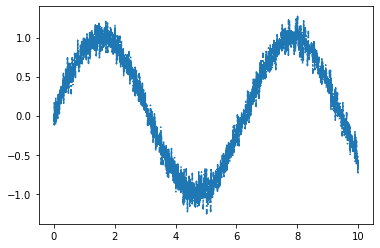

In [153]:
X = np.linspace(0, 10, 2000)[:, None]
Y = np.sin(X) + np.random.randn(*X.shape)*0.1

kernel2 = GPy.kern.sde_Matern32(X.shape[1])
m2 = GPy.models.StateSpace(X,Y, kernel2)
print('m2', m2)

m2.optimize(optimizer='bfgs',messages=True)
print('m2.opt', m2)


plt.plot(X, Y, '-.')

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import gpflow
import numpy as np

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
# from multiclass_classification import plot_from_samples, colors

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)

import matplotlib.pyplot as plt
%matplotlib inline

0


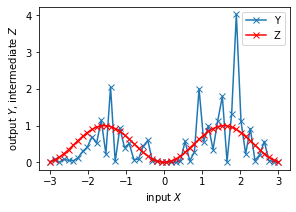

In [34]:
rng = np.random.RandomState(1)

# data_X = []
# data_Y = []

for i in range(1):
    print(i)
    X = np.linspace(-3, 3, 50)
    Z = np.sin(X) ** 2
    Y = rng.exponential(Z)

    plt.figure(figsize=(4.5,3))
    plt.plot(X, Y, "x-")
    plt.xlabel("input $X$")
    plt.plot(X, Z, "xr-")
    plt.ylabel("output $Y$, intermediate $Z$")
    plt.legend(["Y", "Z"])
    plt.show()

#     data_X.append(X)
#     data_Y.append(Y)
    
# data = np.column_stack((data_X, data_Y))

# print('data', data)
data = (X[:, None], Y[:, None])
# print('data_0', data_0)


In [35]:
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Constant()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[1].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(50, 1)",float64,[[0....


In [36]:
optimizer_0 = gpflow.optimizers.Scipy()
maxiter = ci_niter(3000)
_ = optimizer_0.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)
# We can now start HMC near maximum a posteriori (MAP)

In [37]:
num_burnin_steps = ci_niter(600)
num_samples = ci_niter(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(num_results=num_samples,
                                 num_burnin_steps=num_burnin_steps,
                                current_state=hmc_helper.current_state,
                                kernel=adaptive_hmc,
                                trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
                                )


samples, _ = run_chain_fn()

In [38]:
Xtest = np.linspace(-4, 4, 100)[:, None]
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(Xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

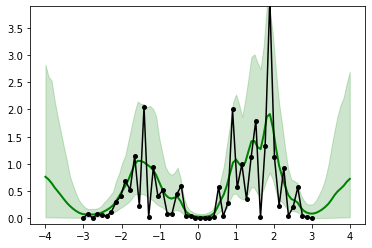

In [41]:
rate_samples = np.exp(f_samples[:, :, 0])

(line,) = plt.plot(Xtest, np.mean(rate_samples, 0), 'g', lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(rate_samples, 5, axis=0),
    np.percentile(rate_samples, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, Y, "k.-", mew=2)
_ = plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

In [32]:
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Constant()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[1].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(141, 50)",float64,"[[0., 0., 0...."


In [33]:
optimizer = gpflow.optimizers.Scipy()
maxiter = ci_niter(3000)
_ = optimizer.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)

InvalidArgumentError:  Input matrix is not invertible.
	 [[node gradient_tape/triangular_solve/MatrixTriangularSolve (defined at /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpflow/optimizers/scipy.py:166) ]] [Op:__inference__tf_eval_461771]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/triangular_solve/MatrixTriangularSolve:
 Cholesky (defined at /Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpflow/models/gpmc.py:87)

Function call stack:
_tf_eval


In [ ]:
# kernel_list = [DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2,
#                RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
#                RationalQuadratic(length_scale=1.0, alpha=0.1),
#                Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
#                ]

kernel_list = [RationalQuadratic(length_scale=1.0, alpha=0.1)]
# print("* Kernel list:", kernel_list)
# print("* number of sample tests: ", len(X_test), "\n")


# fig, ax = plt.subplots(len(X_test), len(kernel_list), 
#                        figsize=[len(kernel_list)*5, len(X_test)*3]) #sharey=True   
    

best_gpr = None
for k, kernel in enumerate(kernel_list):
    gpr = GPR(kernel=kernel)
    gpr.fit(GPSSM_train_input, GPSSM_train_output)
#     print("score of training set: %.4f" % (gpr.score(X_train, Y_train)))

    
    for veh_id, _ in actual_tracks_dict_idm_sd.items():
        if veh_id > 125:
            track_sd = actual_tracks_dict_idm_sd[veh_id]
            
            GPSSM_test_input = 0
            
            
            
            GPSSM_test_input = []
            for p, _ in enumerate(track_sd):
                if p == 0:
                    GPSSM_test_input.append(0)
                else:
                    GPSSM_test_input.append(track_sd[p,1] - track_sd[p-1,1])  ##add distance headway

                
            for 
            
            GPSSM_test_output_mean, GPSSM_test_output_std = gpr.predict(GPSSM_test_input, return_std=True, return_cov=False)
            


## state space
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.StateSpace.html

In [20]:
from scipy import signal

a = np.array([[0, 1], [0, 0]])
b = np.array([[0], [1]])
c = np.array([[1, 0]])
d = np.array([[0]])

sys = signal.StateSpace(a, b, c, d)
print(sys)

StateSpaceContinuous(
array([[0, 1],
       [0, 0]]),
array([[0],
       [1]]),
array([[1, 0]]),
array([[0]]),
dt: None
)


In [21]:
sys.to_discrete(0.1)

StateSpaceDiscrete(
array([[1. , 0.1],
       [0. , 1. ]]),
array([[0.005],
       [0.1  ]]),
array([[1, 0]]),
array([[0]]),
dt: 0.1
)

In [22]:
a = np.array([[1, 0.1], [0, 1]])
b = np.array([[0.005], [0.1]])

signal.StateSpace(a, b, c, d, dt=0.1)

StateSpaceDiscrete(
array([[1. , 0.1],
       [0. , 1. ]]),
array([[0.005],
       [0.1  ]]),
array([[1, 0]]),
array([[0]]),
dt: 0.1
)

# Multiple lanes (lane changes considered)

## Interaction Animation - w/ multiple lanes

In [232]:
from matplotlib.patches import Rectangle

import sys
sys.path.append("python/")
from utils import map_vis_without_lanelet


In [1142]:
def simulate_multilane(veh_id):
    
    map_file = 'maps/' + scene + '.osm'
    
    track = actual_tracks_dict_idm_with_headway[veh_id]
    min_t, max_t = track[0,0], track[-1,0]
    print('veh_id: %s, t_span: %s-%s' % (veh_id, min_t, max_t))
    
    def update_t(t):
        global save_t
        save_t = t

    def f(t):
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(18, 10)
        lat_origin, lon_origin = 0., 0.
        map_vis_without_lanelet.draw_map_without_lanelet(map_file, axes, lat_origin, lon_origin)
        
        plt.ylim(930, 980)
        plt.xlabel("x[m]"); plt.ylabel("y[m]")
        plt.arrow(lane_rx[0]+10, lane_ry[0], -5, -1, color='r', length_includes_head=True, head_width=1, head_length=1)
#         plt.plot(lane_rx, lane_ry, "--r")

        ### Plot own vehicle
        idx = np.where(track[:,0]==t)[0] 
        plt.scatter(track[idx, 1], track[idx, 2], s=100, c='b')
#         plt.plot(track[:, 1], track[:, 2], '--b', lw=0.8)
        plt.text(track[idx, 1], track[idx, 2]+3, str(veh_id), fontsize=15, va="center", ha="center", color='b')

        ### Plot other vehicles
        for veh_id_other, track_other in actual_tracks_dict_idm_with_headway.items():
            if veh_id_other != veh_id and track_other[0,0] < t and track_other[-1,0] > t:
                idx_other = np.where(track_other[:,0] == t)[0][0]    
                plt.scatter(track_other[idx_other, 1], track_other[idx_other, 2], s=80, c='g')
#                 plt.plot(track_other[:, 1], track_other[:, 2], '--g', lw=0.3)
                plt.text(track_other[idx_other, 1], track_other[idx_other, 2]+3,
                           str(veh_id_other), fontsize=15, va="center", ha="center", color='g')

    
        update_t(t)

        global save_t
        global save        
        if save == 1:
            print('save at t=', t)
            plt.savefig("screenshot_veh_id=%s_t=%s.pdf" % (veh_id, int(save_t)))
            plt.close()
            save = 0

    global save
    save_t = 10
    save = 0
    
    button = ipywidgets.Button(description="Save screenshot")
    display(button)

    widget = ipywidgets.interactive(f, t=(min_t, max_t, 5))
    output = widget.children[-1]
    output.layout.height = '450px'
    display(widget)


    def on_button_clicked(b):
        global save_t
        print('Save screenshot of veh_id=%s at t=%s' % (veh_id, int(save_t)))
        global save
        save = 1
        f(save_t)
    
    button.on_click(on_button_clicked)


In [1143]:
simulate_multilane(30)


veh_id: 30, t_span: 765-1046


Button(description='Save screenshot', style=ButtonStyle())

interactive(children=(IntSlider(value=905, description='t', max=1046, min=765, step=5), Output(layout=Layout(h…

# GP hyperparameter estimation

https://www.cs.toronto.edu/~duvenaud/cookbook/

https://www.slideshare.net/JungkyuLee1/gaussian-processes

https://scikit-learn.org/stable/modules/gaussian_process.html

https://peterroelants.github.io/posts/gaussian-process-kernels/


https://enginius.tistory.com/317

https://distill.pub/2019/visual-exploration-gaussian-processes/

https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

* MultiOutputRegressor in sklearn : https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py

* GPytorch : https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html#Setting-up-the-model

* Pyro : https://pyro.ai/examples/timeseries.html

* GPy : https://github.com/SheffieldML/GPy/tree/devel/GPy
* GPflow : https://gpflow.readthedocs.io/en/master/notebooks/advanced/multioutput.html

* GPLVM : https://github.com/koptelovmax/gaussianprocess/tree/master/Python

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [353]:
import torch
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# sys.path.append("../")
# import CalibratedTimeseriesModels
# from CalibratedTimeseriesModels.utils import *

### Gpytorch

In [354]:
import gpytorch

def electric_train_test_split(X, Y, test_size=0.25, random_state=1, disp_idx=36):
    """
    Performs train/test split for electric dataset by avoiding overlaps in rolling windows.
    
    Args:
        X (torch.tensor): (num_locs,n,in_features) tensor of inputs
        Y (torch.tensor): (num_locs,n,out_features) tensor of corresponding outputs
        test_size (float)
        random_state (int): seed for the random number generator
        disp_idx (int): index by which to displace indices to avoid test/train overlap
    Returns:
        X_train (torch.tensor): (num_locs,m,in_features) tensor of training inputs
        X_test (torch.tensor): (num_locs,t,in_features) tensor of testing inputs
        Y_train (torch.tensor): (num_locs,m,out_features) tensor of training inputs
        Y_test (torch.tensor): (num_locs,t,out_features) tensor of testing inputs
    """    
    _, n, _ = X.shape
    random.seed(random_state)
    week_idx = 24*7
    X_train, X_test, Y_train, Y_test = [], [], [], []
    prev_batch_train = True
    for i in range(math.ceil(n/week_idx)):
        start_idx = i*week_idx
        end_idx = min((i+1)*week_idx,n)
        
        # add to training
        if random.random()>test_size:
            
            # if switching batch, add to start index
            if not prev_batch_train:
                start_idx += disp_idx
                prev_batch_train = True
            X_train.append(X[:,start_idx:end_idx,:])
            Y_train.append(Y[:,start_idx:end_idx,:])
            
        # add to testing
        else:
            
            # if switching batch, add to start index
            if prev_batch_train:
                start_idx += disp_idx
                prev_batch_train = False
            X_test.append(X[:,start_idx:end_idx,:])
            Y_test.append(Y[:,start_idx:end_idx,:])
    X_train = torch.cat(X_train, dim=1)
    X_test = torch.cat(X_test, dim=1)
    Y_train = torch.cat(Y_train, dim=1)
    Y_test = torch.cat(Y_test, dim=1)
    return X_train, X_test, Y_train, Y_test

In [357]:
# file_location = 'processed/openEI'
# locnum = 11
# postfix = '_openei_%03d_subset_multitask.pt' %(locnum)

# X_orig = np.array(torch.load(os.path.join(file_location, "X"+postfix))[0,:,:24])
# Y_orig = np.array(torch.load(os.path.join(file_location, "Y"+postfix))[0])

X_orig = torch.load("../processed/openEI/X_openei_011_subset_multitask.pt")
Y_orig = torch.load("../processed/openEI/Y_openei_011_subset_multitask.pt")
print("X_orig", X_orig.shape)
print("Y_orig", Y_orig.shape)

past_dims = 24
fut_dims = 12

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = electric_train_test_split(X_orig, Y_orig, disp_idx=past_dims+fut_dims)
print('\nX_train_orig', X_train_orig.shape)
print('Y_train_orig', Y_train_orig.shape)
print('X_test_orig', X_test_orig.shape)
print('Y_test_orig', Y_test_orig.shape)

train_idxs = [*range(past_dims)] #,*range(-6,0,1)]
print("\ntrain_idxs", train_idxs)
X_train = X_train_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_train = Y_train_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()
X_test = X_test_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_test = Y_test_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()
print("\nX_train", X_train.shape)
print("Y_train", Y_train.shape)
print('X_test', X_test.shape)
print('Y_test', Y_test.shape)


X_orig torch.Size([11, 8712, 77])
Y_orig torch.Size([11, 8712, 12])

X_train_orig torch.Size([11, 5628, 77])
Y_train_orig torch.Size([11, 5628, 12])
X_test_orig torch.Size([11, 2292, 77])
Y_test_orig torch.Size([11, 2292, 12])

train_idxs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

X_train torch.Size([5628, 24, 1])
Y_train torch.Size([5628, 12, 1])
X_test torch.Size([2292, 24, 1])
Y_test torch.Size([2292, 12, 1])


In [32]:

class MultitaskGPModel(gpytorch.models.ExactGP):    
    def __init__(self, train_x, train_y, likelihood, kernel, num_tasks, rank):
        self.num_tasks = num_tasks
        self.rank = rank
        print("self.num_tasks",self.num_tasks)
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=self.num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            kernel, num_tasks=self.num_tasks, rank=self.rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [41]:
# torch.cuda.empty_cache()
train_x, train_y = X_train.reshape(X_train.size(0),-1), Y_train.reshape(Y_train.size(0),-1)
print('train_x', train_x.shape)
print('train_y', train_y.shape)

covar_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=24)
index_rank = 12 
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=12)
model = MultitaskGPModel(train_x, train_y, likelihood, kernel=covar_kernel, 
                         num_tasks=12, rank=index_rank)


train_x torch.Size([5628, 24])
train_y torch.Size([5628, 12])
self.num_tasks 12


In [58]:
### Train the model hyperparameters
training_iter = 20

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
#     print("output", output)
    loss = -mll(output, train_y)
    loss.backward()
    if i%1==0:
        print('Iter %d/%d - Mean Loss: %.3f' % (i + 1, training_iter, loss.item()/train_x.size(0)))
    optimizer.step()

Iter 1/20 - Mean Loss: -0.259
Iter 2/20 - Mean Loss: -0.265
Iter 3/20 - Mean Loss: -0.258
Iter 4/20 - Mean Loss: -0.258
Iter 5/20 - Mean Loss: -0.235
Iter 6/20 - Mean Loss: -0.208
Iter 7/20 - Mean Loss: -0.185
Iter 8/20 - Mean Loss: -0.174
Iter 9/20 - Mean Loss: -0.159


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5020225048065186 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 10/20 - Mean Loss: -0.116


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.7548089027404785 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 11/20 - Mean Loss: -0.064


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.1939940452575684 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 12/20 - Mean Loss: -0.041


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.3720359802246094 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 13/20 - Mean Loss: -0.029


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.510241746902466 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 14/20 - Mean Loss: -0.008


/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:317: NumericalWarning: CG terminated in 1000 iterations with average residual norm 4.6257758140563965 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  NumericalWarning,


Iter 15/20 - Mean Loss: -0.003


KeyboardInterrupt: 

test_x torch.Size([2292, 24])
test_y torch.Size([2292, 12])


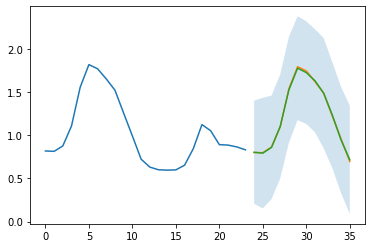

In [54]:
test_x, test_y = X_test.reshape(X_test.size(0),-1), Y_test.reshape(Y_test.size(0),-1)
print('test_x', test_x.shape)
print('test_y', test_y.shape)

### Make predictions with the model
model.eval()
likelihood.eval()

# Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = test_x[:10,:] #torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

plt.plot(range(24),X_test[0,:,0])
# plt.plot(range(24,36), samples[:5,0,:].T)
plt.plot(range(24,36),Y_test[0,:]) #orange
plt.plot(range(24,36),mean[0,:].cpu())
plt.fill_between(range(24,36), lower[0,:].cpu(), upper[0,:].cpu(), alpha=0.2)
plt.show()


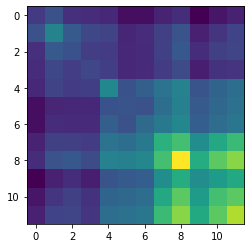

In [56]:
with torch.no_grad():
    K = model.covar_module.task_covar_module._eval_covar_matrix()
    plt.imshow(K.cpu().numpy())

### sklearn

In [358]:
file_location = '../processed/openEI'
locnum = 11
postfix = '_openei_%03d_subset_multitask.pt' %(locnum)

X0 = np.array(torch.load(os.path.join(file_location, "X"+postfix))[0,:,:24])
Y0 = np.array(torch.load(os.path.join(file_location, "Y"+postfix))[0])
print("X0", X0.shape)
print("Y0", Y0.shape)

X0_reversed = np.zeros_like(X0)
for i in range(X0.shape[0]):
    X0_reversed[i,:] = X0[i,::-1]
print("X0_reversed", X0_reversed.shape)

col = [0,1,2,3,4,5,6,7,8,9,10,11]
Y0 = Y0[:,col]

X_train, X_test, Y_train, Y_test = train_test_split(X0_reversed, Y0, test_size=0.1,random_state=1)
X_train_red, X_cv, Y_train_red, Y_cv = train_test_split(X_train, Y_train, train_size = 0.7/0.9,random_state=1)

np.random.seed(3)
indices_train = np.random.randint(len(X_train), size=200)
X_train = X_train[indices_train,:]
Y_train = Y_train[indices_train,:]
print("indices_train", np.shape(indices_train))

np.random.seed(1)
indices_test = np.random.randint(len(X_test), size=3)
X_test = X_test[indices_test,:]
Y_test = Y_test[indices_test,:]

print("\nindices_test", np.shape(indices_test), indices_test)
print("X_train", X_train.shape, ", X_test", X_test.shape)
print("Y_train", Y_train.shape, ", Y_test", Y_test.shape)


X0 (8712, 24)
Y0 (8712, 12)
X0_reversed (8712, 24)
indices_train (200,)

indices_test (3,) [ 37 235  72]
X_train (200, 24) , X_test (3, 24)
Y_train (200, 12) , Y_test (3, 12)


In [ ]:
# file_location = '../processed/openEI'
# locnum = 11
# postfix = '_openei_%03d_subset_multitask.pt' %(locnum)

# X0 = np.array(torch.load(os.path.join(file_location, "X"+postfix))[0,:,:24])
# Y0 = np.array(torch.load(os.path.join(file_location, "Y"+postfix))[0])
# print("X0", X0.shape)
# print("Y0", Y0.shape)

# X0_reversed = np.zeros_like(X0)
# for i in range(X0.shape[0]):
#     X0_reversed[i,:] = X0[i,::-1]
# print("X0_reversed", X0_reversed.shape)

# X_train, X_test, Y_train, Y_test = train_test_split(X0_reversed, Y0, test_size=0.1,random_state=1)
# X_train_red, X_cv, Y_train_red, Y_cv = train_test_split(X_train, Y_train, train_size = 0.7/0.9,random_state=1)

# np.random.seed(3)
# indices_train = np.random.randint(len(X_train), size=200)
# X_train = X_train[indices_train,:]
# Y_train = Y_train[indices_train,:]
# print("indices_train", np.shape(indices_train))

# np.random.seed(1)
# indices_test = np.random.randint(len(X_test), size=3)
# X_test = X_test[indices_test,:]
# Y_test = Y_test[indices_test,:]

# print("\nindices_test", np.shape(indices_test), indices_test)
# print("X_train", X_train.shape, ", X_test", X_test.shape)
# print("Y_train", Y_train.shape, ", Y_test", Y_test.shape)

* Kernel list: [DotProduct(sigma_0=1) ** 2, RBF(length_scale=1), RationalQuadratic(alpha=0.1, length_scale=1), Matern(length_scale=1, nu=1.5)]
* number of sample tests:  3 



/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Y_std (3,) [0.06501171 0.07106003 0.07225248]


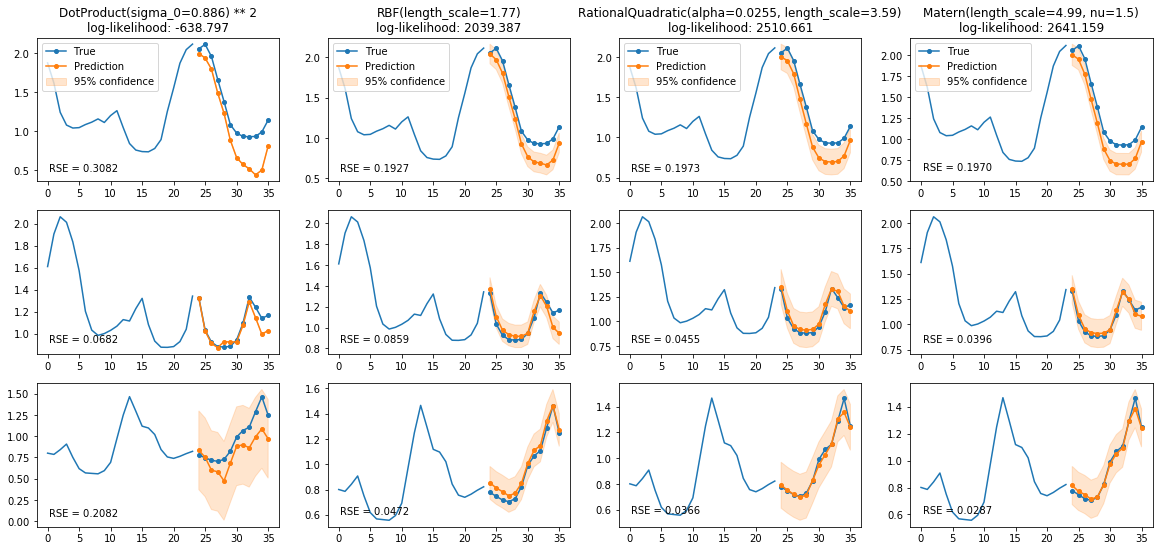


* Best GP kernel: Matern(length_scale=4.99, nu=1.5)
* log-likelihood: 2641.1585769306243
* parameters: {'length_scale': 4.99468192481481, 'length_scale_bounds': (0.1, 10.0), 'nu': 1.5}


In [359]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, RationalQuadratic, Matern, ExpSineSquared

from sklearn.multioutput import MultiOutputRegressor as MOR
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score


kernel_list = [DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2,
               RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
               RationalQuadratic(length_scale=1.0, alpha=0.1),
               Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
               ]
print("* Kernel list:", kernel_list)
print("* number of sample tests: ", len(X_test), "\n")


fig, ax = plt.subplots(len(X_test), len(kernel_list), 
                       figsize=[len(kernel_list)*5, len(X_test)*3]) #sharey=True   
best_gpr = None
for k, kernel in enumerate(kernel_list):
    gpr = GPR(kernel=kernel)
    gpr.fit(X_train, Y_train)
#     print("score of training set: %.4f" % (gpr.score(X_train, Y_train)))
 
    Y_preds, Y_std = gpr.predict(X_test, return_std=True, return_cov=False)
#     RMSE = mean_squared_error(Y_preds, Y_test) ** 0.5
#     print("RMSE:", RMSE)
    if k == 3: print("Y_std", Y_std.shape, Y_std)
    
    for i in range(len(X_test)):
        X_test_i = X_test[i]
        X_pred_i = range(X_test_i.shape[0], X_test_i.shape[0] + Y_preds[i].shape[0])

        RSE = mean_squared_error(Y_preds[i], Y_test[i]) ** 0.5
#         print("RSE of %s-th sample: %.4f" % (i, RSE))
#         print("score of %s-th sample: %.4f" % (i, gpr.score(X_test_i.reshape(1,-1), Y_preds[i].reshape(1,-1))))  

        ax[i, k].plot(X_test_i)
        ax[i, k].plot(X_pred_i, Y_test[i], '-o', markersize=4, color="#1f77b4", label='True')
        ax[i, k].plot(X_pred_i, Y_preds[i], '-o', markersize=4, color="#ff7f0e", label='Prediction')
        ax[i, k].fill(np.concatenate([X_pred_i, X_pred_i[::-1]]),
                 np.concatenate([Y_preds[i] - 1.9600 * Y_std[i], (Y_preds[i] + 1.9600 * Y_std[i])[::-1]]),
                 alpha=.2, ec='None', color="#ff7f0e", label='95% confidence')
        ax[i,k].text(0.25, np.min([np.min(X_test_i), np.min(Y_preds[i] - 1.9600 * Y_std[i])])+0.05, "RSE = %.4f" % RSE)
        if i == 0:
            ax[i, k].set_title("%s\nlog-likelihood: %.3f" % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)))
            ax[i, k].legend(loc='upper left')

    if best_gpr == None or gpr.log_marginal_likelihood(gpr.kernel_.theta) > best_gpr.log_marginal_likelihood(best_gpr.kernel_.theta):
        best_gpr = gpr
        
plt.savefig("GPR_with_diff_kernels.png")
plt.show() 
print("\n* Best GP kernel:", best_gpr.kernel_)
print("* log-likelihood:", best_gpr.log_marginal_likelihood(best_gpr.kernel_.theta))
print("* parameters:", best_gpr.kernel_.__dict__)


In [ ]:
Y_cov (3, 3) [[ 4.22955360e-03 -1.02276875e-04  9.35201699e-06]
 [-1.02276875e-04  5.04361438e-03 -3.55845023e-05]
 [ 9.35201699e-06 -3.55845023e-05  5.21451611e-03]]

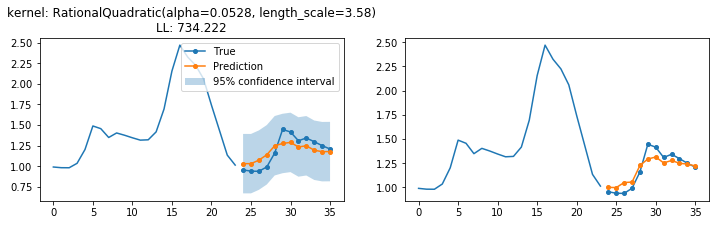

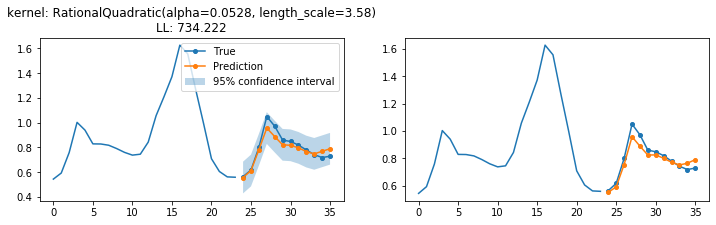

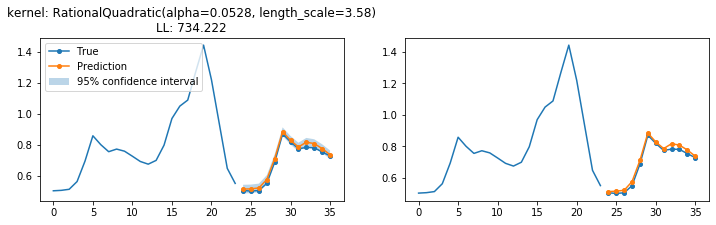

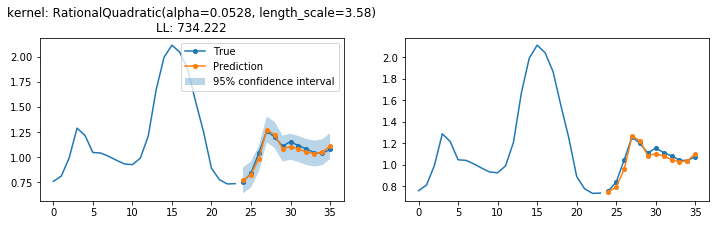

In [53]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, RationalQuadratic

from sklearn.multioutput import MultiOutputRegressor as MOR
%matplotlib inline

kernel_RQ = RationalQuadratic(length_scale=1.0, alpha=0.1)
GPR_RQ = GPR(kernel=kernel_RQ)
GPR_RQ.fit(X_train, Y_train)
Y_preds, Y_std = GPR_RQ.predict(X_test, return_std=True)

# multi_reg = MOR(GPR(RationalQuadratic(length_scale=1.0, alpha=0.1)))
# multi_reg.fit(X_train, Y_train)
# Y_multi_preds = multi_reg.predict(X_test)


for i in range(len(X_test)):
    X_test_i = X_test[i]
    X_pred_i = range(X_test_i.shape[0], X_test_i.shape[0] + Y_preds[i].shape[0])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 3]) #sharey=True   
    ax1.plot(X_test_i)
    ax1.plot(X_pred_i, Y_test[i], '-o', markersize=4, color="#1f77b4", label='True')
    ax1.plot(X_pred_i, Y_preds[i], '-o', markersize=4, label='Prediction')
    ax1.fill(np.concatenate([X_pred_i, X_pred_i[::-1]]),
             np.concatenate([Y_preds[i] - 1.9600 * Y_std[i], (Y_preds[i] + 1.9600 * Y_std[i])[::-1]]),
             alpha=.3, ec='None', label='95% confidence interval')
    ax1.set_title("kernel: %s\nLL: %.3f" % (reg.kernel_, reg.log_marginal_likelihood(reg.kernel_.theta)))
    ax1.legend()
    
    
    ax2.plot(X_test_i)
    ax2.plot(range(X_test_i.shape[0], X_test_i.shape[0] + Y_multi_preds[i].shape[0]), Y_test[i], 
             '-o', markersize=4, color="#1f77b4", label='True')
    ax2.plot(range(X_test_i.shape[0], X_test_i.shape[0] + Y_multi_preds[i].shape[0]), Y_multi_preds[i], 
             '-o', markersize=4)

    

In [104]:
# best_gpr.log_marginal_likelihood(best_gpr.kernel_.theta)
reg.score(X_train, Y_train)

/Users/soyeonjung/miniconda3/envs/K2/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9999999999999996

In [89]:
best_gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__alpha': 0.1,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__alpha_bounds': (1e-05, 100000.0),
 'kernel': RationalQuadratic(alpha=0.1, length_scale=1),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [200]:
best_gpr.kernel_.theta

# Note that theta are typically the log-transformed values of the kernel’s hyperparameters 
# as this representation of the search space is more amenable for hyperparameter search, 
# as hyperparameters like length-scales naturally live on a log-scale.


array([1.60837291])

In [66]:
best_gpr.kernel_.is_stationary()

True

In [91]:
best_gpr.kernel_.__dict__

{'length_scale': 3.5837699496135507,
 'alpha': 0.052812275180711195,
 'length_scale_bounds': (1e-05, 100000.0),
 'alpha_bounds': (1e-05, 100000.0)}

In [ ]:
def get_cov_matrix()

In [65]:
K = reg.kernel_
D = reg.kernel_.diag(X_train)
print(K)

# plt.figure(figsize=(8, 5))
# plt.imshow(K)
# plt.imshow(np.diag(D**-0.5).dot(K).dot(np.diag(D**-0.5)))


RationalQuadratic(alpha=0.0528, length_scale=3.58)
